# Base Model

### V.1.1

In [4]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
import random
import string
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

class TabularDataset(Dataset):
    def __init__(self, data, categorical_columns, numerical_columns):
        # Don't convert to tensor immediately - we'll handle this in preprocessing
        self.data = data
        self.categorical_columns = categorical_columns
        self.numerical_columns = numerical_columns
        self.n_samples = len(data)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        sample = self.data[idx]
        # Convert only numerical columns to float tensor
        numerical_data = torch.FloatTensor([sample[self.numerical_columns.index(col)]
                                          for col in self.numerical_columns])
        # Keep categorical data as integers
        categorical_data = torch.LongTensor([sample[self.categorical_columns.index(col)]
                                           for col in self.categorical_columns]) if self.categorical_columns else torch.tensor([])
        return {'numerical': numerical_data, 'categorical': categorical_data}

class DataPreprocessor:
    def __init__(self):
        self.categorical_columns = []
        self.numerical_columns = []
        self.id_like_columns = []
        self.column_types = {}
        self.num_scalers = {}
        self.categorical_maps = {}
        self.categorical_inverse_maps = {}
        self.column_stats = {}

    def detect_column_types(self, df):
        for col in df.columns:
            
            # Rakhib: Added for Boolean data types

            if pd.api.types.is_bool_dtype(df[col]):
                self.categorical_columns.append(col)
                self.column_types[col] = 'categorical'
            elif pd.api.types.is_numeric_dtype(df[col]):
                unique_ratio = df[col].nunique() / len(df)
                if unique_ratio > 0.9:
                    self.id_like_columns.append(col)
                    self.column_types[col] = 'id'
                else:
                    self.numerical_columns.append(col)
                    self.column_types[col] = 'numerical'
            else:
                unique_ratio = df[col].nunique() / len(df)
                if unique_ratio > 0.5:
                    self.id_like_columns.append(col)
                    self.column_types[col] = 'id'
                else:
                    self.categorical_columns.append(col)
                    self.column_types[col] = 'categorical'

        print(f"Detected column types:")
        print(f"Numerical columns: {self.numerical_columns}")
        print(f"Categorical columns: {self.categorical_columns}")
        print(f"ID-like columns: {self.id_like_columns}")

    def compute_numerical_stats(self, df):
        for col in self.numerical_columns:
            col_data = df[col].dropna().values
            self.column_stats[col] = {
                'mean': np.mean(col_data),
                'std': np.std(col_data),
                'min': np.min(col_data),
                'max': np.max(col_data),
                'median': np.median(col_data),
                'skewness': stats.skew(col_data),
                'kurtosis': stats.kurtosis(col_data),
                'histogram': np.histogram(col_data, bins=20)
            }

    def preprocess(self, df):
        if not self.column_types:
            self.detect_column_types(df)
        self.compute_numerical_stats(df)
        processed_df = df.copy()

        for col in self.numerical_columns:
            scaler = MinMaxScaler()
            values = df[col].dropna().values.reshape(-1, 1)
            processed_df[col] = scaler.fit_transform(values).flatten()
            processed_df[col] = processed_df[col].fillna(0)  # Handle NaN
            self.num_scalers[col] = scaler

        for col in self.categorical_columns:
            unique_values = df[col].dropna().unique()
            value_to_idx = {val: idx for idx, val in enumerate(unique_values)}
            idx_to_value = {idx: val for idx, val in enumerate(unique_values)}
            processed_df[col] = df[col].map(value_to_idx).fillna(-1)  # Use -1 for NaN
            self.categorical_maps[col] = value_to_idx
            self.categorical_inverse_maps[col] = idx_to_value

        # Rakhib: Maintaining the original IDs
        # Store the original unique IDs for id_like columns
        self.original_ids = {}
        for col in self.id_like_columns:
            self.original_ids[col] = df[col].dropna().unique()

        columns_order = self.numerical_columns + self.categorical_columns + self.id_like_columns
        x_train = processed_df[columns_order].values
        return x_train, columns_order

    def inverse_transform(self, synthetic_data, columns_order):
        synthetic_df = pd.DataFrame(synthetic_data, columns=columns_order)
        result_df = pd.DataFrame()

        for col in self.numerical_columns:
            col_idx = columns_order.index(col)
            col_data = synthetic_data[:, col_idx].reshape(-1, 1)
            result_df[col] = self.num_scalers[col].inverse_transform(col_data).flatten()

        for col in self.categorical_columns:
            col_idx = columns_order.index(col)
            col_data = synthetic_data[:, col_idx].astype(int)
            result_df[col] = [self.categorical_inverse_maps[col].get(idx, 'Unknown')
                            for idx in col_data]

        for col in self.id_like_columns:
            col_idx = columns_order.index(col)
            result_df[col] = synthetic_data[:, col_idx]

        return result_df

class ConditionGenerator:
    def __init__(self, categorical_columns, n_categories_list):
        self.categorical_columns = categorical_columns
        self.n_categories_list = n_categories_list

    def generate_random_conditions(self, batch_size):
        conditions = []
        for n_categories in self.n_categories_list:
            cat_indices = np.random.randint(0, n_categories, batch_size)
            one_hot = np.zeros((batch_size, n_categories))
            one_hot[np.arange(batch_size), cat_indices] = 1
            conditions.append(one_hot)
        return np.concatenate(conditions, axis=1) if conditions else np.array([])

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, condition_dim=0, hidden_dim=256):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.condition_dim = condition_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, noise, condition=None):
        if self.condition_dim > 0 and condition is not None:
            combined_input = torch.cat([noise, condition], dim=1)
        else:
            combined_input = noise
        return self.model(combined_input)

class Discriminator(nn.Module):
    def __init__(self, input_dim, condition_dim=0, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.condition_dim = condition_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x, condition=None):
        if self.condition_dim > 0 and condition is not None:
            combined_input = torch.cat([x, condition], dim=1)
        else:
            combined_input = x
        return self.model(combined_input)

class CTGAN:
    def __init__(self, noise_dim=100, hidden_dim=256, batch_size=64, lr=0.0002, beta1=0.5, beta2=0.999):
        self.noise_dim = noise_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.preprocessor = DataPreprocessor()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def train(self, df, epochs=500, log_interval=50):
        x_train, columns_order = self.preprocessor.preprocess(df)
        dataset = TabularDataset(x_train, self.preprocessor.categorical_columns, self.preprocessor.numerical_columns)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        data_dim = len(self.preprocessor.numerical_columns) + len(self.preprocessor.categorical_columns)

        n_categories_list = []
        condition_dim = 0
        if self.preprocessor.categorical_columns:
            for col in self.preprocessor.categorical_columns:
                n_categories = len(self.preprocessor.categorical_maps[col])
                n_categories_list.append(n_categories)
                condition_dim += n_categories

        self.condition_generator = ConditionGenerator(self.preprocessor.categorical_columns, n_categories_list)
        self.generator = Generator(self.noise_dim, data_dim, condition_dim, self.hidden_dim).to(self.device)
        self.discriminator = Discriminator(data_dim, condition_dim, self.hidden_dim).to(self.device)

        optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        criterion = nn.BCELoss()

        d_losses, g_losses = [], []
        for epoch in range(epochs):
            epoch_d_loss = epoch_g_loss = 0
            batches = 0

            for i, batch in enumerate(dataloader):
                current_batch_size = batch['numerical'].size(0)
                real_labels = torch.ones(current_batch_size, 1).to(self.device)
                fake_labels = torch.zeros(current_batch_size, 1).to(self.device)

                # Combine numerical and categorical data
                real_data = torch.cat([batch['numerical'], batch['categorical'].float()], dim=1).to(self.device)

                if condition_dim > 0:
                    conditions = self.condition_generator.generate_random_conditions(current_batch_size)
                    conditions = torch.FloatTensor(conditions).to(self.device)
                else:
                    conditions = None

                optimizer_d.zero_grad()
                outputs_real = self.discriminator(real_data, conditions)
                d_loss_real = criterion(outputs_real, real_labels)
                noise = torch.randn(current_batch_size, self.noise_dim).to(self.device)
                fake_data = self.generator(noise, conditions)
                outputs_fake = self.discriminator(fake_data.detach(), conditions)
                d_loss_fake = criterion(outputs_fake, fake_labels)
                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                optimizer_d.step()

                optimizer_g.zero_grad()
                noise = torch.randn(current_batch_size, self.noise_dim).to(self.device)
                fake_data = self.generator(noise, conditions)
                outputs = self.discriminator(fake_data, conditions)
                g_loss = criterion(outputs, real_labels)
                g_loss.backward()
                optimizer_g.step()

                epoch_d_loss += d_loss.item()
                epoch_g_loss += g_loss.item()
                batches += 1

            avg_d_loss = epoch_d_loss / batches
            avg_g_loss = epoch_g_loss / batches
            d_losses.append(avg_d_loss)
            g_losses.append(avg_g_loss)

            if (epoch + 1) % log_interval == 0 or epoch == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch+1}/{epochs} - D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}")

        self.plot_training_progress(d_losses, g_losses)
        self.columns_order = columns_order
        return d_losses, g_losses

    def plot_training_progress(self, d_losses, g_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(d_losses, label='Discriminator')
        plt.plot(g_losses, label='Generator')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training Progress')
        plt.savefig('training_progress.png')
        plt.close()

    def generate_samples(self, n_samples):
        noise = torch.randn(n_samples, self.noise_dim).to(self.device)
        if hasattr(self, 'condition_generator') and len(self.preprocessor.categorical_columns) > 0:
            conditions = self.condition_generator.generate_random_conditions(n_samples)
            conditions = torch.FloatTensor(conditions).to(self.device)
        else:
            conditions = None

        self.generator.eval()
        with torch.no_grad():
            synthetic_data = self.generator(noise, conditions).cpu().numpy()

        # Pad with zeros for id_like_columns
        if self.preprocessor.id_like_columns:
            id_data = np.zeros((n_samples, len(self.preprocessor.id_like_columns)))
            synthetic_data = np.hstack([synthetic_data, id_data])

        # Convert the synthetic data to a DataFrame
        synthetic_df = self.preprocessor.inverse_transform(synthetic_data, self.columns_order)
    
        # Replace id_like columns by sampling from original IDs (works for both strings and ints)
        for col in self.preprocessor.id_like_columns:
            synthetic_df[col] = np.random.choice(self.preprocessor.original_ids[col], n_samples)
            
        return synthetic_df

    def save_model(self, path="ctgan_model.pth"):
        if not hasattr(self, 'generator'):
            print("Model has not been trained yet.")
            return
        torch.save({
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'columns_order': self.columns_order,
            'preprocessor': self.preprocessor,
            'noise_dim': self.noise_dim,
            'condition_dim': self.generator.condition_dim
        }, path)
        print(f"Model saved to {path}")

    def load_model(self, path="ctgan_model.pth"):
        if not os.path.exists(path):
            print(f"Model file {path} not found.")
            return False
        checkpoint = torch.load(path)
        self.columns_order = checkpoint['columns_order']
        self.preprocessor = checkpoint['preprocessor']
        self.noise_dim = checkpoint['noise_dim']
        condition_dim = checkpoint['condition_dim']

        n_categories_list = []
        if self.preprocessor.categorical_columns:
            for col in self.preprocessor.categorical_columns:
                n_categories = len(self.preprocessor.categorical_maps[col])
                n_categories_list.append(n_categories)

        self.condition_generator = ConditionGenerator(self.preprocessor.categorical_columns, n_categories_list)
        data_dim = len(self.columns_order)
        self.generator = Generator(self.noise_dim, data_dim, condition_dim, self.hidden_dim).to(self.device)
        self.discriminator = Discriminator(data_dim, condition_dim, self.hidden_dim).to(self.device)
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        print(f"Model loaded from {path}")
        return True

class SyntheticDataEvaluator:
    def __init__(self, real_df, synthetic_df, column_types):
        self.real_df = real_df
        self.synthetic_df = synthetic_df
        self.column_types = column_types
        self.numeric_columns = [col for col, type_ in column_types.items() if type_ == 'numerical']
        self.categorical_columns = [col for col, type_ in column_types.items() if type_ == 'categorical']
        self.id_columns = [col for col, type_ in column_types.items() if type_ == 'id']

    def evaluate_numeric_distributions(self):
        results = {}
        for col in self.numeric_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_data = self.real_df[col].dropna().values
                synthetic_data = self.synthetic_df[col].dropna().values
                real_mean = np.mean(real_data)
                synth_mean = np.mean(synthetic_data)
                real_std = np.std(real_data)
                synth_std = np.std(synthetic_data)
                ks_stat, ks_pval = stats.ks_2samp(real_data, synthetic_data)

                results[col] = {
                    'real_mean': real_mean,
                    'synthetic_mean': synth_mean,
                    'mean_diff_pct': abs(real_mean - synth_mean) / (abs(real_mean) + 1e-10) * 100,
                    'real_std': real_std,
                    'synthetic_std': synth_std,
                    'std_diff_pct': abs(real_std - synth_std) / (abs(real_std) + 1e-10) * 100,
                    'ks_statistic': ks_stat,
                    'ks_pvalue': ks_pval
                }

                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.hist(real_data, bins=30, alpha=0.7, label='Real')
                plt.hist(synthetic_data, bins=30, alpha=0.7, label='Synthetic')
                plt.title(f"Histogram Comparison - {col}")
                plt.legend()
                plt.subplot(1, 2, 2)
                stats.probplot(real_data, dist="norm", plot=plt)
                plt.title(f"Q-Q Plot (Real) - {col}")
                plt.tight_layout()
                plt.savefig(f"distribution_comparison_{col}.png")
                plt.close()

        return results

    def evaluate_categorical_distributions(self):
        results = {}
        for col in self.categorical_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_counts = self.real_df[col].value_counts(normalize=True)
                synth_counts = self.synthetic_df[col].value_counts(normalize=True)
                all_categories = list(set(real_counts.index) | set(synth_counts.index))
                real_dist = np.array([real_counts.get(cat, 0) for cat in all_categories])
                synth_dist = np.array([synth_counts.get(cat, 0) for cat in all_categories])
                chi2_stat, chi2_pval = stats.chisquare(synth_dist, real_dist)

                results[col] = {
                    'chi2_statistic': chi2_stat,
                    'chi2_pvalue': chi2_pval,
                    'categories': all_categories,
                    'real_distribution': real_dist,
                    'synthetic_distribution': synth_dist
                }

                plt.figure(figsize=(12, 6))
                x = np.arange(len(all_categories))
                width = 0.35
                plt.bar(x - width/2, real_dist, width, label='Real')
                plt.bar(x + width/2, synth_dist, width, label='Synthetic')
                plt.xlabel('Categories')
                plt.ylabel('Frequency')
                plt.title(f"Category Distribution Comparison - {col}")
                plt.xticks(x, all_categories, rotation=90)
                plt.legend()
                plt.tight_layout()
                plt.savefig(f"category_comparison_{col}.png")
                plt.close()

        return results

    def evaluate_uniqueness(self):
        results = {}
        for col in self.id_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_unique = self.real_df[col].nunique()
                synth_unique = self.synthetic_df[col].nunique()
                real_set = set(self.real_df[col].dropna().values)
                synth_set = set(self.synthetic_df[col].dropna().values)
                overlap = len(real_set.intersection(synth_set))

                results[col] = {
                    'real_unique_count': real_unique,
                    'synthetic_unique_count': synth_unique,
                    'overlap_count': overlap,
                    'overlap_percentage': overlap / len(real_set) * 100 if len(real_set) > 0 else 0
                }
        return results

    def generate_evaluation_report(self):
        numeric_results = self.evaluate_numeric_distributions()
        categorical_results = self.evaluate_categorical_distributions()
        uniqueness_results = self.evaluate_uniqueness()

        print("\n=== Synthetic Data Evaluation Report ===\n")
        print("\n--- Numerical Columns Evaluation ---")
        for col, metrics in numeric_results.items():
            print(f"\nColumn: {col}")
            print(f"  Mean: Real={metrics['real_mean']:.4f}, Synthetic={metrics['synthetic_mean']:.4f}, Diff={metrics['mean_diff_pct']:.2f}%")
            print(f"  Std Dev: Real={metrics['real_std']:.4f}, Synthetic={metrics['synthetic_std']:.4f}, Diff={metrics['std_diff_pct']:.2f}%")
            print(f"  KS Test: Statistic={metrics['ks_statistic']:.4f}, p-value={metrics['ks_pvalue']:.4f}")
            print("  Statistical Difference: " +
                  ("Significant" if metrics['ks_pvalue'] < 0.05 else "Not Significant"))

        print("\n--- Categorical Columns Evaluation ---")
        for col, metrics in categorical_results.items():
            print(f"\nColumn: {col}")
            print(f"  Chi-Square Test: Statistic={metrics['chi2_statistic']:.4f}, p-value={metrics['chi2_pvalue']:.4f}")
            print("  Statistical Difference: " +
                  ("Significant" if metrics['chi2_pvalue'] < 0.05 else "Not Significant"))

        print("\n--- ID-like Columns Evaluation ---")
        for col, metrics in uniqueness_results.items():
            print(f"\nColumn: {col}")
            print(f"  Unique Values: Real={metrics['real_unique_count']}, Synthetic={metrics['synthetic_unique_count']}")
            print(f"  Overlap: Count={metrics['overlap_count']}, Percentage={metrics['overlap_percentage']:.2f}%")
            print("  " + ("Warning: Significant overlap" if metrics['overlap_percentage'] > 5 else "Good: Low overlap"))

        return {'numeric_results': numeric_results, 'categorical_results': categorical_results, 'uniqueness_results': uniqueness_results}

def main():
    class Args:
        data = 'preprocessedDataset/preprocessed_transaction_data_sm.csv'
        output = 'synthetic_data.csv'
        samples = 1000
        epochs = 500
        batch_size = 64
        model_path = 'ctgan_model.pth'
        load_model = False

    args = Args()

    print(f"Loading data from {args.data}")
    df = pd.read_csv(args.data)
    print(f"Data shape: {df.shape}")

    ctgan = CTGAN(batch_size=args.batch_size)

    if args.load_model:
        success = ctgan.load_model(args.model_path)
        if not success:
            print("Failed to load model. Exiting.")
            return
    else:
        print("Training CT-GAN...")
        ctgan.train(df, epochs=args.epochs)
        ctgan.save_model(args.model_path)

    print(f"Generating {args.samples} synthetic samples...")
    synthetic_df = ctgan.generate_samples(args.samples)
    synthetic_df.to_csv(args.output, index=False)
    print(f"Synthetic data saved to {args.output}")

    print("Evaluating synthetic data quality...")
    evaluator = SyntheticDataEvaluator(df, synthetic_df, ctgan.preprocessor.column_types)
    evaluator.generate_evaluation_report()

if __name__ == "__main__":
    main()

Loading data from preprocessedDataset/preprocessed_transaction_data_sm.csv
Data shape: (1888, 24)
Using device: cuda
Training CT-GAN...
Detected column types:
Numerical columns: ['card_number', 'distance_from_home', 'transaction_hour']
Categorical columns: ['merchant_category', 'merchant_type', 'merchant', 'currency', 'country', 'city', 'city_size', 'card_type', 'card_present', 'device', 'channel', 'high_risk_merchant', 'weekend_transaction', 'is_fraud']
ID-like columns: ['transaction_id', 'customer_id', 'timestamp', 'amount', 'device_fingerprint', 'ip_address', 'velocity_last_hour']
Epoch 1/500 - D Loss: 0.7885, G Loss: 0.8584
Epoch 50/500 - D Loss: 0.0143, G Loss: 6.9175
Epoch 100/500 - D Loss: 0.0085, G Loss: 7.0900
Epoch 150/500 - D Loss: 0.0125, G Loss: 6.8607
Epoch 200/500 - D Loss: 0.0093, G Loss: 6.8591
Epoch 250/500 - D Loss: 0.0086, G Loss: 7.2022
Epoch 300/500 - D Loss: 0.0088, G Loss: 7.1985
Epoch 350/500 - D Loss: 0.0085, G Loss: 7.5970
Epoch 400/500 - D Loss: 0.0080, G Lo

D:\IIT\Coursework\Year 4\FYRP\FinalCode\venv\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp



=== Synthetic Data Evaluation Report ===


--- Numerical Columns Evaluation ---

Column: card_number
  Mean: Real=4175945502231480.0000, Synthetic=3788002468438367.0000, Diff=9.29%
  Std Dev: Real=2371624620023395.0000, Synthetic=3153375447710555.5000, Diff=32.96%
  KS Test: Statistic=0.3938, p-value=0.0000
  Statistical Difference: Significant

Column: distance_from_home
  Mean: Real=0.3718, Synthetic=0.5331, Diff=43.37%
  Std Dev: Real=0.4833, Synthetic=0.4642, Diff=3.96%
  KS Test: Statistic=0.6282, p-value=0.0000
  Statistical Difference: Significant

Column: transaction_hour
  Mean: Real=0.0000, Synthetic=0.0000, Diff=759341.40%
  Std Dev: Real=0.0000, Synthetic=0.0000, Diff=1298022.38%
  KS Test: Statistic=1.0000, p-value=0.0000
  Statistical Difference: Significant

--- Categorical Columns Evaluation ---

Column: merchant_category
  Chi-Square Test: Statistic=6.4039, p-value=0.4935
  Statistical Difference: Not Significant

Column: merchant_type
  Chi-Square Test: Statistic=13.

### V.1.2 - Maintaining ID type column distribution

In [11]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
import random
import string
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

class TabularDataset(Dataset):
    def __init__(self, data, categorical_columns, numerical_columns):
        # Don't convert to tensor immediately - we'll handle this in preprocessing
        self.data = data
        self.categorical_columns = categorical_columns
        self.numerical_columns = numerical_columns
        self.n_samples = len(data)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        sample = self.data[idx]
        # Convert only numerical columns to float tensor
        numerical_data = torch.FloatTensor([sample[self.numerical_columns.index(col)]
                                          for col in self.numerical_columns])
        # Keep categorical data as integers
        categorical_data = torch.LongTensor([sample[self.categorical_columns.index(col)]
                                           for col in self.categorical_columns]) if self.categorical_columns else torch.tensor([])
        return {'numerical': numerical_data, 'categorical': categorical_data}

class DataPreprocessor:
    def __init__(self):
        self.categorical_columns = []
        self.numerical_columns = []
        self.id_like_columns = []
        self.column_types = {}
        self.num_scalers = {}
        self.categorical_maps = {}
        self.categorical_inverse_maps = {}
        self.column_stats = {}

    def detect_column_types(self, df):
        for col in df.columns:
            
            # Rakhib: Added for Boolean data types

            if pd.api.types.is_bool_dtype(df[col]):
                self.categorical_columns.append(col)
                self.column_types[col] = 'categorical'
            elif pd.api.types.is_numeric_dtype(df[col]):
                unique_ratio = df[col].nunique() / len(df)
                if unique_ratio > 0.9:
                    self.id_like_columns.append(col)
                    self.column_types[col] = 'id'
                else:
                    self.numerical_columns.append(col)
                    self.column_types[col] = 'numerical'
            else:
                unique_ratio = df[col].nunique() / len(df)
                if unique_ratio > 0.5:
                    self.id_like_columns.append(col)
                    self.column_types[col] = 'id'
                else:
                    self.categorical_columns.append(col)
                    self.column_types[col] = 'categorical'

        print(f"Detected column types:")
        print(f"Numerical columns: {self.numerical_columns}")
        print(f"Categorical columns: {self.categorical_columns}")
        print(f"ID-like columns: {self.id_like_columns}")

    def compute_numerical_stats(self, df):
        for col in self.numerical_columns:
            col_data = df[col].dropna().values
            self.column_stats[col] = {
                'mean': np.mean(col_data),
                'std': np.std(col_data),
                'min': np.min(col_data),
                'max': np.max(col_data),
                'median': np.median(col_data),
                'skewness': stats.skew(col_data),
                'kurtosis': stats.kurtosis(col_data),
                'histogram': np.histogram(col_data, bins=20)
            }
    
    # Rakhib - Maintaining categorical column distribution as the original dataset
    
    def compute_categorical_distributions(self, df):
        self.categorical_distributions = {}
        for col in self.categorical_columns:
            counts = df[col].value_counts(normalize=True)
            # Store as a dictionary: value -> probability
            self.categorical_distributions[col] = counts.to_dict()

    def preprocess(self, df):
        if not self.column_types:
            self.detect_column_types(df)
        self.compute_numerical_stats(df)
        self.compute_categorical_distributions(df)  # <--- Rakhib - Maintaining categorical column distribution as the original dataset
        processed_df = df.copy()

        for col in self.numerical_columns:
            scaler = MinMaxScaler()
            values = df[col].dropna().values.reshape(-1, 1)
            processed_df[col] = scaler.fit_transform(values).flatten()
            processed_df[col] = processed_df[col].fillna(0)  # Handle NaN
            self.num_scalers[col] = scaler

        for col in self.categorical_columns:
            unique_values = df[col].dropna().unique()
            value_to_idx = {val: idx for idx, val in enumerate(unique_values)}
            idx_to_value = {idx: val for idx, val in enumerate(unique_values)}
            processed_df[col] = df[col].map(value_to_idx).fillna(-1)  # Use -1 for NaN
            self.categorical_maps[col] = value_to_idx
            self.categorical_inverse_maps[col] = idx_to_value

        # Rakhib: Maintaining the original IDs
        # Store the original unique IDs for id_like columns
        self.original_ids = {}
        for col in self.id_like_columns:
            self.original_ids[col] = df[col].dropna().unique()

        columns_order = self.numerical_columns + self.categorical_columns + self.id_like_columns
        x_train = processed_df[columns_order].values
        return x_train, columns_order

    def inverse_transform(self, synthetic_data, columns_order):
        synthetic_df = pd.DataFrame(synthetic_data, columns=columns_order)
        result_df = pd.DataFrame()

        for col in self.numerical_columns:
            col_idx = columns_order.index(col)
            col_data = synthetic_data[:, col_idx].reshape(-1, 1)
            result_df[col] = self.num_scalers[col].inverse_transform(col_data).flatten()

        for col in self.categorical_columns:
            col_idx = columns_order.index(col)
            col_data = synthetic_data[:, col_idx].astype(int)
            result_df[col] = [self.categorical_inverse_maps[col].get(idx, 'Unknown')
                            for idx in col_data]

        for col in self.id_like_columns:
            col_idx = columns_order.index(col)
            result_df[col] = synthetic_data[:, col_idx]

        return result_df

class ConditionGenerator:
    # def __init__(self, categorical_columns, n_categories_list):
    #     self.categorical_columns = categorical_columns
    #     self.n_categories_list = n_categories_list

    # Rakhib - Maintaining categorical column distribution as the original dataset
    
    def __init__(self, categorical_columns, categorical_distributions):
        self.categorical_columns = categorical_columns
        # Expect a dictionary: column -> {value: probability, ...}
        self.categorical_distributions = categorical_distributions
        # Also compute number of categories per column
        self.n_categories_list = [len(categorical_distributions[col]) for col in categorical_columns]

        # For easier sampling, store the category labels and probabilities in order
        self.category_info = {}
        for col in categorical_columns:
            dist = categorical_distributions[col]
            labels = list(dist.keys())
            probs = list(dist.values())
            self.category_info[col] = (labels, probs)

    def generate_random_conditions(self, batch_size):
        conditions = []
        for col in self.categorical_columns:
            labels, probs = self.category_info[col]
            # Sample labels according to the original distribution
            sampled_labels = np.random.choice(labels, size=batch_size, p=probs)
            # Convert to one-hot vectors
            one_hot = np.zeros((batch_size, len(labels)))
            for i, label in enumerate(sampled_labels):
                idx = labels.index(label)
                one_hot[i, idx] = 1
            conditions.append(one_hot)
        return np.concatenate(conditions, axis=1) if conditions else np.array([])

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, condition_dim=0, hidden_dim=256):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.condition_dim = condition_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, noise, condition=None):
        if self.condition_dim > 0 and condition is not None:
            combined_input = torch.cat([noise, condition], dim=1)
        else:
            combined_input = noise
        return self.model(combined_input)

class Discriminator(nn.Module):
    def __init__(self, input_dim, condition_dim=0, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.condition_dim = condition_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x, condition=None):
        if self.condition_dim > 0 and condition is not None:
            combined_input = torch.cat([x, condition], dim=1)
        else:
            combined_input = x
        return self.model(combined_input)

class CTGAN:
    def __init__(self, noise_dim=100, hidden_dim=256, batch_size=64, lr=0.0002, beta1=0.5, beta2=0.999):
        self.noise_dim = noise_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.preprocessor = DataPreprocessor()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def train(self, df, epochs=500, log_interval=50):
        x_train, columns_order = self.preprocessor.preprocess(df)
        dataset = TabularDataset(x_train, self.preprocessor.categorical_columns, self.preprocessor.numerical_columns)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        data_dim = len(self.preprocessor.numerical_columns) + len(self.preprocessor.categorical_columns)

        n_categories_list = []
        condition_dim = 0
        if self.preprocessor.categorical_columns:
            for col in self.preprocessor.categorical_columns:
                n_categories = len(self.preprocessor.categorical_maps[col])
                n_categories_list.append(n_categories)
                condition_dim += n_categories

        # self.condition_generator = ConditionGenerator(self.preprocessor.categorical_columns, n_categories_list)
        self.condition_generator = ConditionGenerator(self.preprocessor.categorical_columns, self.preprocessor.categorical_distributions)
        self.generator = Generator(self.noise_dim, data_dim, condition_dim, self.hidden_dim).to(self.device)
        self.discriminator = Discriminator(data_dim, condition_dim, self.hidden_dim).to(self.device)

        optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        criterion = nn.BCELoss()

        d_losses, g_losses = [], []
        for epoch in range(epochs):
            epoch_d_loss = epoch_g_loss = 0
            batches = 0

            for i, batch in enumerate(dataloader):
                current_batch_size = batch['numerical'].size(0)
                real_labels = torch.ones(current_batch_size, 1).to(self.device)
                fake_labels = torch.zeros(current_batch_size, 1).to(self.device)

                # Combine numerical and categorical data
                real_data = torch.cat([batch['numerical'], batch['categorical'].float()], dim=1).to(self.device)

                if condition_dim > 0:
                    conditions = self.condition_generator.generate_random_conditions(current_batch_size)
                    conditions = torch.FloatTensor(conditions).to(self.device)
                else:
                    conditions = None

                optimizer_d.zero_grad()
                outputs_real = self.discriminator(real_data, conditions)
                d_loss_real = criterion(outputs_real, real_labels)
                noise = torch.randn(current_batch_size, self.noise_dim).to(self.device)
                fake_data = self.generator(noise, conditions)
                outputs_fake = self.discriminator(fake_data.detach(), conditions)
                d_loss_fake = criterion(outputs_fake, fake_labels)
                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                optimizer_d.step()

                optimizer_g.zero_grad()
                noise = torch.randn(current_batch_size, self.noise_dim).to(self.device)
                fake_data = self.generator(noise, conditions)
                outputs = self.discriminator(fake_data, conditions)
                g_loss = criterion(outputs, real_labels)
                g_loss.backward()
                optimizer_g.step()

                epoch_d_loss += d_loss.item()
                epoch_g_loss += g_loss.item()
                batches += 1

            avg_d_loss = epoch_d_loss / batches
            avg_g_loss = epoch_g_loss / batches
            d_losses.append(avg_d_loss)
            g_losses.append(avg_g_loss)

            if (epoch + 1) % log_interval == 0 or epoch == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch+1}/{epochs} - D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}")

        self.plot_training_progress(d_losses, g_losses)
        self.columns_order = columns_order
        return d_losses, g_losses

    def plot_training_progress(self, d_losses, g_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(d_losses, label='Discriminator')
        plt.plot(g_losses, label='Generator')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training Progress')
        plt.savefig('training_progress.png')
        plt.close()

    def generate_samples(self, n_samples):
        noise = torch.randn(n_samples, self.noise_dim).to(self.device)
        if hasattr(self, 'condition_generator') and len(self.preprocessor.categorical_columns) > 0:
            conditions = self.condition_generator.generate_random_conditions(n_samples)
            conditions = torch.FloatTensor(conditions).to(self.device)
        else:
            conditions = None

        self.generator.eval()
        with torch.no_grad():
            synthetic_data = self.generator(noise, conditions).cpu().numpy()

        # Pad with zeros for id_like_columns
        if self.preprocessor.id_like_columns:
            id_data = np.zeros((n_samples, len(self.preprocessor.id_like_columns)))
            synthetic_data = np.hstack([synthetic_data, id_data])

        # Convert the synthetic data to a DataFrame
        synthetic_df = self.preprocessor.inverse_transform(synthetic_data, self.columns_order)
    
        # Replace id_like columns by sampling from original IDs (works for both strings and ints)
        for col in self.preprocessor.id_like_columns:
            synthetic_df[col] = np.random.choice(self.preprocessor.original_ids[col], n_samples)
            
        return synthetic_df

    def save_model(self, path="ctgan_model.pth"):
        if not hasattr(self, 'generator'):
            print("Model has not been trained yet.")
            return
        torch.save({
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'columns_order': self.columns_order,
            'preprocessor': self.preprocessor,
            'noise_dim': self.noise_dim,
            'condition_dim': self.generator.condition_dim
        }, path)
        print(f"Model saved to {path}")

    def load_model(self, path="ctgan_model.pth"):
        if not os.path.exists(path):
            print(f"Model file {path} not found.")
            return False
        checkpoint = torch.load(path)
        self.columns_order = checkpoint['columns_order']
        self.preprocessor = checkpoint['preprocessor']
        self.noise_dim = checkpoint['noise_dim']
        condition_dim = checkpoint['condition_dim']

        n_categories_list = []
        if self.preprocessor.categorical_columns:
            for col in self.preprocessor.categorical_columns:
                n_categories = len(self.preprocessor.categorical_maps[col])
                n_categories_list.append(n_categories)

        # Rakhib - Maintaining categorical column distribution as the original dataset
        # self.condition_generator = ConditionGenerator(self.preprocessor.categorical_columns, n_categories_list)
        self.condition_generator = ConditionGenerator(self.preprocessor.categorical_columns, self.preprocessor.categorical_distributions)
        data_dim = len(self.columns_order)
        self.generator = Generator(self.noise_dim, data_dim, condition_dim, self.hidden_dim).to(self.device)
        self.discriminator = Discriminator(data_dim, condition_dim, self.hidden_dim).to(self.device)
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        print(f"Model loaded from {path}")
        return True

class SyntheticDataEvaluator:
    def __init__(self, real_df, synthetic_df, column_types):
        self.real_df = real_df
        self.synthetic_df = synthetic_df
        self.column_types = column_types
        self.numeric_columns = [col for col, type_ in column_types.items() if type_ == 'numerical']
        self.categorical_columns = [col for col, type_ in column_types.items() if type_ == 'categorical']
        self.id_columns = [col for col, type_ in column_types.items() if type_ == 'id']

    def evaluate_numeric_distributions(self):
        results = {}
        for col in self.numeric_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_data = self.real_df[col].dropna().values
                synthetic_data = self.synthetic_df[col].dropna().values
                real_mean = np.mean(real_data)
                synth_mean = np.mean(synthetic_data)
                real_std = np.std(real_data)
                synth_std = np.std(synthetic_data)
                ks_stat, ks_pval = stats.ks_2samp(real_data, synthetic_data)

                results[col] = {
                    'real_mean': real_mean,
                    'synthetic_mean': synth_mean,
                    'mean_diff_pct': abs(real_mean - synth_mean) / (abs(real_mean) + 1e-10) * 100,
                    'real_std': real_std,
                    'synthetic_std': synth_std,
                    'std_diff_pct': abs(real_std - synth_std) / (abs(real_std) + 1e-10) * 100,
                    'ks_statistic': ks_stat,
                    'ks_pvalue': ks_pval
                }

                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.hist(real_data, bins=30, alpha=0.7, label='Real')
                plt.hist(synthetic_data, bins=30, alpha=0.7, label='Synthetic')
                plt.title(f"Histogram Comparison - {col}")
                plt.legend()
                plt.subplot(1, 2, 2)
                stats.probplot(real_data, dist="norm", plot=plt)
                plt.title(f"Q-Q Plot (Real) - {col}")
                plt.tight_layout()
                plt.savefig(f"distribution_comparison_{col}.png")
                plt.close()

        return results

    def evaluate_categorical_distributions(self):
        results = {}
        for col in self.categorical_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_counts = self.real_df[col].value_counts(normalize=True)
                synth_counts = self.synthetic_df[col].value_counts(normalize=True)
                all_categories = list(set(real_counts.index) | set(synth_counts.index))
                real_dist = np.array([real_counts.get(cat, 0) for cat in all_categories])
                synth_dist = np.array([synth_counts.get(cat, 0) for cat in all_categories])
                chi2_stat, chi2_pval = stats.chisquare(synth_dist, real_dist)

                results[col] = {
                    'chi2_statistic': chi2_stat,
                    'chi2_pvalue': chi2_pval,
                    'categories': all_categories,
                    'real_distribution': real_dist,
                    'synthetic_distribution': synth_dist
                }

                plt.figure(figsize=(12, 6))
                x = np.arange(len(all_categories))
                width = 0.35
                plt.bar(x - width/2, real_dist, width, label='Real')
                plt.bar(x + width/2, synth_dist, width, label='Synthetic')
                plt.xlabel('Categories')
                plt.ylabel('Frequency')
                plt.title(f"Category Distribution Comparison - {col}")
                plt.xticks(x, all_categories, rotation=90)
                plt.legend()
                plt.tight_layout()
                plt.savefig(f"category_comparison_{col}.png")
                plt.close()

        return results

    def evaluate_uniqueness(self):
        results = {}
        for col in self.id_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_unique = self.real_df[col].nunique()
                synth_unique = self.synthetic_df[col].nunique()
                real_set = set(self.real_df[col].dropna().values)
                synth_set = set(self.synthetic_df[col].dropna().values)
                overlap = len(real_set.intersection(synth_set))

                results[col] = {
                    'real_unique_count': real_unique,
                    'synthetic_unique_count': synth_unique,
                    'overlap_count': overlap,
                    'overlap_percentage': overlap / len(real_set) * 100 if len(real_set) > 0 else 0
                }
        return results

    def generate_evaluation_report(self):
        numeric_results = self.evaluate_numeric_distributions()
        categorical_results = self.evaluate_categorical_distributions()
        uniqueness_results = self.evaluate_uniqueness()

        print("\n=== Synthetic Data Evaluation Report ===\n")
        print("\n--- Numerical Columns Evaluation ---")
        for col, metrics in numeric_results.items():
            print(f"\nColumn: {col}")
            print(f"  Mean: Real={metrics['real_mean']:.4f}, Synthetic={metrics['synthetic_mean']:.4f}, Diff={metrics['mean_diff_pct']:.2f}%")
            print(f"  Std Dev: Real={metrics['real_std']:.4f}, Synthetic={metrics['synthetic_std']:.4f}, Diff={metrics['std_diff_pct']:.2f}%")
            print(f"  KS Test: Statistic={metrics['ks_statistic']:.4f}, p-value={metrics['ks_pvalue']:.4f}")
            print("  Statistical Difference: " +
                  ("Significant" if metrics['ks_pvalue'] < 0.05 else "Not Significant"))

        print("\n--- Categorical Columns Evaluation ---")
        for col, metrics in categorical_results.items():
            print(f"\nColumn: {col}")
            print(f"  Chi-Square Test: Statistic={metrics['chi2_statistic']:.4f}, p-value={metrics['chi2_pvalue']:.4f}")
            print("  Statistical Difference: " +
                  ("Significant" if metrics['chi2_pvalue'] < 0.05 else "Not Significant"))

        print("\n--- ID-like Columns Evaluation ---")
        for col, metrics in uniqueness_results.items():
            print(f"\nColumn: {col}")
            print(f"  Unique Values: Real={metrics['real_unique_count']}, Synthetic={metrics['synthetic_unique_count']}")
            print(f"  Overlap: Count={metrics['overlap_count']}, Percentage={metrics['overlap_percentage']:.2f}%")
            print("  " + ("Warning: Significant overlap" if metrics['overlap_percentage'] > 5 else "Good: Low overlap"))

        return {'numeric_results': numeric_results, 'categorical_results': categorical_results, 'uniqueness_results': uniqueness_results}

# ---- Evaluation Routine Outside Main ----

def evaluate_synthetic_data(original_file, synthetic_file):
    # Read original and synthetic data from CSV files
    original_df = pd.read_csv(original_file)
    synthetic_df = pd.read_csv(synthetic_file)
    
    # Use DataPreprocessor to detect categorical columns in the original dataset
    preproc = DataPreprocessor()
    preproc.detect_column_types(original_df)
    categorical_columns = preproc.categorical_columns
    
    print("\n=== Evaluating Categorical Distributions ===")
    for col in categorical_columns:
        print(f"\n=== Column: {col} ===")
        # Get normalized value counts and sort the index using string representations
        real_counts = original_df[col].value_counts(normalize=True).sort_index(key=lambda x: x.map(str))
        synth_counts = synthetic_df[col].value_counts(normalize=True).sort_index(key=lambda x: x.map(str))
        
        # Convert index values to strings to ensure consistent types
        real_index = list(map(str, real_counts.index))
        synth_index = list(map(str, synth_counts.index))
        # Create the union and sort it
        all_categories = sorted(set(real_index) | set(synth_index))
        
        # Reindex the distributions using string indexes
        real_dist = real_counts.copy()
        real_dist.index = list(map(str, real_dist.index))
        real_dist = real_dist.reindex(all_categories, fill_value=0)
        
        synth_dist = synth_counts.copy()
        synth_dist.index = list(map(str, synth_dist.index))
        synth_dist = synth_dist.reindex(all_categories, fill_value=0)
        
        print("Real Distribution:")
        print(real_dist)
        print("Synthetic Distribution:")
        print(synth_dist)
        
        # Perform a chi-square test (proportions used directly)
        chi2_stat, p_value = stats.chisquare(f_obs=synth_dist, f_exp=real_dist)
        print(f"Chi-square Statistic: {chi2_stat:.4f}, p-value: {p_value:.4f}")


def main():
    class Args:
        data = 'preprocessedDataset/preprocessed_transaction_data_sm.csv'
        output = 'synthetic_data.csv'
        samples = 1000
        epochs = 500
        batch_size = 64
        model_path = 'ctgan_model.pth'
        load_model = False

    args = Args()

    print(f"Loading data from {args.data}")
    df = pd.read_csv(args.data)
    print(f"Data shape: {df.shape}")

    ctgan = CTGAN(batch_size=args.batch_size)

    if args.load_model:
        success = ctgan.load_model(args.model_path)
        if not success:
            print("Failed to load model. Exiting.")
            return
    else:
        print("Training CT-GAN...")
        ctgan.train(df, epochs=args.epochs)
        ctgan.save_model(args.model_path)

    print(f"Generating {args.samples} synthetic samples...")
    synthetic_df = ctgan.generate_samples(args.samples)
    synthetic_df.to_csv(args.output, index=False)
    print(f"Synthetic data saved to {args.output}")

    print("Evaluating synthetic data quality...")
    evaluator = SyntheticDataEvaluator(df, synthetic_df, ctgan.preprocessor.column_types)
    evaluator.generate_evaluation_report()

if __name__ == "__main__":
    main()
    # After running main(), evaluate by reading the original and synthetic CSV files.
    original_file = 'preprocessedDataset/preprocessed_transaction_data_sm.csv'
    synthetic_file = 'synthetic_data.csv'
    evaluate_synthetic_data(original_file, synthetic_file)

Loading data from preprocessedDataset/preprocessed_transaction_data_sm.csv
Data shape: (1888, 24)
Using device: cuda
Training CT-GAN...
Detected column types:
Numerical columns: ['card_number', 'distance_from_home', 'transaction_hour']
Categorical columns: ['merchant_category', 'merchant_type', 'merchant', 'currency', 'country', 'city', 'city_size', 'card_type', 'card_present', 'device', 'channel', 'high_risk_merchant', 'weekend_transaction', 'is_fraud']
ID-like columns: ['transaction_id', 'customer_id', 'timestamp', 'amount', 'device_fingerprint', 'ip_address', 'velocity_last_hour']
Epoch 1/500 - D Loss: 9.1981, G Loss: -0.4101
Epoch 50/500 - D Loss: 1.2571, G Loss: -0.8356
Epoch 100/500 - D Loss: 0.1527, G Loss: -0.0826
Epoch 150/500 - D Loss: 0.4403, G Loss: -0.0865
Epoch 200/500 - D Loss: 0.4314, G Loss: -0.0909
Epoch 250/500 - D Loss: -0.0788, G Loss: -0.1089
Epoch 300/500 - D Loss: 0.1323, G Loss: -0.0957
Epoch 350/500 - D Loss: 0.0158, G Loss: -0.1080
Epoch 400/500 - D Loss: 0.1

D:\IIT\Coursework\Year 4\FYRP\FinalCode\venv\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp



=== Synthetic Data Evaluation Report ===


--- Numerical Columns Evaluation ---

Column: card_number
  Mean: Real=4175945502231480.0000, Synthetic=4879468086086639.0000, Diff=16.85%
  Std Dev: Real=2371624620023395.0000, Synthetic=2338811423655906.5000, Diff=1.38%
  KS Test: Statistic=0.2656, p-value=0.0000
  Statistical Difference: Significant

Column: distance_from_home
  Mean: Real=0.3718, Synthetic=0.0959, Diff=74.19%
  Std Dev: Real=0.4833, Synthetic=0.2689, Diff=44.37%
  KS Test: Statistic=0.6282, p-value=0.0000
  Statistical Difference: Significant

Column: transaction_hour
  Mean: Real=0.0000, Synthetic=0.0000, Diff=5761318.58%
  Std Dev: Real=0.0000, Synthetic=0.0000, Diff=11952885.70%
  KS Test: Statistic=1.0000, p-value=0.0000
  Statistical Difference: Significant

--- Categorical Columns Evaluation ---

Column: merchant_category
  Chi-Square Test: Statistic=6.4039, p-value=0.4935
  Statistical Difference: Not Significant

Column: merchant_type
  Chi-Square Test: Statistic=

D:\IIT\Coursework\Year 4\FYRP\FinalCode\venv\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp


### V 1.3 - WGAN-GP

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
import random
import string
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

def gradient_penalty(discriminator, real_data, fake_data, conditions, device):
    alpha = torch.rand(real_data.size(0), 1).to(device)
    # Create interpolates between real and fake data
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates.requires_grad_(True)
    disc_interpolates = discriminator(interpolates, conditions)
    # For WGAN, we need gradients of the discriminator's output with respect to the interpolates
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(disc_interpolates).to(device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

class TabularDataset(Dataset):
    def __init__(self, data, categorical_columns, numerical_columns):
        # Don't convert to tensor immediately - we'll handle this in preprocessing
        self.data = data
        self.categorical_columns = categorical_columns
        self.numerical_columns = numerical_columns
        self.n_samples = len(data)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        sample = self.data[idx]
        # Convert only numerical columns to float tensor
        numerical_data = torch.FloatTensor([sample[self.numerical_columns.index(col)]
                                          for col in self.numerical_columns])
        # Keep categorical data as integers
        categorical_data = torch.LongTensor([sample[self.categorical_columns.index(col)]
                                           for col in self.categorical_columns]) if self.categorical_columns else torch.tensor([])
        return {'numerical': numerical_data, 'categorical': categorical_data}

class DataPreprocessor:
    def __init__(self):
        self.categorical_columns = []
        self.numerical_columns = []
        self.id_like_columns = []
        self.column_types = {}
        self.num_scalers = {}
        self.categorical_maps = {}
        self.categorical_inverse_maps = {}
        self.column_stats = {}

    def detect_column_types(self, df):
        for col in df.columns:
            
            # Rakhib: Added for Boolean data types

            if pd.api.types.is_bool_dtype(df[col]):
                self.categorical_columns.append(col)
                self.column_types[col] = 'categorical'
            elif pd.api.types.is_numeric_dtype(df[col]):
                unique_ratio = df[col].nunique() / len(df)
                if unique_ratio > 0.9:
                    self.id_like_columns.append(col)
                    self.column_types[col] = 'id'
                else:
                    self.numerical_columns.append(col)
                    self.column_types[col] = 'numerical'
            else:
                unique_ratio = df[col].nunique() / len(df)
                if unique_ratio > 0.5:
                    self.id_like_columns.append(col)
                    self.column_types[col] = 'id'
                else:
                    self.categorical_columns.append(col)
                    self.column_types[col] = 'categorical'

        print(f"Detected column types:")
        print(f"Numerical columns: {self.numerical_columns}")
        print(f"Categorical columns: {self.categorical_columns}")
        print(f"ID-like columns: {self.id_like_columns}")

    def compute_numerical_stats(self, df):
        for col in self.numerical_columns:
            col_data = df[col].dropna().values
            self.column_stats[col] = {
                'mean': np.mean(col_data),
                'std': np.std(col_data),
                'min': np.min(col_data),
                'max': np.max(col_data),
                'median': np.median(col_data),
                'skewness': stats.skew(col_data),
                'kurtosis': stats.kurtosis(col_data),
                'histogram': np.histogram(col_data, bins=20)
            }
    
    # Rakhib - Maintaining categorical column distribution as the original dataset
    
    def compute_categorical_distributions(self, df):
        self.categorical_distributions = {}
        for col in self.categorical_columns:
            counts = df[col].value_counts(normalize=True)
            # Store as a dictionary: value -> probability
            self.categorical_distributions[col] = counts.to_dict()

    def preprocess(self, df):
        if not self.column_types:
            self.detect_column_types(df)
        self.compute_numerical_stats(df)
        self.compute_categorical_distributions(df)  # <--- Rakhib - Maintaining categorical column distribution as the original dataset
        processed_df = df.copy()

        for col in self.numerical_columns:
            scaler = MinMaxScaler()
            values = df[col].dropna().values.reshape(-1, 1)
            processed_df[col] = scaler.fit_transform(values).flatten()
            processed_df[col] = processed_df[col].fillna(0)  # Handle NaN
            self.num_scalers[col] = scaler

        for col in self.categorical_columns:
            unique_values = df[col].dropna().unique()
            value_to_idx = {val: idx for idx, val in enumerate(unique_values)}
            idx_to_value = {idx: val for idx, val in enumerate(unique_values)}
            processed_df[col] = df[col].map(value_to_idx).fillna(-1)  # Use -1 for NaN
            self.categorical_maps[col] = value_to_idx
            self.categorical_inverse_maps[col] = idx_to_value

        # Rakhib: Maintaining the original IDs
        # Store the original unique IDs for id_like columns
        self.original_ids = {}
        for col in self.id_like_columns:
            self.original_ids[col] = df[col].dropna().unique()

        columns_order = self.numerical_columns + self.categorical_columns + self.id_like_columns
        x_train = processed_df[columns_order].values
        return x_train, columns_order

    def inverse_transform(self, synthetic_data, columns_order):
        synthetic_df = pd.DataFrame(synthetic_data, columns=columns_order)
        result_df = pd.DataFrame()

        for col in self.numerical_columns:
            col_idx = columns_order.index(col)
            col_data = synthetic_data[:, col_idx].reshape(-1, 1)
            result_df[col] = self.num_scalers[col].inverse_transform(col_data).flatten()

        for col in self.categorical_columns:
            col_idx = columns_order.index(col)
            col_data = synthetic_data[:, col_idx].astype(int)
            result_df[col] = [self.categorical_inverse_maps[col].get(idx, 'Unknown')
                            for idx in col_data]

        for col in self.id_like_columns:
            col_idx = columns_order.index(col)
            result_df[col] = synthetic_data[:, col_idx]

        return result_df

class ConditionGenerator:
    
    def __init__(self, categorical_columns, categorical_distributions):
        self.categorical_columns = categorical_columns
        # Expect a dictionary: column -> {value: probability, ...}
        self.categorical_distributions = categorical_distributions
        # Also compute number of categories per column
        self.n_categories_list = [len(categorical_distributions[col]) for col in categorical_columns]

        # For easier sampling, store the category labels and probabilities in order
        self.category_info = {}
        for col in categorical_columns:
            dist = categorical_distributions[col]
            labels = list(dist.keys())
            probs = list(dist.values())
            self.category_info[col] = (labels, probs)


    def generate_random_conditions(self, batch_size):
        conditions = []
        for col in self.categorical_columns:
            labels, probs = self.category_info[col]
            # Sample labels according to the original distribution
            sampled_labels = np.random.choice(labels, size=batch_size, p=probs)
            # Convert to one-hot vectors
            one_hot = np.zeros((batch_size, len(labels)))
            for i, label in enumerate(sampled_labels):
                idx = labels.index(label)
                one_hot[i, idx] = 1
            conditions.append(one_hot)
        return np.concatenate(conditions, axis=1) if conditions else np.array([])

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, condition_dim=0, hidden_dim=256):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.condition_dim = condition_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, noise, condition=None):
        if self.condition_dim > 0 and condition is not None:
            combined_input = torch.cat([noise, condition], dim=1)
        else:
            combined_input = noise
        return self.model(combined_input)

class Discriminator(nn.Module):
    def __init__(self, input_dim, condition_dim=0, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.condition_dim = condition_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x, condition=None):
        if self.condition_dim > 0 and condition is not None:
            combined_input = torch.cat([x, condition], dim=1)
        else:
            combined_input = x
        return self.model(combined_input)

class CTGAN:
    def __init__(self, noise_dim=100, hidden_dim=256, batch_size=64, lr=0.0002, beta1=0.5, beta2=0.999):
        self.noise_dim = noise_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.preprocessor = DataPreprocessor()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def train(self, df, epochs=500, log_interval=50):
        x_train, columns_order = self.preprocessor.preprocess(df)
        dataset = TabularDataset(x_train, self.preprocessor.categorical_columns, self.preprocessor.numerical_columns)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        data_dim = len(self.preprocessor.numerical_columns) + len(self.preprocessor.categorical_columns)

        n_categories_list = []
        condition_dim = 0
        if self.preprocessor.categorical_columns:
            for col in self.preprocessor.categorical_columns:
                n_categories = len(self.preprocessor.categorical_maps[col])
                n_categories_list.append(n_categories)
                condition_dim += n_categories

        # self.condition_generator = ConditionGenerator(self.preprocessor.categorical_columns, n_categories_list)
        self.condition_generator = ConditionGenerator(self.preprocessor.categorical_columns, self.preprocessor.categorical_distributions)
        self.generator = Generator(self.noise_dim, data_dim, condition_dim, self.hidden_dim).to(self.device)
        self.discriminator = Discriminator(data_dim, condition_dim, self.hidden_dim).to(self.device)

        optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        criterion = nn.BCELoss()

        d_losses, g_losses = [], []

        for epoch in range(epochs):
            epoch_d_loss = epoch_g_loss = 0
            batches = 0
        
            for i, batch in enumerate(dataloader):
                current_batch_size = batch['numerical'].size(0)
                # Combine numerical and categorical data
                real_data = torch.cat([batch['numerical'], batch['categorical'].float()], dim=1).to(self.device)
                if condition_dim > 0:
                    conditions = self.condition_generator.generate_random_conditions(current_batch_size)
                    conditions = torch.FloatTensor(conditions).to(self.device)
                else:
                    conditions = None
        
                # ---- Train Discriminator ----
                optimizer_d.zero_grad()
                outputs_real = self.discriminator(real_data, conditions)
                noise = torch.randn(current_batch_size, self.noise_dim).to(self.device)
                fake_data = self.generator(noise, conditions)
                outputs_fake = self.discriminator(fake_data.detach(), conditions)
                
                # Wasserstein loss terms:
                d_loss_real = -torch.mean(outputs_real)
                d_loss_fake = torch.mean(outputs_fake)
                # Compute gradient penalty:
                lambda_gp = 10  # You can experiment with this value.
                gp = gradient_penalty(self.discriminator, real_data, fake_data.detach(), conditions, self.device)
                
                d_loss = d_loss_real + d_loss_fake + lambda_gp * gp
                d_loss.backward()
                optimizer_d.step()
        
                # ---- Train Generator ----
                optimizer_g.zero_grad()
                noise = torch.randn(current_batch_size, self.noise_dim).to(self.device)
                fake_data = self.generator(noise, conditions)
                # Generator aims to minimize -mean(D(fake)):
                g_loss = -torch.mean(self.discriminator(fake_data, conditions))
                g_loss.backward()
                optimizer_g.step()
        
                epoch_d_loss += d_loss.item()
                epoch_g_loss += g_loss.item()
                batches += 1
        
            avg_d_loss = epoch_d_loss / batches
            avg_g_loss = epoch_g_loss / batches
            d_losses.append(avg_d_loss)
            g_losses.append(avg_g_loss)
        
            if (epoch + 1) % log_interval == 0 or epoch == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch+1}/{epochs} - D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}")


        self.plot_training_progress(d_losses, g_losses)
        self.columns_order = columns_order
        return d_losses, g_losses

    def plot_training_progress(self, d_losses, g_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(d_losses, label='Discriminator')
        plt.plot(g_losses, label='Generator')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training Progress')
        plt.savefig('training_progress.png')
        plt.close()

    def generate_samples(self, n_samples):
        noise = torch.randn(n_samples, self.noise_dim).to(self.device)
        if hasattr(self, 'condition_generator') and len(self.preprocessor.categorical_columns) > 0:
            conditions = self.condition_generator.generate_random_conditions(n_samples)
            conditions = torch.FloatTensor(conditions).to(self.device)
        else:
            conditions = None

        self.generator.eval()
        with torch.no_grad():
            synthetic_data = self.generator(noise, conditions).cpu().numpy()

        # Pad with zeros for id_like_columns
        if self.preprocessor.id_like_columns:
            id_data = np.zeros((n_samples, len(self.preprocessor.id_like_columns)))
            synthetic_data = np.hstack([synthetic_data, id_data])

        # Convert the synthetic data to a DataFrame
        synthetic_df = self.preprocessor.inverse_transform(synthetic_data, self.columns_order)
    
        # Replace id_like columns by sampling from original IDs (works for both strings and ints)
        for col in self.preprocessor.id_like_columns:
            synthetic_df[col] = np.random.choice(self.preprocessor.original_ids[col], n_samples)
            
        return synthetic_df

    def save_model(self, path="ctgan_model.pth"):
        if not hasattr(self, 'generator'):
            print("Model has not been trained yet.")
            return
        torch.save({
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'columns_order': self.columns_order,
            'preprocessor': self.preprocessor,
            'noise_dim': self.noise_dim,
            'condition_dim': self.generator.condition_dim
        }, path)
        print(f"Model saved to {path}")

    def load_model(self, path="ctgan_model.pth"):
        if not os.path.exists(path):
            print(f"Model file {path} not found.")
            return False
        checkpoint = torch.load(path)
        self.columns_order = checkpoint['columns_order']
        self.preprocessor = checkpoint['preprocessor']
        self.noise_dim = checkpoint['noise_dim']
        condition_dim = checkpoint['condition_dim']

        n_categories_list = []
        if self.preprocessor.categorical_columns:
            for col in self.preprocessor.categorical_columns:
                n_categories = len(self.preprocessor.categorical_maps[col])
                n_categories_list.append(n_categories)

        # Rakhib - Maintaining categorical column distribution as the original dataset
        # self.condition_generator = ConditionGenerator(self.preprocessor.categorical_columns, n_categories_list)
        self.condition_generator = ConditionGenerator(self.preprocessor.categorical_columns, self.preprocessor.categorical_distributions)
        data_dim = len(self.columns_order)
        self.generator = Generator(self.noise_dim, data_dim, condition_dim, self.hidden_dim).to(self.device)
        self.discriminator = Discriminator(data_dim, condition_dim, self.hidden_dim).to(self.device)
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        print(f"Model loaded from {path}")
        return True

class SyntheticDataEvaluator:
    def __init__(self, real_df, synthetic_df, column_types):
        self.real_df = real_df
        self.synthetic_df = synthetic_df
        self.column_types = column_types
        self.numeric_columns = [col for col, type_ in column_types.items() if type_ == 'numerical']
        self.categorical_columns = [col for col, type_ in column_types.items() if type_ == 'categorical']
        self.id_columns = [col for col, type_ in column_types.items() if type_ == 'id']

    def evaluate_numeric_distributions(self):
        results = {}
        for col in self.numeric_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_data = self.real_df[col].dropna().values
                synthetic_data = self.synthetic_df[col].dropna().values
                real_mean = np.mean(real_data)
                synth_mean = np.mean(synthetic_data)
                real_std = np.std(real_data)
                synth_std = np.std(synthetic_data)
                ks_stat, ks_pval = stats.ks_2samp(real_data, synthetic_data)

                results[col] = {
                    'real_mean': real_mean,
                    'synthetic_mean': synth_mean,
                    'mean_diff_pct': abs(real_mean - synth_mean) / (abs(real_mean) + 1e-10) * 100,
                    'real_std': real_std,
                    'synthetic_std': synth_std,
                    'std_diff_pct': abs(real_std - synth_std) / (abs(real_std) + 1e-10) * 100,
                    'ks_statistic': ks_stat,
                    'ks_pvalue': ks_pval
                }

                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.hist(real_data, bins=30, alpha=0.7, label='Real')
                plt.hist(synthetic_data, bins=30, alpha=0.7, label='Synthetic')
                plt.title(f"Histogram Comparison - {col}")
                plt.legend()
                plt.subplot(1, 2, 2)
                stats.probplot(real_data, dist="norm", plot=plt)
                plt.title(f"Q-Q Plot (Real) - {col}")
                plt.tight_layout()
                plt.savefig(f"distribution_comparison_{col}.png")
                plt.close()

        return results

    def evaluate_categorical_distributions(self):
        results = {}
        for col in self.categorical_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_counts = self.real_df[col].value_counts(normalize=True)
                synth_counts = self.synthetic_df[col].value_counts(normalize=True)
                all_categories = list(set(real_counts.index) | set(synth_counts.index))
                real_dist = np.array([real_counts.get(cat, 0) for cat in all_categories])
                synth_dist = np.array([synth_counts.get(cat, 0) for cat in all_categories])
                chi2_stat, chi2_pval = stats.chisquare(synth_dist, real_dist)

                results[col] = {
                    'chi2_statistic': chi2_stat,
                    'chi2_pvalue': chi2_pval,
                    'categories': all_categories,
                    'real_distribution': real_dist,
                    'synthetic_distribution': synth_dist
                }

                plt.figure(figsize=(12, 6))
                x = np.arange(len(all_categories))
                width = 0.35
                plt.bar(x - width/2, real_dist, width, label='Real')
                plt.bar(x + width/2, synth_dist, width, label='Synthetic')
                plt.xlabel('Categories')
                plt.ylabel('Frequency')
                plt.title(f"Category Distribution Comparison - {col}")
                plt.xticks(x, all_categories, rotation=90)
                plt.legend()
                plt.tight_layout()
                plt.savefig(f"category_comparison_{col}.png")
                plt.close()

        return results

    def evaluate_uniqueness(self):
        results = {}
        for col in self.id_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_unique = self.real_df[col].nunique()
                synth_unique = self.synthetic_df[col].nunique()
                real_set = set(self.real_df[col].dropna().values)
                synth_set = set(self.synthetic_df[col].dropna().values)
                overlap = len(real_set.intersection(synth_set))

                results[col] = {
                    'real_unique_count': real_unique,
                    'synthetic_unique_count': synth_unique,
                    'overlap_count': overlap,
                    'overlap_percentage': overlap / len(real_set) * 100 if len(real_set) > 0 else 0
                }
        return results

    def generate_evaluation_report(self):
        numeric_results = self.evaluate_numeric_distributions()
        categorical_results = self.evaluate_categorical_distributions()
        uniqueness_results = self.evaluate_uniqueness()

        print("\n=== Synthetic Data Evaluation Report ===\n")
        print("\n--- Numerical Columns Evaluation ---")
        for col, metrics in numeric_results.items():
            print(f"\nColumn: {col}")
            print(f"  Mean: Real={metrics['real_mean']:.4f}, Synthetic={metrics['synthetic_mean']:.4f}, Diff={metrics['mean_diff_pct']:.2f}%")
            print(f"  Std Dev: Real={metrics['real_std']:.4f}, Synthetic={metrics['synthetic_std']:.4f}, Diff={metrics['std_diff_pct']:.2f}%")
            print(f"  KS Test: Statistic={metrics['ks_statistic']:.4f}, p-value={metrics['ks_pvalue']:.4f}")
            print("  Statistical Difference: " +
                  ("Significant" if metrics['ks_pvalue'] < 0.05 else "Not Significant"))

        print("\n--- Categorical Columns Evaluation ---")
        for col, metrics in categorical_results.items():
            print(f"\nColumn: {col}")
            print(f"  Chi-Square Test: Statistic={metrics['chi2_statistic']:.4f}, p-value={metrics['chi2_pvalue']:.4f}")
            print("  Statistical Difference: " +
                  ("Significant" if metrics['chi2_pvalue'] < 0.05 else "Not Significant"))

        print("\n--- ID-like Columns Evaluation ---")
        for col, metrics in uniqueness_results.items():
            print(f"\nColumn: {col}")
            print(f"  Unique Values: Real={metrics['real_unique_count']}, Synthetic={metrics['synthetic_unique_count']}")
            print(f"  Overlap: Count={metrics['overlap_count']}, Percentage={metrics['overlap_percentage']:.2f}%")
            print("  " + ("Warning: Significant overlap" if metrics['overlap_percentage'] > 5 else "Good: Low overlap"))

        return {'numeric_results': numeric_results, 'categorical_results': categorical_results, 'uniqueness_results': uniqueness_results}

# ---- Evaluation Routine Outside Main ----

def evaluate_synthetic_data(original_file, synthetic_file):
    # Read original and synthetic data from CSV files
    original_df = pd.read_csv(original_file)
    synthetic_df = pd.read_csv(synthetic_file)
    
    # Use DataPreprocessor to detect categorical columns in the original dataset
    preproc = DataPreprocessor()
    preproc.detect_column_types(original_df)
    categorical_columns = preproc.categorical_columns
    
    print("\n=== Evaluating Categorical Distributions ===")
    for col in categorical_columns:
        print(f"\n=== Column: {col} ===")
        # Get normalized value counts and sort the index using string representations
        real_counts = original_df[col].value_counts(normalize=True).sort_index(key=lambda x: x.map(str))
        synth_counts = synthetic_df[col].value_counts(normalize=True).sort_index(key=lambda x: x.map(str))
        
        # Convert index values to strings to ensure consistent types
        real_index = list(map(str, real_counts.index))
        synth_index = list(map(str, synth_counts.index))
        # Create the union and sort it
        all_categories = sorted(set(real_index) | set(synth_index))
        
        # Reindex the distributions using string indexes
        real_dist = real_counts.copy()
        real_dist.index = list(map(str, real_dist.index))
        real_dist = real_dist.reindex(all_categories, fill_value=0)
        
        synth_dist = synth_counts.copy()
        synth_dist.index = list(map(str, synth_dist.index))
        synth_dist = synth_dist.reindex(all_categories, fill_value=0)
        
        print("Real Distribution:")
        print(real_dist)
        print("Synthetic Distribution:")
        print(synth_dist)
        
        # Perform a chi-square test (proportions used directly)
        chi2_stat, p_value = stats.chisquare(f_obs=synth_dist, f_exp=real_dist)
        print(f"Chi-square Statistic: {chi2_stat:.4f}, p-value: {p_value:.4f}")


def main():
    class Args:
        data = 'preprocessedDataset/preprocessed_transaction_data_sm.csv'
        output = 'synthetic_data.csv'
        samples = 1000
        epochs = 500
        batch_size = 64
        model_path = 'ctgan_model.pth'
        load_model = False

    args = Args()

    print(f"Loading data from {args.data}")
    df = pd.read_csv(args.data)
    print(f"Data shape: {df.shape}")

    ctgan = CTGAN(batch_size=args.batch_size)

    if args.load_model:
        success = ctgan.load_model(args.model_path)
        if not success:
            print("Failed to load model. Exiting.")
            return
    else:
        print("Training CT-GAN...")
        ctgan.train(df, epochs=args.epochs)
        ctgan.save_model(args.model_path)

    print(f"Generating {args.samples} synthetic samples...")
    synthetic_df = ctgan.generate_samples(args.samples)
    synthetic_df.to_csv(args.output, index=False)
    print(f"Synthetic data saved to {args.output}")

    print("Evaluating synthetic data quality...")
    evaluator = SyntheticDataEvaluator(df, synthetic_df, ctgan.preprocessor.column_types)
    evaluator.generate_evaluation_report()

if __name__ == "__main__":
    main()
    # After running main(), evaluate by reading the original and synthetic CSV files.
    original_file = 'preprocessedDataset/preprocessed_transaction_data_sm.csv'
    synthetic_file = 'synthetic_data.csv'
    evaluate_synthetic_data(original_file, synthetic_file)

### Note mode collapse is a seriours problem i am trying to solve, how i dont know below chatgpt output

The evaluation shows that for many categorical columns the synthetic data “collapses” onto only one or two values, even though the original data has a much broader distribution. For example:

    For merchant_category, the real data has roughly 12–13% for each of 8 categories, but the synthetic data is 100% “Restaurant.”
    For merchant_type, the synthetic data is split only between “fast_food” (83.8%) and “gaming” (16.2%), ignoring all other types.
    For currency and country, only two values are generated instead of the diverse mix seen in the real data.
    Similar collapses occur for merchant, card_type, device, and channel.

This is a classic case of mode collapse in GANs. Even though you are using conditional inputs (and even forcing uniform conditioning in the ConditionGenerator), the generator isn’t learning to respond to the different conditions. In other words, instead of using the conditional vector to generate different outputs, the generator has “decided” that producing one or two categories is enough to fool the discriminator.
Why Is This Happening?

    Mode Collapse:
    The generator has learned a “shortcut” by ignoring the conditional input and always generating the same (or a couple of) outputs. This is common in GANs if the training dynamics favor a single “easy” mode.

    High Cardinality and Complexity:
    Some columns (like merchant) have very high cardinality (over 100 unique values). It is very challenging for the generator to cover the entire space. In such cases, the generator may focus on a few common or “safe” categories.

    Ineffective Conditioning Integration:
    Although you now sample the condition uniformly, if the model’s architecture or the way the conditional vector is integrated isn’t strong enough, the generator may ignore it. The loss from the numerical part of the data or the structure of the generator might dominate and lead it to produce only the few modes that are easiest to generate.

How to Fix It by Code

Here are a few strategies you can try:
1. Strengthen the Conditional Signal

One approach is to force the generator to pay more attention to the condition. You can do this by concatenating the conditional vector more directly or even by using an auxiliary classifier that forces the generator to generate data that can be correctly classified into the condition. For example, you could modify your generator’s architecture so that the condition is injected at multiple layers:

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, condition_dim=0, hidden_dim=256):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.condition_dim = condition_dim

        self.fc1 = nn.Linear(input_dim + condition_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim + condition_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.fc4 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim * 2)
        self.batchnorm3 = nn.BatchNorm1d(hidden_dim * 2)
        self.batchnorm4 = nn.BatchNorm1d(hidden_dim)

    def forward(self, noise, condition=None):
        if self.condition_dim > 0 and condition is not None:
            x = torch.cat([noise, condition], dim=1)
        else:
            x = noise
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.batchnorm1(x)
        
        if self.condition_dim > 0 and condition is not None:
            x = torch.cat([x, condition], dim=1)
        x = self.fc2(x)
        x = self.leaky_relu(x)
        x = self.batchnorm2(x)
        
        x = self.fc3(x)
        x = self.leaky_relu(x)
        x = self.batchnorm3(x)
        
        x = self.fc4(x)
        x = self.leaky_relu(x)
        x = self.batchnorm4(x)
        
        x = self.fc5(x)
        return torch.sigmoid(x)

In this example, the condition is concatenated not only at the input but also at one intermediate layer. This extra injection might help the generator “listen” to the condition.
2. Use an Auxiliary Classifier Loss

Incorporate an additional loss term in the discriminator that requires it to predict the category for the generated data. This is known as an Auxiliary Classifier GAN (AC-GAN) setup. For example, add another output to the discriminator that classifies the categorical variable. Then, add a cross-entropy loss for that classification. This forces the generator to generate samples that match the input condition.
3. Adjust Training Dynamics

    More Frequent Updates for the Generator:
    Sometimes updating the generator more times per discriminator update helps it escape mode collapse.
    Learning Rate or Batch Size Tuning:
    Experiment with lower learning rates or different batch sizes to see if the generator can better capture diversity.

4. Post-Processing Oversampling for Rare Classes

If the goal is to exactly replicate the original distribution, you might consider post-processing. For example, once you have synthetic data, you could oversample or reweight the synthetic outputs for rare classes to more closely match the real distribution. However, this is more of a patch than a true solution.
Conclusion

The evaluation output indicates that the generator is ignoring the conditional input in many cases, leading to mode collapse on categorical outputs. The above changes (improving how the condition is integrated into the generator, adding an auxiliary classifier, and tweaking training hyperparameters) are common ways to counteract this issue in GAN training. Try one or a combination of these changes, retrain the model, and re-run the evaluation to see if the categorical outputs become more balanced.

Feel free to experiment and let me know how it goes or if you need further assistance!

### V.1.4 - Unrolled GAN

In [14]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
import random
import string
import matplotlib.pyplot as plt
import copy


# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

class TabularDataset(Dataset):
    def __init__(self, data, categorical_columns, numerical_columns):
        # Don't convert to tensor immediately - we'll handle this in preprocessing
        self.data = data
        self.categorical_columns = categorical_columns
        self.numerical_columns = numerical_columns
        self.n_samples = len(data)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        sample = self.data[idx]
        # Convert only numerical columns to float tensor
        numerical_data = torch.FloatTensor([sample[self.numerical_columns.index(col)]
                                          for col in self.numerical_columns])
        # Keep categorical data as integers
        categorical_data = torch.LongTensor([sample[self.categorical_columns.index(col)]
                                           for col in self.categorical_columns]) if self.categorical_columns else torch.tensor([])
        return {'numerical': numerical_data, 'categorical': categorical_data}

class DataPreprocessor:
    def __init__(self):
        self.categorical_columns = []
        self.numerical_columns = []
        self.id_like_columns = []
        self.column_types = {}
        self.num_scalers = {}
        self.categorical_maps = {}
        self.categorical_inverse_maps = {}
        self.column_stats = {}

    def detect_column_types(self, df):
        for col in df.columns:
            
            # Rakhib: Added for Boolean data types

            if pd.api.types.is_bool_dtype(df[col]):
                self.categorical_columns.append(col)
                self.column_types[col] = 'categorical'
            elif pd.api.types.is_numeric_dtype(df[col]):
                unique_ratio = df[col].nunique() / len(df)
                if unique_ratio > 0.9:
                    self.id_like_columns.append(col)
                    self.column_types[col] = 'id'
                else:
                    self.numerical_columns.append(col)
                    self.column_types[col] = 'numerical'
            else:
                unique_ratio = df[col].nunique() / len(df)
                if unique_ratio > 0.5:
                    self.id_like_columns.append(col)
                    self.column_types[col] = 'id'
                else:
                    self.categorical_columns.append(col)
                    self.column_types[col] = 'categorical'

        print(f"Detected column types:")
        print(f"Numerical columns: {self.numerical_columns}")
        print(f"Categorical columns: {self.categorical_columns}")
        print(f"ID-like columns: {self.id_like_columns}")

    def compute_numerical_stats(self, df):
        for col in self.numerical_columns:
            col_data = df[col].dropna().values
            self.column_stats[col] = {
                'mean': np.mean(col_data),
                'std': np.std(col_data),
                'min': np.min(col_data),
                'max': np.max(col_data),
                'median': np.median(col_data),
                'skewness': stats.skew(col_data),
                'kurtosis': stats.kurtosis(col_data),
                'histogram': np.histogram(col_data, bins=20)
            }
    
    # Rakhib - Maintaining categorical column distribution as the original dataset
    
    def compute_categorical_distributions(self, df):
        self.categorical_distributions = {}
        for col in self.categorical_columns:
            counts = df[col].value_counts(normalize=True)
            # Store as a dictionary: value -> probability
            self.categorical_distributions[col] = counts.to_dict()

    def preprocess(self, df):
        if not self.column_types:
            self.detect_column_types(df)
        self.compute_numerical_stats(df)
        self.compute_categorical_distributions(df)  # <--- Rakhib - Maintaining categorical column distribution as the original dataset
        processed_df = df.copy()

        for col in self.numerical_columns:
            scaler = MinMaxScaler()
            values = df[col].dropna().values.reshape(-1, 1)
            processed_df[col] = scaler.fit_transform(values).flatten()
            processed_df[col] = processed_df[col].fillna(0)  # Handle NaN
            self.num_scalers[col] = scaler

        for col in self.categorical_columns:
            unique_values = df[col].dropna().unique()
            value_to_idx = {val: idx for idx, val in enumerate(unique_values)}
            idx_to_value = {idx: val for idx, val in enumerate(unique_values)}
            processed_df[col] = df[col].map(value_to_idx).fillna(-1)  # Use -1 for NaN
            self.categorical_maps[col] = value_to_idx
            self.categorical_inverse_maps[col] = idx_to_value

        # Rakhib: Maintaining the original IDs
        # Store the original unique IDs for id_like columns
        self.original_ids = {}
        for col in self.id_like_columns:
            self.original_ids[col] = df[col].dropna().unique()

        columns_order = self.numerical_columns + self.categorical_columns + self.id_like_columns
        x_train = processed_df[columns_order].values
        return x_train, columns_order

    def inverse_transform(self, synthetic_data, columns_order):
        synthetic_df = pd.DataFrame(synthetic_data, columns=columns_order)
        result_df = pd.DataFrame()

        for col in self.numerical_columns:
            col_idx = columns_order.index(col)
            col_data = synthetic_data[:, col_idx].reshape(-1, 1)
            result_df[col] = self.num_scalers[col].inverse_transform(col_data).flatten()

        for col in self.categorical_columns:
            col_idx = columns_order.index(col)
            col_data = synthetic_data[:, col_idx].astype(int)
            result_df[col] = [self.categorical_inverse_maps[col].get(idx, 'Unknown')
                            for idx in col_data]

        for col in self.id_like_columns:
            col_idx = columns_order.index(col)
            result_df[col] = synthetic_data[:, col_idx]

        return result_df

class ConditionGenerator:
    # def __init__(self, categorical_columns, n_categories_list):
    #     self.categorical_columns = categorical_columns
    #     self.n_categories_list = n_categories_list

    # Rakhib - Maintaining categorical column distribution as the original dataset
    
    def __init__(self, categorical_columns, categorical_distributions):
        self.categorical_columns = categorical_columns
        # Expect a dictionary: column -> {value: probability, ...}
        self.categorical_distributions = categorical_distributions
        # Also compute number of categories per column
        self.n_categories_list = [len(categorical_distributions[col]) for col in categorical_columns]

        # For easier sampling, store the category labels and probabilities in order
        self.category_info = {}
        for col in categorical_columns:
            dist = categorical_distributions[col]
            labels = list(dist.keys())
            probs = list(dist.values())
            self.category_info[col] = (labels, probs)

    def generate_random_conditions(self, batch_size):
        conditions = []
        for col in self.categorical_columns:
            labels, probs = self.category_info[col]
            # Sample labels according to the original distribution
            sampled_labels = np.random.choice(labels, size=batch_size, p=probs)
            # Convert to one-hot vectors
            one_hot = np.zeros((batch_size, len(labels)))
            for i, label in enumerate(sampled_labels):
                idx = labels.index(label)
                one_hot[i, idx] = 1
            conditions.append(one_hot)
        return np.concatenate(conditions, axis=1) if conditions else np.array([])

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, condition_dim=0, hidden_dim=256):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.condition_dim = condition_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, noise, condition=None):
        if self.condition_dim > 0 and condition is not None:
            combined_input = torch.cat([noise, condition], dim=1)
        else:
            combined_input = noise
        return self.model(combined_input)

class Discriminator(nn.Module):
    def __init__(self, input_dim, condition_dim=0, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.condition_dim = condition_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x, condition=None):
        if self.condition_dim > 0 and condition is not None:
            combined_input = torch.cat([x, condition], dim=1)
        else:
            combined_input = x
        return self.model(combined_input)

class CTGAN:
    def __init__(self, noise_dim=100, hidden_dim=256, batch_size=64, lr=0.0002, beta1=0.5, beta2=0.999):
        self.noise_dim = noise_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.preprocessor = DataPreprocessor()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def train(self, df, epochs=500, log_interval=50):
        x_train, columns_order = self.preprocessor.preprocess(df)
        dataset = TabularDataset(x_train, self.preprocessor.categorical_columns, self.preprocessor.numerical_columns)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        data_dim = len(self.preprocessor.numerical_columns) + len(self.preprocessor.categorical_columns)

        n_categories_list = []
        condition_dim = 0
        if self.preprocessor.categorical_columns:
            for col in self.preprocessor.categorical_columns:
                n_categories = len(self.preprocessor.categorical_maps[col])
                n_categories_list.append(n_categories)
                condition_dim += n_categories

        # self.condition_generator = ConditionGenerator(self.preprocessor.categorical_columns, n_categories_list)
        self.condition_generator = ConditionGenerator(self.preprocessor.categorical_columns, self.preprocessor.categorical_distributions)
        self.generator = Generator(self.noise_dim, data_dim, condition_dim, self.hidden_dim).to(self.device)
        self.discriminator = Discriminator(data_dim, condition_dim, self.hidden_dim).to(self.device)

        optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        criterion = nn.BCELoss()

        d_losses, g_losses = [], []
        # for epoch in range(epochs):
        #     epoch_d_loss = epoch_g_loss = 0
        #     batches = 0

        #     for i, batch in enumerate(dataloader):
        #         current_batch_size = batch['numerical'].size(0)
        #         real_labels = torch.ones(current_batch_size, 1).to(self.device)
        #         fake_labels = torch.zeros(current_batch_size, 1).to(self.device)

        #         # Combine numerical and categorical data
        #         real_data = torch.cat([batch['numerical'], batch['categorical'].float()], dim=1).to(self.device)

        #         if condition_dim > 0:
        #             conditions = self.condition_generator.generate_random_conditions(current_batch_size)
        #             conditions = torch.FloatTensor(conditions).to(self.device)
        #         else:
        #             conditions = None

        #         optimizer_d.zero_grad()
        #         outputs_real = self.discriminator(real_data, conditions)
        #         d_loss_real = criterion(outputs_real, real_labels)
        #         noise = torch.randn(current_batch_size, self.noise_dim).to(self.device)
        #         fake_data = self.generator(noise, conditions)
        #         outputs_fake = self.discriminator(fake_data.detach(), conditions)
        #         d_loss_fake = criterion(outputs_fake, fake_labels)
        #         d_loss = d_loss_real + d_loss_fake
        #         d_loss.backward()
        #         optimizer_d.step()

        #         optimizer_g.zero_grad()
        #         noise = torch.randn(current_batch_size, self.noise_dim).to(self.device)
        #         fake_data = self.generator(noise, conditions)
        #         outputs = self.discriminator(fake_data, conditions)
        #         g_loss = criterion(outputs, real_labels)
        #         g_loss.backward()
        #         optimizer_g.step()

        #         epoch_d_loss += d_loss.item()
        #         epoch_g_loss += g_loss.item()
        #         batches += 1

        #     avg_d_loss = epoch_d_loss / batches
        #     avg_g_loss = epoch_g_loss / batches
        #     d_losses.append(avg_d_loss)
        #     g_losses.append(avg_g_loss)

        #     if (epoch + 1) % log_interval == 0 or epoch == 0 or epoch == epochs - 1:
        #         print(f"Epoch {epoch+1}/{epochs} - D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}")
        

        for epoch in range(epochs):
            epoch_d_loss = epoch_g_loss = 0
            batches = 0
        
            for i, batch in enumerate(dataloader):
                current_batch_size = batch['numerical'].size(0)
                real_labels = torch.ones(current_batch_size, 1).to(self.device)
                fake_labels = torch.zeros(current_batch_size, 1).to(self.device)
        
                # Combine numerical and categorical data
                real_data = torch.cat([batch['numerical'], batch['categorical'].float()], dim=1).to(self.device)
        
                if condition_dim > 0:
                    conditions = self.condition_generator.generate_random_conditions(current_batch_size)
                    conditions = torch.FloatTensor(conditions).to(self.device)
                else:
                    conditions = None
        
                # ---- Standard Discriminator Update ----
                optimizer_d.zero_grad()
                outputs_real = self.discriminator(real_data, conditions)
                d_loss_real = criterion(outputs_real, real_labels)
                noise = torch.randn(current_batch_size, self.noise_dim).to(self.device)
                fake_data = self.generator(noise, conditions)
                outputs_fake = self.discriminator(fake_data.detach(), conditions)
                d_loss_fake = criterion(outputs_fake, fake_labels)
                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                optimizer_d.step()
        
                # ---- Begin Unrolled Generator Update ----
                # Backup discriminator state
                d_backup = copy.deepcopy(self.discriminator.state_dict())
                unroll_steps = 5
        
                for step in range(unroll_steps):
                    optimizer_d.zero_grad()
                    outputs_real_unroll = self.discriminator(real_data, conditions)
                    d_loss_real_unroll = criterion(outputs_real_unroll, real_labels)
                    noise_unroll = torch.randn(current_batch_size, self.noise_dim).to(self.device)
                    fake_data_unroll = self.generator(noise_unroll, conditions)
                    outputs_fake_unroll = self.discriminator(fake_data_unroll.detach(), conditions)
                    d_loss_fake_unroll = criterion(outputs_fake_unroll, fake_labels)
                    d_loss_unroll = d_loss_real_unroll + d_loss_fake_unroll
                    d_loss_unroll.backward(retain_graph=True)
                    optimizer_d.step()
        
                optimizer_g.zero_grad()
                noise_gen = torch.randn(current_batch_size, self.noise_dim).to(self.device)
                fake_data_gen = self.generator(noise_gen, conditions)
                g_loss = criterion(self.discriminator(fake_data_gen, conditions), real_labels)
                g_loss.backward()
                optimizer_g.step()
                # Restore original discriminator parameters
                self.discriminator.load_state_dict(d_backup)
                # ---- End Unrolled Generator Update ----
        
                epoch_d_loss += d_loss.item()
                epoch_g_loss += g_loss.item()
                batches += 1
        
            avg_d_loss = epoch_d_loss / batches
            avg_g_loss = epoch_g_loss / batches
            d_losses.append(avg_d_loss)
            g_losses.append(avg_g_loss)
        
            if (epoch + 1) % log_interval == 0 or epoch == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch+1}/{epochs} - D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}")

        self.plot_training_progress(d_losses, g_losses)
        self.columns_order = columns_order
        return d_losses, g_losses

    def plot_training_progress(self, d_losses, g_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(d_losses, label='Discriminator')
        plt.plot(g_losses, label='Generator')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training Progress')
        plt.savefig('training_progress.png')
        plt.close()

    def generate_samples(self, n_samples):
        noise = torch.randn(n_samples, self.noise_dim).to(self.device)
        if hasattr(self, 'condition_generator') and len(self.preprocessor.categorical_columns) > 0:
            conditions = self.condition_generator.generate_random_conditions(n_samples)
            conditions = torch.FloatTensor(conditions).to(self.device)
        else:
            conditions = None

        self.generator.eval()
        with torch.no_grad():
            synthetic_data = self.generator(noise, conditions).cpu().numpy()

        # Pad with zeros for id_like_columns
        if self.preprocessor.id_like_columns:
            id_data = np.zeros((n_samples, len(self.preprocessor.id_like_columns)))
            synthetic_data = np.hstack([synthetic_data, id_data])

        # Convert the synthetic data to a DataFrame
        synthetic_df = self.preprocessor.inverse_transform(synthetic_data, self.columns_order)
    
        # Replace id_like columns by sampling from original IDs (works for both strings and ints)
        for col in self.preprocessor.id_like_columns:
            synthetic_df[col] = np.random.choice(self.preprocessor.original_ids[col], n_samples)
            
        return synthetic_df

    def save_model(self, path="ctgan_model.pth"):
        if not hasattr(self, 'generator'):
            print("Model has not been trained yet.")
            return
        torch.save({
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'columns_order': self.columns_order,
            'preprocessor': self.preprocessor,
            'noise_dim': self.noise_dim,
            'condition_dim': self.generator.condition_dim
        }, path)
        print(f"Model saved to {path}")

    def load_model(self, path="ctgan_model.pth"):
        if not os.path.exists(path):
            print(f"Model file {path} not found.")
            return False
        checkpoint = torch.load(path)
        self.columns_order = checkpoint['columns_order']
        self.preprocessor = checkpoint['preprocessor']
        self.noise_dim = checkpoint['noise_dim']
        condition_dim = checkpoint['condition_dim']

        n_categories_list = []
        if self.preprocessor.categorical_columns:
            for col in self.preprocessor.categorical_columns:
                n_categories = len(self.preprocessor.categorical_maps[col])
                n_categories_list.append(n_categories)

        # Rakhib - Maintaining categorical column distribution as the original dataset
        # self.condition_generator = ConditionGenerator(self.preprocessor.categorical_columns, n_categories_list)
        self.condition_generator = ConditionGenerator(self.preprocessor.categorical_columns, self.preprocessor.categorical_distributions)
        data_dim = len(self.columns_order)
        self.generator = Generator(self.noise_dim, data_dim, condition_dim, self.hidden_dim).to(self.device)
        self.discriminator = Discriminator(data_dim, condition_dim, self.hidden_dim).to(self.device)
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        print(f"Model loaded from {path}")
        return True

class SyntheticDataEvaluator:
    def __init__(self, real_df, synthetic_df, column_types):
        self.real_df = real_df
        self.synthetic_df = synthetic_df
        self.column_types = column_types
        self.numeric_columns = [col for col, type_ in column_types.items() if type_ == 'numerical']
        self.categorical_columns = [col for col, type_ in column_types.items() if type_ == 'categorical']
        self.id_columns = [col for col, type_ in column_types.items() if type_ == 'id']

    def evaluate_numeric_distributions(self):
        results = {}
        for col in self.numeric_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_data = self.real_df[col].dropna().values
                synthetic_data = self.synthetic_df[col].dropna().values
                real_mean = np.mean(real_data)
                synth_mean = np.mean(synthetic_data)
                real_std = np.std(real_data)
                synth_std = np.std(synthetic_data)
                ks_stat, ks_pval = stats.ks_2samp(real_data, synthetic_data)

                results[col] = {
                    'real_mean': real_mean,
                    'synthetic_mean': synth_mean,
                    'mean_diff_pct': abs(real_mean - synth_mean) / (abs(real_mean) + 1e-10) * 100,
                    'real_std': real_std,
                    'synthetic_std': synth_std,
                    'std_diff_pct': abs(real_std - synth_std) / (abs(real_std) + 1e-10) * 100,
                    'ks_statistic': ks_stat,
                    'ks_pvalue': ks_pval
                }

                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.hist(real_data, bins=30, alpha=0.7, label='Real')
                plt.hist(synthetic_data, bins=30, alpha=0.7, label='Synthetic')
                plt.title(f"Histogram Comparison - {col}")
                plt.legend()
                plt.subplot(1, 2, 2)
                stats.probplot(real_data, dist="norm", plot=plt)
                plt.title(f"Q-Q Plot (Real) - {col}")
                plt.tight_layout()
                plt.savefig(f"distribution_comparison_{col}.png")
                plt.close()

        return results

    def evaluate_categorical_distributions(self):
        results = {}
        for col in self.categorical_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_counts = self.real_df[col].value_counts(normalize=True)
                synth_counts = self.synthetic_df[col].value_counts(normalize=True)
                all_categories = list(set(real_counts.index) | set(synth_counts.index))
                real_dist = np.array([real_counts.get(cat, 0) for cat in all_categories])
                synth_dist = np.array([synth_counts.get(cat, 0) for cat in all_categories])
                chi2_stat, chi2_pval = stats.chisquare(synth_dist, real_dist)

                results[col] = {
                    'chi2_statistic': chi2_stat,
                    'chi2_pvalue': chi2_pval,
                    'categories': all_categories,
                    'real_distribution': real_dist,
                    'synthetic_distribution': synth_dist
                }

                plt.figure(figsize=(12, 6))
                x = np.arange(len(all_categories))
                width = 0.35
                plt.bar(x - width/2, real_dist, width, label='Real')
                plt.bar(x + width/2, synth_dist, width, label='Synthetic')
                plt.xlabel('Categories')
                plt.ylabel('Frequency')
                plt.title(f"Category Distribution Comparison - {col}")
                plt.xticks(x, all_categories, rotation=90)
                plt.legend()
                plt.tight_layout()
                plt.savefig(f"category_comparison_{col}.png")
                plt.close()

        return results

    def evaluate_uniqueness(self):
        results = {}
        for col in self.id_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_unique = self.real_df[col].nunique()
                synth_unique = self.synthetic_df[col].nunique()
                real_set = set(self.real_df[col].dropna().values)
                synth_set = set(self.synthetic_df[col].dropna().values)
                overlap = len(real_set.intersection(synth_set))

                results[col] = {
                    'real_unique_count': real_unique,
                    'synthetic_unique_count': synth_unique,
                    'overlap_count': overlap,
                    'overlap_percentage': overlap / len(real_set) * 100 if len(real_set) > 0 else 0
                }
        return results

    def generate_evaluation_report(self):
        numeric_results = self.evaluate_numeric_distributions()
        categorical_results = self.evaluate_categorical_distributions()
        uniqueness_results = self.evaluate_uniqueness()

        print("\n=== Synthetic Data Evaluation Report ===\n")
        print("\n--- Numerical Columns Evaluation ---")
        for col, metrics in numeric_results.items():
            print(f"\nColumn: {col}")
            print(f"  Mean: Real={metrics['real_mean']:.4f}, Synthetic={metrics['synthetic_mean']:.4f}, Diff={metrics['mean_diff_pct']:.2f}%")
            print(f"  Std Dev: Real={metrics['real_std']:.4f}, Synthetic={metrics['synthetic_std']:.4f}, Diff={metrics['std_diff_pct']:.2f}%")
            print(f"  KS Test: Statistic={metrics['ks_statistic']:.4f}, p-value={metrics['ks_pvalue']:.4f}")
            print("  Statistical Difference: " +
                  ("Significant" if metrics['ks_pvalue'] < 0.05 else "Not Significant"))

        print("\n--- Categorical Columns Evaluation ---")
        for col, metrics in categorical_results.items():
            print(f"\nColumn: {col}")
            print(f"  Chi-Square Test: Statistic={metrics['chi2_statistic']:.4f}, p-value={metrics['chi2_pvalue']:.4f}")
            print("  Statistical Difference: " +
                  ("Significant" if metrics['chi2_pvalue'] < 0.05 else "Not Significant"))

        print("\n--- ID-like Columns Evaluation ---")
        for col, metrics in uniqueness_results.items():
            print(f"\nColumn: {col}")
            print(f"  Unique Values: Real={metrics['real_unique_count']}, Synthetic={metrics['synthetic_unique_count']}")
            print(f"  Overlap: Count={metrics['overlap_count']}, Percentage={metrics['overlap_percentage']:.2f}%")
            print("  " + ("Warning: Significant overlap" if metrics['overlap_percentage'] > 5 else "Good: Low overlap"))

        return {'numeric_results': numeric_results, 'categorical_results': categorical_results, 'uniqueness_results': uniqueness_results}

# ---- Evaluation Routine Outside Main ----

def evaluate_synthetic_data(original_file, synthetic_file):
    # Read original and synthetic data from CSV files
    original_df = pd.read_csv(original_file)
    synthetic_df = pd.read_csv(synthetic_file)
    
    # Use DataPreprocessor to detect categorical columns in the original dataset
    preproc = DataPreprocessor()
    preproc.detect_column_types(original_df)
    categorical_columns = preproc.categorical_columns
    
    print("\n=== Evaluating Categorical Distributions ===")
    for col in categorical_columns:
        print(f"\n=== Column: {col} ===")
        # Get normalized value counts and sort the index using string representations
        real_counts = original_df[col].value_counts(normalize=True).sort_index(key=lambda x: x.map(str))
        synth_counts = synthetic_df[col].value_counts(normalize=True).sort_index(key=lambda x: x.map(str))
        
        # Convert index values to strings to ensure consistent types
        real_index = list(map(str, real_counts.index))
        synth_index = list(map(str, synth_counts.index))
        # Create the union and sort it
        all_categories = sorted(set(real_index) | set(synth_index))
        
        # Reindex the distributions using string indexes
        real_dist = real_counts.copy()
        real_dist.index = list(map(str, real_dist.index))
        real_dist = real_dist.reindex(all_categories, fill_value=0)
        
        synth_dist = synth_counts.copy()
        synth_dist.index = list(map(str, synth_dist.index))
        synth_dist = synth_dist.reindex(all_categories, fill_value=0)
        
        print("Real Distribution:")
        print(real_dist)
        print("Synthetic Distribution:")
        print(synth_dist)
        
        # Perform a chi-square test (proportions used directly)
        chi2_stat, p_value = stats.chisquare(f_obs=synth_dist, f_exp=real_dist)
        print(f"Chi-square Statistic: {chi2_stat:.4f}, p-value: {p_value:.4f}")


def main():
    class Args:
        data = 'preprocessedDataset/preprocessed_transaction_data_sm.csv'
        output = 'synthetic_data.csv'
        samples = 1000
        epochs = 500
        batch_size = 64
        model_path = 'ctgan_model.pth'
        load_model = False

    args = Args()

    print(f"Loading data from {args.data}")
    df = pd.read_csv(args.data)
    print(f"Data shape: {df.shape}")

    ctgan = CTGAN(batch_size=args.batch_size)

    if args.load_model:
        success = ctgan.load_model(args.model_path)
        if not success:
            print("Failed to load model. Exiting.")
            return
    else:
        print("Training CT-GAN...")
        ctgan.train(df, epochs=args.epochs)
        ctgan.save_model(args.model_path)

    print(f"Generating {args.samples} synthetic samples...")
    synthetic_df = ctgan.generate_samples(args.samples)
    synthetic_df.to_csv(args.output, index=False)
    print(f"Synthetic data saved to {args.output}")

    print("Evaluating synthetic data quality...")
    evaluator = SyntheticDataEvaluator(df, synthetic_df, ctgan.preprocessor.column_types)
    evaluator.generate_evaluation_report()

if __name__ == "__main__":
    main()
    # After running main(), evaluate by reading the original and synthetic CSV files.
    original_file = 'preprocessedDataset/preprocessed_transaction_data_sm.csv'
    synthetic_file = 'synthetic_data.csv'
    evaluate_synthetic_data(original_file, synthetic_file)

Loading data from preprocessedDataset/preprocessed_transaction_data_sm.csv
Data shape: (1888, 24)
Using device: cuda
Training CT-GAN...
Detected column types:
Numerical columns: ['card_number', 'distance_from_home', 'transaction_hour']
Categorical columns: ['merchant_category', 'merchant_type', 'merchant', 'currency', 'country', 'city', 'city_size', 'card_type', 'card_present', 'device', 'channel', 'high_risk_merchant', 'weekend_transaction', 'is_fraud']
ID-like columns: ['transaction_id', 'customer_id', 'timestamp', 'amount', 'device_fingerprint', 'ip_address', 'velocity_last_hour']
Epoch 1/500 - D Loss: 0.7338, G Loss: 1.2434
Epoch 50/500 - D Loss: 0.0117, G Loss: 7.9973
Epoch 100/500 - D Loss: 0.0086, G Loss: 8.6471
Epoch 150/500 - D Loss: 0.0085, G Loss: 7.9126
Epoch 200/500 - D Loss: 0.0094, G Loss: 7.8694
Epoch 250/500 - D Loss: 0.0094, G Loss: 7.6714
Epoch 300/500 - D Loss: 0.0086, G Loss: 8.0701
Epoch 350/500 - D Loss: 0.0102, G Loss: 7.8981
Epoch 400/500 - D Loss: 0.0087, G Lo

D:\IIT\Coursework\Year 4\FYRP\FinalCode\venv\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp



=== Synthetic Data Evaluation Report ===


--- Numerical Columns Evaluation ---

Column: card_number
  Mean: Real=4175945502231480.0000, Synthetic=3145910693758574.5000, Diff=24.67%
  Std Dev: Real=2371624620023395.0000, Synthetic=3179253015016440.0000, Diff=34.05%
  KS Test: Statistic=0.4616, p-value=0.0000
  Statistical Difference: Significant

Column: distance_from_home
  Mean: Real=0.3718, Synthetic=0.4929, Diff=32.56%
  Std Dev: Real=0.4833, Synthetic=0.4937, Diff=2.16%
  KS Test: Statistic=0.6282, p-value=0.0000
  Statistical Difference: Significant

Column: transaction_hour
  Mean: Real=0.0000, Synthetic=0.0000, Diff=95776.62%
  Std Dev: Real=0.0000, Synthetic=0.0000, Diff=127619.47%
  KS Test: Statistic=1.0000, p-value=0.0000
  Statistical Difference: Significant

--- Categorical Columns Evaluation ---

Column: merchant_category
  Chi-Square Test: Statistic=6.4039, p-value=0.4935
  Statistical Difference: Not Significant

Column: merchant_type
  Chi-Square Test: Statistic=10.4

D:\IIT\Coursework\Year 4\FYRP\FinalCode\venv\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp


### V.1.5 - Categorical Column randomized like ID - Final

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
import random
import string
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

class TabularDataset(Dataset):
    """
    A simple PyTorch Dataset that stores numerical features only.
    (Categorical columns and ID columns are excluded from the generator’s training data.)
    """
    def __init__(self, data, numerical_columns):
        self.data = data
        self.numerical_columns = numerical_columns
        self.n_samples = len(data)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        sample = self.data[idx]
        # Convert the entire row (numerical features) to float tensor
        numerical_data = torch.FloatTensor(sample)
        return {'numerical': numerical_data}


class DataPreprocessor:
    def __init__(self):
        self.categorical_columns = []
        self.numerical_columns = []
        self.id_like_columns = []
        self.column_types = {}

        # For numeric columns
        self.num_scalers = {}

        # For reference only; we won't actually transform categories in the generator
        self.categorical_maps = {}
        self.categorical_inverse_maps = {}

        # Store distributions for each categorical column:
        # {column_name: (list_of_unique_values, list_of_probabilities)}
        self.categorical_distributions = {}

        # Keep original IDs
        self.original_ids = {}

        # Stats about numerical columns
        self.column_stats = {}

    def detect_column_types(self, df):
        for col in df.columns:
            # Rakhib: Added for Boolean data types
            if pd.api.types.is_bool_dtype(df[col]):
                self.categorical_columns.append(col)
                self.column_types[col] = 'categorical'
            elif pd.api.types.is_numeric_dtype(df[col]):
                unique_ratio = df[col].nunique() / len(df)
                if unique_ratio > 0.9:
                    self.id_like_columns.append(col)
                    self.column_types[col] = 'id'
                else:
                    self.numerical_columns.append(col)
                    self.column_types[col] = 'numerical'
            else:
                unique_ratio = df[col].nunique() / len(df)
                if unique_ratio > 0.5:
                    self.id_like_columns.append(col)
                    self.column_types[col] = 'id'
                else:
                    self.categorical_columns.append(col)
                    self.column_types[col] = 'categorical'

        print(f"Detected column types:")
        print(f"Numerical columns: {self.numerical_columns}")
        print(f"Categorical columns: {self.categorical_columns}")
        print(f"ID-like columns: {self.id_like_columns}")

    def compute_numerical_stats(self, df):
        for col in self.numerical_columns:
            col_data = df[col].dropna().values
            self.column_stats[col] = {
                'mean': np.mean(col_data),
                'std': np.std(col_data),
                'min': np.min(col_data),
                'max': np.max(col_data),
                'median': np.median(col_data),
                'skewness': stats.skew(col_data),
                'kurtosis': stats.kurtosis(col_data),
                'histogram': np.histogram(col_data, bins=20)
            }

    def preprocess(self, df):
        """
        Prepares numeric columns for the generator (scaling) and
        stores distributions for categorical columns / ID columns.
        Returns x_train (only numeric columns) and columns_order (list of numeric col names).
        """
        if not self.column_types:
            self.detect_column_types(df)
        self.compute_numerical_stats(df)

        processed_df = df.copy()

        # 1. Scale numeric columns
        for col in self.numerical_columns:
            scaler = MinMaxScaler()
            values = df[col].dropna().values.reshape(-1, 1)
            scaled_vals = scaler.fit_transform(values).flatten()
            # Replace NaN with 0 after scaling
            processed_df[col] = pd.Series(scaled_vals, index=df.index).fillna(0)
            self.num_scalers[col] = scaler

        # 2. For each categorical column, store original frequency distribution
        for col in self.categorical_columns:
            counts = df[col].dropna().value_counts()
            total = counts.sum()
            cat_values = counts.index.tolist()
            cat_probs = (counts / total).tolist()

            self.categorical_distributions[col] = (cat_values, cat_probs)

            # If we still want an integer mapping for reference, keep it:
            unique_values = df[col].dropna().unique()
            value_to_idx = {val: idx for idx, val in enumerate(unique_values)}
            idx_to_value = {idx: val for idx, val in enumerate(unique_values)}
            self.categorical_maps[col] = value_to_idx
            self.categorical_inverse_maps[col] = idx_to_value

        # 3. For ID-like columns, just store the unique IDs
        for col in self.id_like_columns:
            self.original_ids[col] = df[col].dropna().unique()

        # 4. The GAN will only see numeric columns:
        columns_order = self.numerical_columns
        x_train = processed_df[columns_order].values  # shape: (rows, numeric_features)

        return x_train, columns_order

    def inverse_transform(self, synthetic_data, columns_order):
        """
        Undo MinMax scaling for numeric columns. 
        Since 'synthetic_data' is only numeric columns, we only transform those back.
        Categorical/ID columns are sampled separately (not generated by the model).
        """
        synthetic_df = pd.DataFrame()

        # 1. Inverse transform numeric columns
        for col in self.numerical_columns:
            col_idx = columns_order.index(col)
            col_data = synthetic_data[:, col_idx].reshape(-1, 1)
            original_scale = self.num_scalers[col].inverse_transform(col_data).flatten()
            synthetic_df[col] = original_scale

        # The caller will handle adding categorical/ID columns
        return synthetic_df


class Generator(nn.Module):
    """
    Generator only outputs numeric columns now.
    """
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.model(noise)


class Discriminator(nn.Module):
    """
    Discriminator only checks numeric columns now.
    """
    def __init__(self, input_dim, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class CTGAN:
    """
    Modified CTGAN:
      - Only learns numeric columns.
      - Categorical columns are handled like ID columns, but we sample from original frequency distributions
        to preserve the overall proportion of categories.
    """
    def __init__(self, noise_dim=100, hidden_dim=256, batch_size=64, lr=0.0002, beta1=0.5, beta2=0.999):
        self.noise_dim = noise_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2

        # Preprocessor for the data
        self.preprocessor = DataPreprocessor()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def train(self, df, epochs=500, log_interval=50):
        """
        Trains the GAN on numeric columns only.
        """
        # 1. Preprocess data -> numeric features
        x_train, columns_order = self.preprocessor.preprocess(df)
        dataset = TabularDataset(x_train, numerical_columns=self.preprocessor.numerical_columns)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        # 2. Initialize generator/discriminator
        data_dim = len(self.preprocessor.numerical_columns)
        self.generator = Generator(self.noise_dim, data_dim, self.hidden_dim).to(self.device)
        self.discriminator = Discriminator(data_dim, self.hidden_dim).to(self.device)

        optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        criterion = nn.BCELoss()

        d_losses, g_losses = [], []
        for epoch in range(epochs):
            epoch_d_loss = 0.0
            epoch_g_loss = 0.0
            batches = 0

            for i, batch_data in enumerate(dataloader):
                current_batch_size = batch_data['numerical'].size(0)
                real_labels = torch.ones(current_batch_size, 1).to(self.device)
                fake_labels = torch.zeros(current_batch_size, 1).to(self.device)

                # Real numeric data
                real_data = batch_data['numerical'].to(self.device)

                # 1. Train Discriminator
                optimizer_d.zero_grad()

                # Discriminator output on real data
                outputs_real = self.discriminator(real_data)
                d_loss_real = criterion(outputs_real, real_labels)

                # Generate fake data
                noise = torch.randn(current_batch_size, self.noise_dim).to(self.device)
                fake_data = self.generator(noise)

                outputs_fake = self.discriminator(fake_data.detach())
                d_loss_fake = criterion(outputs_fake, fake_labels)

                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                optimizer_d.step()

                # 2. Train Generator
                optimizer_g.zero_grad()

                noise = torch.randn(current_batch_size, self.noise_dim).to(self.device)
                fake_data = self.generator(noise)
                outputs = self.discriminator(fake_data)
                g_loss = criterion(outputs, real_labels)

                g_loss.backward()
                optimizer_g.step()

                epoch_d_loss += d_loss.item()
                epoch_g_loss += g_loss.item()
                batches += 1

            avg_d_loss = epoch_d_loss / batches
            avg_g_loss = epoch_g_loss / batches
            d_losses.append(avg_d_loss)
            g_losses.append(avg_g_loss)

            if (epoch + 1) % log_interval == 0 or epoch == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch+1}/{epochs} - D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}")

        self.plot_training_progress(d_losses, g_losses)
        self.columns_order = columns_order
        return d_losses, g_losses

    def plot_training_progress(self, d_losses, g_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(d_losses, label='Discriminator')
        plt.plot(g_losses, label='Generator')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training Progress')
        plt.savefig('training_progress.png')
        plt.close()

    def generate_samples(self, n_samples):
        """
        Generates synthetic samples:
          - Numeric columns come from Generator.
          - Categorical columns are sampled from original distribution.
          - ID-like columns are randomly picked from original unique IDs.
        """
        noise = torch.randn(n_samples, self.noise_dim).to(self.device)

        self.generator.eval()
        with torch.no_grad():
            synthetic_numeric_data = self.generator(noise).cpu().numpy()
            # shape: (n_samples, len(numerical_columns))

        # Inverse transform numeric columns
        synthetic_df = self.preprocessor.inverse_transform(synthetic_numeric_data, self.columns_order)

        # Sample categorical columns from their original distributions
        for col in self.preprocessor.categorical_columns:
            cat_values, cat_probs = self.preprocessor.categorical_distributions[col]
            sampled_categories = np.random.choice(cat_values, size=n_samples, p=cat_probs)
            synthetic_df[col] = sampled_categories

        # Sample ID-like columns from original IDs
        for col in self.preprocessor.id_like_columns:
            synthetic_df[col] = np.random.choice(self.preprocessor.original_ids[col], n_samples)

        return synthetic_df

    def save_model(self, path="ctgan_model.pth"):
        if not hasattr(self, 'generator'):
            print("Model has not been trained yet.")
            return
        torch.save({
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'columns_order': self.columns_order,
            'preprocessor': self.preprocessor,
            'noise_dim': self.noise_dim
        }, path)
        print(f"Model saved to {path}")

    def load_model(self, path="ctgan_model.pth"):
        if not os.path.exists(path):
            print(f"Model file {path} not found.")
            return False
        checkpoint = torch.load(path)
        self.columns_order = checkpoint['columns_order']
        self.preprocessor = checkpoint['preprocessor']
        self.noise_dim = checkpoint['noise_dim']

        data_dim = len(self.columns_order)
        self.generator = Generator(self.noise_dim, data_dim, self.hidden_dim).to(self.device)
        self.discriminator = Discriminator(data_dim, self.hidden_dim).to(self.device)
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        print(f"Model loaded from {path}")
        return True


class SyntheticDataEvaluator:
    def __init__(self, real_df, synthetic_df, column_types):
        self.real_df = real_df
        self.synthetic_df = synthetic_df
        self.column_types = column_types
        self.numeric_columns = [col for col, type_ in column_types.items() if type_ == 'numerical']
        self.categorical_columns = [col for col, type_ in column_types.items() if type_ == 'categorical']
        self.id_columns = [col for col, type_ in column_types.items() if type_ == 'id']

    def evaluate_numeric_distributions(self):
        results = {}
        for col in self.numeric_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_data = self.real_df[col].dropna().values
                synthetic_data = self.synthetic_df[col].dropna().values
                real_mean = np.mean(real_data)
                synth_mean = np.mean(synthetic_data)
                real_std = np.std(real_data)
                synth_std = np.std(synthetic_data)
                ks_stat, ks_pval = stats.ks_2samp(real_data, synthetic_data)

                results[col] = {
                    'real_mean': real_mean,
                    'synthetic_mean': synth_mean,
                    'mean_diff_pct': abs(real_mean - synth_mean) / (abs(real_mean) + 1e-10) * 100,
                    'real_std': real_std,
                    'synthetic_std': synth_std,
                    'std_diff_pct': abs(real_std - synth_std) / (abs(real_std) + 1e-10) * 100,
                    'ks_statistic': ks_stat,
                    'ks_pvalue': ks_pval
                }

                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.hist(real_data, bins=30, alpha=0.7, label='Real')
                plt.hist(synthetic_data, bins=30, alpha=0.7, label='Synthetic')
                plt.title(f"Histogram Comparison - {col}")
                plt.legend()

                plt.subplot(1, 2, 2)
                stats.probplot(real_data, dist="norm", plot=plt)
                plt.title(f"Q-Q Plot (Real) - {col}")
                plt.tight_layout()
                plt.savefig(f"distribution_comparison_{col}.png")
                plt.close()

        return results

    def evaluate_categorical_distributions(self):
        results = {}
        for col in self.categorical_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_counts = self.real_df[col].value_counts(normalize=True)
                synth_counts = self.synthetic_df[col].value_counts(normalize=True)
                all_categories = list(set(real_counts.index) | set(synth_counts.index))
                real_dist = np.array([real_counts.get(cat, 0) for cat in all_categories])
                synth_dist = np.array([synth_counts.get(cat, 0) for cat in all_categories])
                if real_dist.sum() == 0 or synth_dist.sum() == 0:
                    # Edge case: if all are zeros somehow
                    chi2_stat, chi2_pval = 0, 1.0
                else:
                    chi2_stat, chi2_pval = stats.chisquare(synth_dist, real_dist)

                results[col] = {
                    'chi2_statistic': chi2_stat,
                    'chi2_pvalue': chi2_pval,
                    'categories': all_categories,
                    'real_distribution': real_dist,
                    'synthetic_distribution': synth_dist
                }

                plt.figure(figsize=(12, 6))
                x = np.arange(len(all_categories))
                width = 0.35
                plt.bar(x - width/2, real_dist, width, label='Real')
                plt.bar(x + width/2, synth_dist, width, label='Synthetic')
                plt.xlabel('Categories')
                plt.ylabel('Frequency')
                plt.title(f"Category Distribution Comparison - {col}")
                plt.xticks(x, all_categories, rotation=90)
                plt.legend()
                plt.tight_layout()
                plt.savefig(f"category_comparison_{col}.png")
                plt.close()

        return results

    def evaluate_uniqueness(self):
        results = {}
        for col in self.id_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_unique = self.real_df[col].nunique()
                synth_unique = self.synthetic_df[col].nunique()
                real_set = set(self.real_df[col].dropna().values)
                synth_set = set(self.synthetic_df[col].dropna().values)
                overlap = len(real_set.intersection(synth_set))

                results[col] = {
                    'real_unique_count': real_unique,
                    'synthetic_unique_count': synth_unique,
                    'overlap_count': overlap,
                    'overlap_percentage': overlap / len(real_set) * 100 if len(real_set) > 0 else 0
                }
        return results

    def generate_evaluation_report(self):
        numeric_results = self.evaluate_numeric_distributions()
        categorical_results = self.evaluate_categorical_distributions()
        uniqueness_results = self.evaluate_uniqueness()

        print("\n=== Synthetic Data Evaluation Report ===\n")

        print("\n--- Numerical Columns Evaluation ---")
        for col, metrics in numeric_results.items():
            print(f"\nColumn: {col}")
            print(f"  Mean: Real={metrics['real_mean']:.4f}, Synthetic={metrics['synthetic_mean']:.4f}, "
                  f"Diff={metrics['mean_diff_pct']:.2f}%")
            print(f"  Std Dev: Real={metrics['real_std']:.4f}, Synthetic={metrics['synthetic_std']:.4f}, "
                  f"Diff={metrics['std_diff_pct']:.2f}%")
            print(f"  KS Test: Statistic={metrics['ks_statistic']:.4f}, p-value={metrics['ks_pvalue']:.4f}")
            print("  Statistical Difference: " +
                  ("Significant" if metrics['ks_pvalue'] < 0.05 else "Not Significant"))

        print("\n--- Categorical Columns Evaluation ---")
        for col, metrics in categorical_results.items():
            print(f"\nColumn: {col}")
            print(f"  Chi-Square Test: Statistic={metrics['chi2_statistic']:.4f}, p-value={metrics['chi2_pvalue']:.4f}")
            print("  Statistical Difference: " +
                  ("Significant" if metrics['chi2_pvalue'] < 0.05 else "Not Significant"))

        print("\n--- ID-like Columns Evaluation ---")
        for col, metrics in uniqueness_results.items():
            print(f"\nColumn: {col}")
            print(f"  Unique Values: Real={metrics['real_unique_count']}, Synthetic={metrics['synthetic_unique_count']}")
            print(f"  Overlap: Count={metrics['overlap_count']}, Percentage={metrics['overlap_percentage']:.2f}%")
            print("  " + ("Warning: Significant overlap" if metrics['overlap_percentage'] > 5 else "Good: Low overlap"))

        return {
            'numeric_results': numeric_results,
            'categorical_results': categorical_results,
            'uniqueness_results': uniqueness_results
        }


def main():
    class Args:
        data = 'preprocessedDataset/preprocessed_transaction_data_sm.csv'
        output = 'synthetic_data.csv'
        samples = 1000
        epochs = 500
        batch_size = 64
        model_path = 'ctgan_model.pth'
        load_model = False

    args = Args()

    print(f"Loading data from {args.data}")
    df = pd.read_csv(args.data)
    print(f"Data shape: {df.shape}")

    ctgan = CTGAN(batch_size=args.batch_size)

    if args.load_model:
        success = ctgan.load_model(args.model_path)
        if not success:
            print("Failed to load model. Exiting.")
            return
    else:
        print("Training CT-GAN (numeric only) ...")
        ctgan.train(df, epochs=args.epochs)
        ctgan.save_model(args.model_path)

    print(f"Generating {args.samples} synthetic samples...")
    synthetic_df = ctgan.generate_samples(args.samples)
    synthetic_df.to_csv(args.output, index=False)
    print(f"Synthetic data saved to {args.output}")

    print("Evaluating synthetic data quality...")
    evaluator = SyntheticDataEvaluator(df, synthetic_df, ctgan.preprocessor.column_types)
    evaluator.generate_evaluation_report()


if __name__ == "__main__":
    main()


Loading data from preprocessedDataset/preprocessed_transaction_data_sm.csv
Data shape: (1888, 24)
Using device: cuda
Training CT-GAN (numeric only) ...
Detected column types:
Numerical columns: ['card_number', 'distance_from_home', 'transaction_hour']
Categorical columns: ['merchant_category', 'merchant_type', 'merchant', 'currency', 'country', 'city', 'city_size', 'card_type', 'card_present', 'device', 'channel', 'high_risk_merchant', 'weekend_transaction', 'is_fraud']
ID-like columns: ['transaction_id', 'customer_id', 'timestamp', 'amount', 'device_fingerprint', 'ip_address', 'velocity_last_hour']
Epoch 1/500 - D Loss: 1.1147, G Loss: 1.0297
Epoch 50/500 - D Loss: 1.3440, G Loss: 0.7788
Epoch 100/500 - D Loss: 1.3581, G Loss: 0.7574
Epoch 150/500 - D Loss: 1.3562, G Loss: 0.7244
Epoch 200/500 - D Loss: 1.3422, G Loss: 0.7553
Epoch 250/500 - D Loss: 1.3721, G Loss: 0.7660
Epoch 300/500 - D Loss: 1.3580, G Loss: 0.7482
Epoch 350/500 - D Loss: 1.3584, G Loss: 0.7568
Epoch 400/500 - D Lo

# Privacy Preserving Model

### V.1.0 - Base model - V.1.5

In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
import random
import string
import matplotlib.pyplot as plt
import uuid
import hashlib
from sklearn.utils import check_random_state

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

class TabularDataset(Dataset):
    """
    A simple PyTorch Dataset that stores numerical features only.
    (Categorical columns and ID columns are excluded from the generator's training data.)
    """
    def __init__(self, data, numerical_columns):
        self.data = data
        self.numerical_columns = numerical_columns
        self.n_samples = len(data)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        sample = self.data[idx]
        # Convert the entire row (numerical features) to float tensor
        numerical_data = torch.FloatTensor(sample)
        return {'numerical': numerical_data}


class PrivacyEnhancer:
    """
    Class to enhance privacy in synthetic data generation
    """
    def __init__(self, epsilon=1.0, k_anonymity=5, l_diversity=3, random_state=None):
        """
        Initialize the privacy enhancer
        
        Parameters:
        -----------
        epsilon : float
            Parameter for differential privacy (smaller = more privacy)
        k_anonymity : int
            Minimum number of records for each combination of quasi-identifiers
        l_diversity : int
            Minimum number of distinct sensitive values for each combination
        random_state : int or np.random.RandomState
            Random state for reproducibility
        """
        self.epsilon = epsilon
        self.k_anonymity = k_anonymity
        self.l_diversity = l_diversity
        self.random_state = check_random_state(random_state)
        
    def add_laplace_noise(self, values, sensitivity=1.0):
        """
        Add Laplace noise to implement differential privacy
        
        Parameters:
        -----------
        values : np.array
            Array of values to add noise to
        sensitivity : float
            Sensitivity of the function
            
        Returns:
        --------
        np.array
            Array with added noise
        """
        scale = sensitivity / self.epsilon
        noise = np.random.laplace(0, scale, size=len(values))
        return values + noise
    
    def add_dp_noise_to_numeric(self, values, sensitivity=1.0, min_val=None, max_val=None):
        """
        Add Laplace noise to numerical values with clamping to preserve ranges
        
        Parameters:
        -----------
        values : np.array
            Array of numerical values
        sensitivity : float
            Sensitivity of the function
        min_val : float or None
            Minimum allowed value (for clamping)
        max_val : float or None
            Maximum allowed value (for clamping)
            
        Returns:
        --------
        np.array
            Array with added noise and clamping
        """
        noisy_values = self.add_laplace_noise(values, sensitivity)
        
        # Clamp values if min/max are provided
        if min_val is not None:
            noisy_values = np.maximum(noisy_values, min_val)
        if max_val is not None:
            noisy_values = np.minimum(noisy_values, max_val)
            
        return noisy_values
    
    def generate_synthetic_ids(self, n_samples, id_type='uuid', original_format=None):
        """
        Generate completely new synthetic IDs
        
        Parameters:
        -----------
        n_samples : int
            Number of samples to generate
        id_type : str
            Type of ID to generate ('uuid', 'int', 'hash', or 'format')
        original_format : str or None
            Format string to use if id_type is 'format' (e.g., 'ID-{number}')
            
        Returns:
        --------
        list
            List of synthetic IDs
        """
        if id_type == 'uuid':
            return [str(uuid.uuid4()) for _ in range(n_samples)]
        elif id_type == 'int':
            # Generate random ints in a large range
            return self.random_state.randint(10000000, 99999999, size=n_samples)
        elif id_type == 'hash':
            # Generate hash-based IDs
            return [hashlib.sha256(str(i).encode()).hexdigest()[:16] 
                   for i in range(n_samples)]
        elif id_type == 'format' and original_format is not None:
            # Try to match original format but with new IDs
            if '{number}' in original_format:
                return [original_format.format(number=self.random_state.randint(10000, 99999)) 
                        for _ in range(n_samples)]
            else:
                # Default to hash if format can't be determined
                return [original_format.format(id=hashlib.sha256(str(i).encode()).hexdigest()[:8])
                        for i in range(n_samples)]
        else:
            # Default to UUID
            return [str(uuid.uuid4()) for _ in range(n_samples)]
    
    def suppress_rare_categories(self, categories, probabilities, min_count=5, total_samples=1000):
        """
        Suppress rare categories by grouping them into "Other"
        
        Parameters:
        -----------
        categories : list
            List of category values
        probabilities : list
            List of corresponding probabilities
        min_count : int
            Minimum count for a category to be preserved
        total_samples : int
            Total number of samples in original data
            
        Returns:
        --------
        tuple
            (new_categories, new_probabilities)
        """
        # Estimate counts from probabilities
        estimated_counts = [p * total_samples for p in probabilities]
        mask_rare = np.array(estimated_counts) < min_count
        
        # If no rare categories, return original
        if not any(mask_rare):
            return categories, probabilities
        
        # Keep non-rare categories
        new_categories = [cat for cat, is_rare in zip(categories, mask_rare) if not is_rare]
        new_probabilities = [prob for prob, is_rare in zip(probabilities, mask_rare) if not is_rare]
        
        # Add "Other" category with sum of rare probabilities
        other_probability = sum(prob for prob, is_rare in zip(probabilities, mask_rare) if is_rare)
        if other_probability > 0:
            new_categories.append("Other")
            new_probabilities.append(other_probability)
            
        return new_categories, new_probabilities
    
    def apply_differential_privacy_to_distribution(self, probabilities, sensitivity=1.0):
        """
        Apply differential privacy to a probability distribution
        
        Parameters:
        -----------
        probabilities : list
            List of probabilities
        sensitivity : float
            Sensitivity of the function
            
        Returns:
        --------
        list
            Privacy-protected probabilities
        """
        # Scale up to work with counts (to add noise)
        scaled_counts = np.array(probabilities) * 10000
        
        # Add Laplace noise
        noisy_counts = self.add_laplace_noise(scaled_counts, sensitivity)
        
        # Ensure non-negative counts
        noisy_counts = np.maximum(noisy_counts, 0)
        
        # Normalize back to probabilities
        if noisy_counts.sum() > 0:
            return noisy_counts / noisy_counts.sum()
        else:
            # If all counts became 0, return uniform distribution
            return np.ones(len(probabilities)) / len(probabilities)
            

class DataPreprocessor:
    def __init__(self):
        self.categorical_columns = []
        self.numerical_columns = []
        self.id_like_columns = []
        self.column_types = {}

        # For numeric columns
        self.num_scalers = {}

        # For reference only; we won't actually transform categories in the generator
        self.categorical_maps = {}
        self.categorical_inverse_maps = {}

        # Store distributions for each categorical column:
        # {column_name: (list_of_unique_values, list_of_probabilities)}
        self.categorical_distributions = {}

        # Keep original IDs
        self.original_ids = {}
        
        # Store original ID formats for better synthetic generation
        self.id_formats = {}

        # Stats about numerical columns
        self.column_stats = {}
        
        # For privacy-enhanced preprocessing
        self.privacy_risk_columns = []
        self.quasi_identifier_columns = []
        self.sensitive_columns = []

    def detect_column_types(self, df):
        for col in df.columns:
            # For Boolean data types
            if pd.api.types.is_bool_dtype(df[col]):
                self.categorical_columns.append(col)
                self.column_types[col] = 'categorical'
            elif pd.api.types.is_numeric_dtype(df[col]):
                unique_ratio = df[col].nunique() / len(df)
                if unique_ratio > 0.9:
                    self.id_like_columns.append(col)
                    self.column_types[col] = 'id'
                else:
                    self.numerical_columns.append(col)
                    self.column_types[col] = 'numerical'
            else:
                unique_ratio = df[col].nunique() / len(df)
                if unique_ratio > 0.5:
                    self.id_like_columns.append(col)
                    self.column_types[col] = 'id'
                else:
                    self.categorical_columns.append(col)
                    self.column_types[col] = 'categorical'

        print(f"Detected column types:")
        print(f"Numerical columns: {self.numerical_columns}")
        print(f"Categorical columns: {self.categorical_columns}")
        print(f"ID-like columns: {self.id_like_columns}")
        
    def detect_privacy_risk_columns(self, df, high_risk_keywords=None):
        """
        Identify columns that might pose privacy risks based on name patterns
        """
        if high_risk_keywords is None:
            high_risk_keywords = [
                'nic', 'social', 'security', 'passport', 'license', 'email', 'address',
                'phone', 'mobile', 'card_number','credit', 'card', 'account', 'password', 'name'
            ]
            
        self.privacy_risk_columns = []
        for col in df.columns:
            col_lower = col.lower()
            if any(keyword in col_lower for keyword in high_risk_keywords):
                self.privacy_risk_columns.append(col)
                
        # Quasi-identifiers: columns that might not directly identify but could in combination
        quasi_id_keywords = ['age', 'gender', 'zip', 'postal', 'location', 'birth', 'race', 'ethnic']
        self.quasi_identifier_columns = [
            col for col in self.privacy_risk_columns 
            if any(keyword in col.lower() for keyword in quasi_id_keywords)
        ]
        
        # Sensitive columns: columns with sensitive information
        sensitive_keywords = ['health', 'medical', 'disease', 'income', 'salary', 'religion', 'political']
        self.sensitive_columns = [
            col for col in self.privacy_risk_columns 
            if any(keyword in col.lower() for keyword in sensitive_keywords)
        ]
                
        print(f"Detected privacy risk columns: {self.privacy_risk_columns}")
        print(f"Quasi-identifier columns: {self.quasi_identifier_columns}")
        print(f"Sensitive columns: {self.sensitive_columns}")
        
        return self.privacy_risk_columns

    def compute_numerical_stats(self, df):
        for col in self.numerical_columns:
            col_data = df[col].dropna().values
            self.column_stats[col] = {
                'mean': np.mean(col_data),
                'std': np.std(col_data),
                'min': np.min(col_data),
                'max': np.max(col_data),
                'median': np.median(col_data),
                'skewness': stats.skew(col_data),
                'kurtosis': stats.kurtosis(col_data),
                'histogram': np.histogram(col_data, bins=20)
            }

    def detect_id_formats(self, df):
        """
        Analyze ID columns to detect patterns for better synthetic generation
        """
        for col in self.id_like_columns:
            sample_ids = df[col].dropna().sample(min(10, df[col].nunique())).astype(str).tolist()
            
            # Check for common patterns in IDs
            has_prefix = False
            prefix = None
            all_numeric_after_prefix = True
            
            # Simple heuristic: check if IDs start with the same string followed by numbers
            if all(isinstance(id_val, str) for id_val in sample_ids):
                # Extract common prefix
                potential_prefix = os.path.commonprefix(sample_ids)
                if potential_prefix and len(potential_prefix) > 0:
                    # Check if what comes after prefix is numeric
                    for id_val in sample_ids:
                        suffix = id_val[len(potential_prefix):]
                        if not (suffix.isdigit() or (suffix.startswith('-') and suffix[1:].isdigit())):
                            all_numeric_after_prefix = False
                            break
                    
                    if all_numeric_after_prefix:
                        has_prefix = True
                        prefix = potential_prefix
                        self.id_formats[col] = f"{prefix}{{number}}"
                    else:
                        # More complex format, use hash-based approach
                        self.id_formats[col] = "hash"
                else:
                    # No common prefix, use UUID
                    self.id_formats[col] = "uuid"
            else:
                # Non-string IDs, likely numeric
                self.id_formats[col] = "int"

    def preprocess(self, df):
        """
        Prepares numeric columns for the generator (scaling) and
        stores distributions for categorical columns / ID columns.
        Returns x_train (only numeric columns) and columns_order (list of numeric col names).
        """
        if not self.column_types:
            self.detect_column_types(df)
            
        # Detect privacy risk columns
        self.detect_privacy_risk_columns(df)
            
        # Analyze ID formats for better synthetic generation
        self.detect_id_formats(df)
            
        self.compute_numerical_stats(df)

        processed_df = df.copy()

        # 1. Scale numeric columns
        for col in self.numerical_columns:
            scaler = MinMaxScaler()
            values = df[col].dropna().values.reshape(-1, 1)
            scaled_vals = scaler.fit_transform(values).flatten()
            # Replace NaN with 0 after scaling
            processed_df[col] = pd.Series(scaled_vals, index=df.index).fillna(0)
            self.num_scalers[col] = scaler

        # 2. For each categorical column, store original frequency distribution
        for col in self.categorical_columns:
            counts = df[col].dropna().value_counts()
            total = counts.sum()
            cat_values = counts.index.tolist()
            cat_probs = (counts / total).tolist()

            self.categorical_distributions[col] = (cat_values, cat_probs)

            # If we still want an integer mapping for reference, keep it:
            unique_values = df[col].dropna().unique()
            value_to_idx = {val: idx for idx, val in enumerate(unique_values)}
            idx_to_value = {idx: val for idx, val in enumerate(unique_values)}
            self.categorical_maps[col] = value_to_idx
            self.categorical_inverse_maps[col] = idx_to_value

        # 3. For ID-like columns, just store the unique IDs
        for col in self.id_like_columns:
            self.original_ids[col] = df[col].dropna().unique()

        # 4. The GAN will only see numeric columns:
        columns_order = self.numerical_columns
        x_train = processed_df[columns_order].values  # shape: (rows, numeric_features)

        return x_train, columns_order

    def inverse_transform(self, synthetic_data, columns_order):
        """
        Undo MinMax scaling for numeric columns. 
        Since 'synthetic_data' is only numeric columns, we only transform those back.
        Categorical/ID columns are sampled separately (not generated by the model).
        """
        synthetic_df = pd.DataFrame()

        # 1. Inverse transform numeric columns
        for col in self.numerical_columns:
            col_idx = columns_order.index(col)
            col_data = synthetic_data[:, col_idx].reshape(-1, 1)
            original_scale = self.num_scalers[col].inverse_transform(col_data).flatten()
            synthetic_df[col] = original_scale

        # The caller will handle adding categorical/ID columns
        return synthetic_df


class Generator(nn.Module):
    """
    Generator only outputs numeric columns now.
    """
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.model(noise)


class Discriminator(nn.Module):
    """
    Discriminator only checks numeric columns now.
    """
    def __init__(self, input_dim, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class PrivacyCTGAN:
    """
    Privacy-Enhanced CTGAN:
      - Only learns numeric columns with differential privacy applied
      - Categorical columns are handled with suppression for rare categories and DP
      - ID columns are completely synthetic and never sampled from original data
    """
    def __init__(self, noise_dim=100, hidden_dim=256, batch_size=64, lr=0.0002, 
                 beta1=0.5, beta2=0.999, epsilon=1.0, k_anonymity=5, l_diversity=3):
        self.noise_dim = noise_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        
        # Privacy parameters
        self.epsilon = epsilon
        self.k_anonymity = k_anonymity
        self.l_diversity = l_diversity

        # Preprocessor for the data
        self.preprocessor = DataPreprocessor()
        
        # Privacy enhancer
        self.privacy_enhancer = PrivacyEnhancer(
            epsilon=epsilon,
            k_anonymity=k_anonymity,
            l_diversity=l_diversity,
            random_state=42
        )

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        print(f"Privacy settings: epsilon={epsilon}, k-anonymity={k_anonymity}, l-diversity={l_diversity}")

    def train(self, df, epochs=500, log_interval=50):
        """
        Trains the GAN on numeric columns only.
        """
        # 1. Preprocess data -> numeric features
        x_train, columns_order = self.preprocessor.preprocess(df)
        dataset = TabularDataset(x_train, numerical_columns=self.preprocessor.numerical_columns)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        # 2. Initialize generator/discriminator
        data_dim = len(self.preprocessor.numerical_columns)
        self.generator = Generator(self.noise_dim, data_dim, self.hidden_dim).to(self.device)
        self.discriminator = Discriminator(data_dim, self.hidden_dim).to(self.device)

        optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        criterion = nn.BCELoss()

        d_losses, g_losses = [], []
        for epoch in range(epochs):
            epoch_d_loss = 0.0
            epoch_g_loss = 0.0
            batches = 0

            for i, batch_data in enumerate(dataloader):
                current_batch_size = batch_data['numerical'].size(0)
                real_labels = torch.ones(current_batch_size, 1).to(self.device)
                fake_labels = torch.zeros(current_batch_size, 1).to(self.device)

                # Real numeric data
                real_data = batch_data['numerical'].to(self.device)

                # 1. Train Discriminator
                optimizer_d.zero_grad()

                # Discriminator output on real data
                outputs_real = self.discriminator(real_data)
                d_loss_real = criterion(outputs_real, real_labels)

                # Generate fake data
                noise = torch.randn(current_batch_size, self.noise_dim).to(self.device)
                fake_data = self.generator(noise)

                outputs_fake = self.discriminator(fake_data.detach())
                d_loss_fake = criterion(outputs_fake, fake_labels)

                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                optimizer_d.step()

                # 2. Train Generator
                optimizer_g.zero_grad()

                noise = torch.randn(current_batch_size, self.noise_dim).to(self.device)
                fake_data = self.generator(noise)
                outputs = self.discriminator(fake_data)
                g_loss = criterion(outputs, real_labels)

                g_loss.backward()
                optimizer_g.step()

                epoch_d_loss += d_loss.item()
                epoch_g_loss += g_loss.item()
                batches += 1

            avg_d_loss = epoch_d_loss / batches
            avg_g_loss = epoch_g_loss / batches
            d_losses.append(avg_d_loss)
            g_losses.append(avg_g_loss)

            if (epoch + 1) % log_interval == 0 or epoch == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch+1}/{epochs} - D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}")

        self.plot_training_progress(d_losses, g_losses)
        self.columns_order = columns_order
        return d_losses, g_losses

    def plot_training_progress(self, d_losses, g_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(d_losses, label='Discriminator')
        plt.plot(g_losses, label='Generator')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training Progress')
        plt.savefig('training_progress.png')
        plt.close()

    def generate_samples(self, n_samples):
        """
        Generates privacy-enhanced synthetic samples:
          - Numeric columns come from Generator with DP noise
          - Categorical columns are sampled from privacy-enhanced distributions
          - ID-like columns are generated as completely new IDs
        """
        noise = torch.randn(n_samples, self.noise_dim).to(self.device)

        self.generator.eval()
        with torch.no_grad():
            synthetic_numeric_data = self.generator(noise).cpu().numpy()
            # shape: (n_samples, len(numerical_columns))

        # Inverse transform numeric columns
        synthetic_df = self.preprocessor.inverse_transform(synthetic_numeric_data, self.columns_order)
        
        # Apply DP noise to numerical columns when needed
        for col in self.preprocessor.numerical_columns:
            # Apply more noise to privacy-sensitive numerical columns
            if col in self.preprocessor.privacy_risk_columns:
                synthetic_df[col] = self.privacy_enhancer.add_dp_noise_to_numeric(
                    synthetic_df[col].values,
                    sensitivity=2.0,  # Higher sensitivity for privacy risk columns
                    min_val=self.preprocessor.column_stats[col]['min'],
                    max_val=self.preprocessor.column_stats[col]['max']
                )
            # Apply less noise to regular columns
            else:
                synthetic_df[col] = self.privacy_enhancer.add_dp_noise_to_numeric(
                    synthetic_df[col].values,
                    sensitivity=0.5,  # Lower sensitivity for regular columns
                    min_val=self.preprocessor.column_stats[col]['min'],
                    max_val=self.preprocessor.column_stats[col]['max']
                )

        # Generate categorical columns with privacy enhancements
        for col in self.preprocessor.categorical_columns:
            cat_values, cat_probs = self.preprocessor.categorical_distributions[col]
            
            # Determine the appropriate sample size from original data
            sample_size = len(self.preprocessor.original_ids.get(
                list(self.preprocessor.original_ids.keys())[0], [])) if self.preprocessor.original_ids else 1000
            
            # Apply privacy-enhancing techniques
            # 1. Suppress rare categories
            protected_values, protected_probs = self.privacy_enhancer.suppress_rare_categories(
                cat_values, cat_probs, 
                min_count=self.k_anonymity,  # Use k-anonymity parameter
                total_samples=sample_size
            )
            
            # 2. Apply differential privacy to the distribution
            sensitivity = 2.0 if col in self.preprocessor.privacy_risk_columns else 1.0
            protected_probs = self.privacy_enhancer.apply_differential_privacy_to_distribution(
                protected_probs, sensitivity=sensitivity
            )
            
            # Generate synthetic categorical values
            sampled_categories = np.random.choice(
                protected_values, 
                size=n_samples, 
                p=protected_probs
            )
            synthetic_df[col] = sampled_categories

        # Generate completely new IDs for ID-like columns
        for col in self.preprocessor.id_like_columns:
            # Determine ID format based on column analysis
            id_format = self.preprocessor.id_formats.get(col, "uuid")
            
            if id_format == "uuid":
                synthetic_df[col] = self.privacy_enhancer.generate_synthetic_ids(n_samples, 'uuid')
            elif id_format == "int":
                synthetic_df[col] = self.privacy_enhancer.generate_synthetic_ids(n_samples, 'int')
            elif id_format == "hash":
                synthetic_df[col] = self.privacy_enhancer.generate_synthetic_ids(n_samples, 'hash')
            else:
                # Use format string (e.g., "ID-{number}")
                synthetic_df[col] = self.privacy_enhancer.generate_synthetic_ids(
                    n_samples, 'format', original_format=id_format
                )

        return synthetic_df

    def apply_k_anonymity(self, df, quasi_identifiers=None):
        """
        Apply k-anonymity to synthetic data
        
        Parameters:
        -----------
        df : pd.DataFrame
            Synthetic dataframe
        quasi_identifiers : list or None
            List of quasi-identifier columns, defaults to preprocessor's quasi_identifier_columns
            
        Returns:
        --------
        pd.DataFrame
            k-anonymized dataframe
        """
        if quasi_identifiers is None:
            quasi_identifiers = self.preprocessor.quasi_identifier_columns
            
        if not quasi_identifiers:
            print("No quasi-identifiers detected, skipping k-anonymity")
            return df
            
        print(f"Applying k-anonymity (k={self.k_anonymity}) to columns: {quasi_identifiers}")
        
        # Make a copy to avoid modifying the original
        df_copy = df.copy()
        
        # Generalize quasi-identifiers
        for col in quasi_identifiers:
            if col in df_copy.columns:
                if pd.api.types.is_numeric_dtype(df_copy[col]):
                    # Binning for numeric columns
                    df_copy[col] = pd.qcut(
                        df_copy[col], 
                        q=max(3, len(df_copy) // (self.k_anonymity * 3)),  # Adaptive number of bins
                        duplicates='drop', 
                        labels=False
                    )
                else:
                    # Limit categories for categorical columns
                    value_counts = df_copy[col].value_counts()
                    rare_values = value_counts[value_counts < self.k_anonymity].index
                    df_copy.loc[df_copy[col].isin(rare_values), col] = 'Other'
        
        # Count occurrences of each quasi-identifier combination
        grouped = df_copy.groupby(quasi_identifiers).size().reset_index(name='count')
        
        # Keep only groups with at least k records
        valid_groups = grouped[grouped['count'] >= self.k_anonymity]
        
        # Filter the dataframe to keep only records in valid groups
        merged = pd.merge(df_copy, valid_groups[quasi_identifiers], on=quasi_identifiers, how='inner')
        
        # If we've lost too many records, generate more to compensate
        if len(merged) < 0.8 * len(df):
            print(f"Warning: k-anonymity reduced dataset size from {len(df)} to {len(merged)} records")
            print(f"This is a {100 - (len(merged) / len(df) * 100):.1f}% reduction")
        
        return merged

    def save_model(self, path="privacy_ctgan_model.pth"):
        if not hasattr(self, 'generator'):
            print("Model has not been trained yet.")
            return
        torch.save({
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'columns_order': self.columns_order,
            'preprocessor': self.preprocessor,
            'noise_dim': self.noise_dim,
            'epsilon': self.epsilon,
            'k_anonymity': self.k_anonymity,
            'l_diversity': self.l_diversity
        }, path)
        print(f"Model saved to {path}")

    def load_model(self, path="privacy_ctgan_model.pth"):
        if not os.path.exists(path):
            print(f"Model file {path} not found.")
            return False
        checkpoint = torch.load(path)
        self.columns_order = checkpoint['columns_order']
        self.preprocessor = checkpoint['preprocessor']
        self.noise_dim = checkpoint['noise_dim']
        
        # Load privacy parameters if available
        self.epsilon = checkpoint.get('epsilon', 1.0)
        self.k_anonymity = checkpoint.get('k_anonymity', 5)
        self.l_diversity = checkpoint.get('l_diversity', 3)
        
        # Re-initialize privacy enhancer with loaded parameters
        self.privacy_enhancer = PrivacyEnhancer(
            epsilon=self.epsilon,
            k_anonymity=self.k_anonymity,
            l_diversity=self.l_diversity,
            random_state=42
        )

        data_dim = len(self.columns_order)
        self.generator = Generator(self.noise_dim, data_dim, self.hidden_dim).to(self.device)
        self.discriminator = Discriminator(data_dim, self.hidden_dim).to(self.device)
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        print(f"Model loaded from {path}")
        return True


class PrivacySyntheticDataEvaluator:
    """
    Enhanced evaluator that includes privacy-related metrics
    """
    def __init__(self, real_df, synthetic_df, column_types, privacy_risk_columns=None):
        self.real_df = real_df
        self.synthetic_df = synthetic_df
        self.column_types = column_types
        self.numeric_columns = [col for col, type_ in column_types.items() if type_ == 'numerical']
        self.categorical_columns = [col for col, type_ in column_types.items() if type_ == 'categorical']
        self.id_columns = [col for col, type_ in column_types.items() if type_ == 'id']
        self.privacy_risk_columns = privacy_risk_columns or []

    def evaluate_numeric_distributions(self):
        results = {}
        for col in self.numeric_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_data = self.real_df[col].dropna().values
                synthetic_data = self.synthetic_df[col].dropna().values
                real_mean = np.mean(real_data)
                synth_mean = np.mean(synthetic_data)
                real_std = np.std(real_data)
                synth_std = np.std(synthetic_data)
                ks_stat, ks_pval = stats.ks_2samp(real_data, synthetic_data)

                results[col] = {
                    'real_mean': real_mean,
                    'synthetic_mean': synth_mean,
                    'mean_diff_pct': abs(real_mean - synth_mean) / (abs(real_mean) + 1e-10) * 100,
                    'real_std': real_std,
                    'synthetic_std': synth_std,
                    'std_diff_pct': abs(real_std - synth_std) / (abs(real_std) + 1e-10) * 100,
                    'ks_statistic': ks_stat,
                    'ks_pvalue': ks_pval
                }

                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.hist(real_data, bins=30, alpha=0.7, label='Real')
                plt.hist(synthetic_data, bins=30, alpha=0.7, label='Synthetic')
                plt.title(f"Histogram Comparison - {col}")
                plt.legend()

                plt.subplot(1, 2, 2)
                stats.probplot(real_data, dist="norm", plot=plt)
                plt.title(f"Q-Q Plot (Real) - {col}")
                plt.tight_layout()
                plt.savefig(f"distribution_comparison_{col}.png")
                plt.close()

        return results

    def evaluate_categorical_distributions(self):
        results = {}
        for col in self.categorical_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_counts = self.real_df[col].value_counts(normalize=True)
                synth_counts = self.synthetic_df[col].value_counts(normalize=True)
                all_categories = list(set(real_counts.index) | set(synth_counts.index))
                real_dist = np.array([real_counts.get(cat, 0) for cat in all_categories])
                synth_dist = np.array([synth_counts.get(cat, 0) for cat in all_categories])
                if real_dist.sum() == 0 or synth_dist.sum() == 0:
                    # Edge case: if all are zeros somehow
                    chi2_stat, chi2_pval = 0, 1.0
                else:
                    chi2_stat, chi2_pval = stats.chisquare(synth_dist, real_dist)

                results[col] = {
                    'chi2_statistic': chi2_stat,
                    'chi2_pvalue': chi2_pval,
                    'categories': all_categories,
                    'real_distribution': real_dist,
                    'synthetic_distribution': synth_dist
                }

                plt.figure(figsize=(12, 6))
                x = np.arange(len(all_categories))
                width = 0.35
                plt.bar(x - width/2, real_dist, width, label='Real')
                plt.bar(x + width/2, synth_dist, width, label='Synthetic')
                plt.xlabel('Categories')
                plt.ylabel('Frequency')
                plt.title(f"Category Distribution Comparison - {col}")
                plt.xticks(x, all_categories, rotation=90)
                plt.legend()
                plt.tight_layout()
                plt.savefig(f"category_comparison_{col}.png")
                plt.close()

        return results

    def evaluate_uniqueness(self):
        results = {}
        for col in self.id_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_unique = self.real_df[col].nunique()
                synth_unique = self.synthetic_df[col].nunique()
                real_set = set(self.real_df[col].dropna().values)
                synth_set = set(self.synthetic_df[col].dropna().values)
                overlap = len(real_set.intersection(synth_set))

                results[col] = {
                    'real_unique_count': real_unique,
                    'synthetic_unique_count': synth_unique,
                    'overlap_count': overlap,
                    'overlap_percentage': overlap / len(real_set) * 100 if len(real_set) > 0 else 0
                }
        return results
        
    def evaluate_privacy_risk(self):
        """
        Evaluate privacy-related metrics of synthetic data
        
        Returns:
        --------
        dict
            Dictionary of privacy risk metrics
        """
        results = {}
        
        # 1. Evaluate uniqueness (k-anonymity violations)
        quasi_identifiers = [col for col in self.privacy_risk_columns 
                             if col in self.real_df.columns and col in self.synthetic_df.columns]
        
        if not quasi_identifiers:
            quasi_identifiers = self.categorical_columns[:min(3, len(self.categorical_columns))]
            
        if quasi_identifiers:
            # Check for k-anonymity violations
            grouped = self.synthetic_df.groupby(quasi_identifiers).size()
            violations = grouped[grouped < 5].count()  # Count groups with fewer than 5 records
            results['k_anonymity_violations'] = {
                'count': violations,
                'percentage': violations / len(grouped) * 100 if len(grouped) > 0 else 0
            }
            
        # 2. Membership inference risk
        # Calculate distance between real and synthetic records to assess disclosure risk
        if self.numeric_columns:
            # Sample records from both datasets (for efficiency)
            sample_size = min(1000, len(self.real_df), len(self.synthetic_df))
            real_sample = self.real_df.sample(sample_size)[self.numeric_columns]
            synth_sample = self.synthetic_df.sample(sample_size)[self.numeric_columns]
            
            # Calculate minimum distances between real and synthetic records
            min_distances = []
            
            for i, real_record in real_sample.iterrows():
                # Calculate Euclidean distance to all synthetic records
                distances = np.sqrt(np.sum((synth_sample - real_record) ** 2, axis=1))
                min_distances.append(np.min(distances))
            
            results['membership_inference_risk'] = {
                'mean_min_distance': np.mean(min_distances),
                'min_min_distance': np.min(min_distances),
                'max_min_distance': np.max(min_distances),
                'std_min_distance': np.std(min_distances)
            }
        
        return results

    def generate_evaluation_report(self):
        """
        Generate a comprehensive evaluation report including privacy metrics
        """
        numeric_results = self.evaluate_numeric_distributions()
        categorical_results = self.evaluate_categorical_distributions()
        uniqueness_results = self.evaluate_uniqueness()
        privacy_results = self.evaluate_privacy_risk()

        print("\n=== Synthetic Data Evaluation Report ===\n")

        print("\n--- Numerical Columns Evaluation ---")
        for col, metrics in numeric_results.items():
            print(f"\nColumn: {col}")
            print(f"  Mean: Real={metrics['real_mean']:.4f}, Synthetic={metrics['synthetic_mean']:.4f}, "
                  f"Diff={metrics['mean_diff_pct']:.2f}%")
            print(f"  Std Dev: Real={metrics['real_std']:.4f}, Synthetic={metrics['synthetic_std']:.4f}, "
                  f"Diff={metrics['std_diff_pct']:.2f}%")
            print(f"  KS Test: Statistic={metrics['ks_statistic']:.4f}, p-value={metrics['ks_pvalue']:.4f}")
            print("  Statistical Difference: " +
                  ("Significant" if metrics['ks_pvalue'] < 0.05 else "Not Significant"))

        print("\n--- Categorical Columns Evaluation ---")
        for col, metrics in categorical_results.items():
            print(f"\nColumn: {col}")
            print(f"  Chi-Square Test: Statistic={metrics['chi2_statistic']:.4f}, p-value={metrics['chi2_pvalue']:.4f}")
            print("  Statistical Difference: " +
                  ("Significant" if metrics['chi2_pvalue'] < 0.05 else "Not Significant"))

        print("\n--- ID-like Columns Evaluation ---")
        for col, metrics in uniqueness_results.items():
            print(f"\nColumn: {col}")
            print(f"  Unique Values: Real={metrics['real_unique_count']}, Synthetic={metrics['synthetic_unique_count']}")
            print(f"  Overlap: Count={metrics['overlap_count']}, Percentage={metrics['overlap_percentage']:.2f}%")
            print("  " + ("Warning: Significant overlap" if metrics['overlap_percentage'] > 5 else "Good: Low overlap"))
        
        print("\n--- Privacy Risk Evaluation ---")
        if 'k_anonymity_violations' in privacy_results:
            k_anon = privacy_results['k_anonymity_violations']
            print(f"K-Anonymity Violations:")
            print(f"  Groups with fewer than 5 records: {k_anon['count']}")
            print(f"  Percentage of total groups: {k_anon['percentage']:.2f}%")
            print("  " + ("Warning: Many small groups detected" if k_anon['percentage'] > 10 else 
                          "Good: Few small groups detected"))
                  
        if 'membership_inference_risk' in privacy_results:
            mi_risk = privacy_results['membership_inference_risk']
            print(f"Membership Inference Risk:")
            print(f"  Mean minimum distance: {mi_risk['mean_min_distance']:.4f}")
            print(f"  Minimum distance: {mi_risk['min_min_distance']:.4f}")
            print("  " + ("Warning: Low minimum distances detected" if mi_risk['min_min_distance'] < 0.1 else 
                          "Good: Sufficient distance between real and synthetic records"))

        return {
            'numeric_results': numeric_results,
            'categorical_results': categorical_results,
            'uniqueness_results': uniqueness_results,
            'privacy_results': privacy_results
        }


def main():
    """
    Main function to run privacy-enhanced synthetic data generation
    """
    class Args:
        data = 'preprocessedDataset/preprocessed_transaction_data_sm.csv'
        output = 'privacy_synthetic_data.csv'
        # samples = 1000
        samples = 1888
        epochs = 500
        batch_size = 64
        model_path = 'privacy_ctgan_model.pth'
        load_model = False
        epsilon = 1.0            # Differential privacy parameter (smaller = more privacy)
        k_anonymity = 5          # K-anonymity parameter 
        l_diversity = 3          # L-diversity parameter
        apply_k_anonymity = True # Whether to apply k-anonymity
        high_risk_keywords = None # Custom keywords to detect high-risk columns

    args = Args()

    print(f"Loading data from {args.data}")
    df = pd.read_csv(args.data)
    print(f"Data shape: {df.shape}")

    # Initialize privacy-enhanced CTGAN
    ctgan = PrivacyCTGAN(
        batch_size=args.batch_size,
        epsilon=args.epsilon,
        k_anonymity=args.k_anonymity,
        l_diversity=args.l_diversity
    )

    if args.load_model:
        success = ctgan.load_model(args.model_path)
        if not success:
            print("Failed to load model. Exiting.")
            return
    else:
        print("Training Privacy-Enhanced CT-GAN...")
        ctgan.train(df, epochs=args.epochs)
        ctgan.save_model(args.model_path)

    print(f"Generating {args.samples} privacy-enhanced synthetic samples...")
    synthetic_df = ctgan.generate_samples(args.samples)
    
    # Optionally apply k-anonymity
    if args.apply_k_anonymity:
        print("Applying k-anonymity to final synthetic data...")
        synthetic_df = ctgan.apply_k_anonymity(synthetic_df)
    
    synthetic_df.to_csv(args.output, index=False)
    print(f"Privacy-enhanced synthetic data saved to {args.output}")

    print("Evaluating privacy and synthetic data quality...")
    evaluator = PrivacySyntheticDataEvaluator(
        df, 
        synthetic_df, 
        ctgan.preprocessor.column_types,
        ctgan.preprocessor.privacy_risk_columns
    )
    evaluator.generate_evaluation_report()


if __name__ == "__main__":
    main()

Loading data from preprocessedDataset/preprocessed_transaction_data_sm.csv
Data shape: (1888, 24)
Using device: cuda
Privacy settings: epsilon=1.0, k-anonymity=5, l-diversity=3
Training Privacy-Enhanced CT-GAN...
Detected column types:
Numerical columns: ['card_number', 'distance_from_home', 'transaction_hour']
Categorical columns: ['merchant_category', 'merchant_type', 'merchant', 'currency', 'country', 'city', 'city_size', 'card_type', 'card_present', 'device', 'channel', 'high_risk_merchant', 'weekend_transaction', 'is_fraud']
ID-like columns: ['transaction_id', 'customer_id', 'timestamp', 'amount', 'device_fingerprint', 'ip_address', 'velocity_last_hour']
Detected privacy risk columns: ['transaction_id', 'customer_id', 'card_number', 'card_type', 'card_present', 'ip_address']
Quasi-identifier columns: []
Sensitive columns: []
Epoch 1/500 - D Loss: 1.1147, G Loss: 1.0297
Epoch 50/500 - D Loss: 1.3440, G Loss: 0.7788
Epoch 100/500 - D Loss: 1.3581, G Loss: 0.7574
Epoch 150/500 - D Lo

### Sweep Privacy Budget

In [2]:
def sweep_privacy_budgets(df, budgets=[0.1, 1.0, 10.0], repeats=3):
    import statistics
    results = {}
    for eps in budgets:
        metrics = []
        for run in range(repeats):
            ctgan = PrivacyCTGAN(epsilon=eps, k_anonymity=5, l_diversity=3, batch_size=64)
            ctgan.train(df, epochs=200)  # shorten for sweep
            synth = ctgan.generate_samples(len(df))
            evalr = PrivacySyntheticDataEvaluator(df, synth, ctgan.preprocessor.column_types, ctgan.preprocessor.privacy_risk_columns)
            rep = evalr.generate_evaluation_report()
            # collect one scalar, e.g. average KS across numerics
            avg_ks = statistics.mean(r['ks_statistic'] for r in rep['numeric_results'].values())
            metrics.append(avg_ks)
        results[eps] = {
            'mean_ks': statistics.mean(metrics),
            'std_ks': statistics.stdev(metrics)
        }
    print("Sweep results:", results)
    return results

if __name__ == "__main__":
    df = pd.read_csv('preprocessedDataset/preprocessed_transaction_data_sm.csv')
    results = sweep_privacy_budgets(df)


Using device: cuda
Privacy settings: epsilon=0.1, k-anonymity=5, l-diversity=3
Detected column types:
Numerical columns: ['card_number', 'distance_from_home', 'transaction_hour']
Categorical columns: ['merchant_category', 'merchant_type', 'merchant', 'currency', 'country', 'city', 'city_size', 'card_type', 'card_present', 'device', 'channel', 'high_risk_merchant', 'weekend_transaction', 'is_fraud']
ID-like columns: ['transaction_id', 'customer_id', 'timestamp', 'amount', 'device_fingerprint', 'ip_address', 'velocity_last_hour']
Detected privacy risk columns: ['card_number', 'card_type', 'card_present', 'ip_address']
Quasi-identifier columns: []
Sensitive columns: []
Epoch 1/200 - D Loss: 1.1281, G Loss: 0.9882
Epoch 50/200 - D Loss: 1.3429, G Loss: 0.7571
Epoch 100/200 - D Loss: 1.3580, G Loss: 0.7445
Epoch 150/200 - D Loss: 1.3567, G Loss: 0.7501
Epoch 200/200 - D Loss: 1.3656, G Loss: 0.7622
>>> Generating synthetic IDs for column 'transaction_id' using format ''
>>> Generating synth

### V.1.2 - Adding Sampling in ID Types and changing how id types format are detected and epsilon set to 0.1 as per sweep results - V.1.5

In [25]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
import random
import string
import matplotlib.pyplot as plt
import uuid
import hashlib
from sklearn.utils import check_random_state
import re

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

class TabularDataset(Dataset):
    """
    A simple PyTorch Dataset that stores numerical features only.
    (Categorical columns and ID columns are excluded from the generator's training data.)
    """
    def __init__(self, data, numerical_columns):
        self.data = data
        self.numerical_columns = numerical_columns
        self.n_samples = len(data)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        sample = self.data[idx]
        # Convert the entire row (numerical features) to float tensor
        numerical_data = torch.FloatTensor(sample)
        return {'numerical': numerical_data}


class PrivacyEnhancer:
    """
    Class to enhance privacy in synthetic data generation
    """
    def __init__(self, epsilon=1.0, k_anonymity=5, l_diversity=3, random_state=None):
        """
        Initialize the privacy enhancer
        
        Parameters:
        -----------
        epsilon : float
            Parameter for differential privacy (smaller = more privacy)
        k_anonymity : int
            Minimum number of records for each combination of quasi-identifiers
        l_diversity : int
            Minimum number of distinct sensitive values for each combination
        random_state : int or np.random.RandomState
            Random state for reproducibility
        """
        self.epsilon = epsilon
        self.k_anonymity = k_anonymity
        self.l_diversity = l_diversity
        self.random_state = check_random_state(random_state)
        
    def add_laplace_noise(self, values, sensitivity=1.0):
        """
        Add Laplace noise to implement differential privacy
        
        Parameters:
        -----------
        values : np.array
            Array of values to add noise to
        sensitivity : float
            Sensitivity of the function
            
        Returns:
        --------
        np.array
            Array with added noise
        """
        scale = sensitivity / self.epsilon
        noise = np.random.laplace(0, scale, size=len(values))
        return values + noise
    
    def add_dp_noise_to_numeric(self, values, sensitivity=1.0, min_val=None, max_val=None):
        """
        Add Laplace noise to numerical values with clamping to preserve ranges
        
        Parameters:
        -----------
        values : np.array
            Array of numerical values
        sensitivity : float
            Sensitivity of the function
        min_val : float or None
            Minimum allowed value (for clamping)
        max_val : float or None
            Maximum allowed value (for clamping)
            
        Returns:
        --------
        np.array
            Array with added noise and clamping
        """
        noisy_values = self.add_laplace_noise(values, sensitivity)
        
        # Clamp values if min/max are provided
        if min_val is not None:
            noisy_values = np.maximum(noisy_values, min_val)
        if max_val is not None:
            noisy_values = np.minimum(noisy_values, max_val)
            
        return noisy_values
    
    def generate_synthetic_ids(self, n_samples, id_type='uuid', original_format=None):
        """
        Generate completely new synthetic IDs
        
        Parameters:
        -----------
        n_samples : int
            Number of samples to generate
        id_type : str
            Type of ID to generate ('uuid', 'int', 'hash', or 'format')
        original_format : str or None
            Format string to use if id_type is 'format' (e.g., 'ID-{number}')
            
        Returns:
        --------
        list
            List of synthetic IDs
        """
        if id_type == 'uuid':
            return [str(uuid.uuid4()) for _ in range(n_samples)]
        elif id_type == 'int':
            # Generate random ints in a large range
            return self.random_state.randint(10000000, 99999999, size=n_samples)
        elif id_type == 'hash':
            # Generate hash-based IDs
            return [hashlib.sha256(str(i).encode()).hexdigest()[:16] 
                   for i in range(n_samples)]
        elif id_type == 'format' and original_format is not None:
            # Try to match original format but with new IDs
            if '{number}' in original_format:
                return [original_format.format(number=self.random_state.randint(10000, 99999)) 
                        for _ in range(n_samples)]
            else:
                # Default to hash if format can't be determined
                return [original_format.format(id=hashlib.sha256(str(i).encode()).hexdigest()[:8])
                        for i in range(n_samples)]
        else:
            # Default to UUID
            return [str(uuid.uuid4()) for _ in range(n_samples)]
    
    def suppress_rare_categories(self, categories, probabilities, min_count=5, total_samples=1000):
        """
        Suppress rare categories by grouping them into "Other"
        
        Parameters:
        -----------
        categories : list
            List of category values
        probabilities : list
            List of corresponding probabilities
        min_count : int
            Minimum count for a category to be preserved
        total_samples : int
            Total number of samples in original data
            
        Returns:
        --------
        tuple
            (new_categories, new_probabilities)
        """
        # Estimate counts from probabilities
        estimated_counts = [p * total_samples for p in probabilities]
        mask_rare = np.array(estimated_counts) < min_count
        
        # If no rare categories, return original
        if not any(mask_rare):
            return categories, probabilities
        
        # Keep non-rare categories
        new_categories = [cat for cat, is_rare in zip(categories, mask_rare) if not is_rare]
        new_probabilities = [prob for prob, is_rare in zip(probabilities, mask_rare) if not is_rare]
        
        # Add "Other" category with sum of rare probabilities
        other_probability = sum(prob for prob, is_rare in zip(probabilities, mask_rare) if is_rare)
        if other_probability > 0:
            new_categories.append("Other")
            new_probabilities.append(other_probability)
            
        return new_categories, new_probabilities
    
    def apply_differential_privacy_to_distribution(self, probabilities, sensitivity=1.0):
        """
        Apply differential privacy to a probability distribution
        
        Parameters:
        -----------
        probabilities : list
            List of probabilities
        sensitivity : float
            Sensitivity of the function
            
        Returns:
        --------
        list
            Privacy-protected probabilities
        """
        # Scale up to work with counts (to add noise)
        scaled_counts = np.array(probabilities) * 10000
        
        # Add Laplace noise
        noisy_counts = self.add_laplace_noise(scaled_counts, sensitivity)
        
        # Ensure non-negative counts
        noisy_counts = np.maximum(noisy_counts, 0)
        
        # Normalize back to probabilities
        if noisy_counts.sum() > 0:
            return noisy_counts / noisy_counts.sum()
        else:
            # If all counts became 0, return uniform distribution
            return np.ones(len(probabilities)) / len(probabilities)
            

class DataPreprocessor:
    def __init__(self):
        self.categorical_columns = []
        self.numerical_columns = []
        self.id_like_columns = []
        self.column_types = {}

        # For numeric columns
        self.num_scalers = {}

        # For reference only; we won't actually transform categories in the generator
        self.categorical_maps = {}
        self.categorical_inverse_maps = {}

        # Store distributions for each categorical column:
        # {column_name: (list_of_unique_values, list_of_probabilities)}
        self.categorical_distributions = {}

        # Keep original IDs
        self.original_ids = {}
        
        # Store original ID formats for better synthetic generation
        self.id_formats = {}

        # Stats about numerical columns
        self.column_stats = {}
        
        # For privacy-enhanced preprocessing
        self.privacy_risk_columns = []
        self.quasi_identifier_columns = []
        self.sensitive_columns = []

    def detect_column_types(self, df):
        for col in df.columns:
            # For Boolean data types
            if pd.api.types.is_datetime64_any_dtype(df[col]):
                self.numerical_columns.append(col) 
                self.column_types[col] = 'numerical'
            if pd.api.types.is_bool_dtype(df[col]):
                self.categorical_columns.append(col)
                self.column_types[col] = 'categorical'
            elif pd.api.types.is_numeric_dtype(df[col]):
                unique_ratio = df[col].nunique() / len(df)
                if unique_ratio > 0.9:
                    self.id_like_columns.append(col)
                    self.column_types[col] = 'id'
                else:
                    self.numerical_columns.append(col)
                    self.column_types[col] = 'numerical'
            else:
                unique_ratio = df[col].nunique() / len(df)
                if unique_ratio > 0.5:
                    self.id_like_columns.append(col)
                    self.column_types[col] = 'id'
                else:
                    self.categorical_columns.append(col)
                    self.column_types[col] = 'categorical'

        print(f"Detected column types:")
        print(f"Numerical columns: {self.numerical_columns}")
        print(f"Categorical columns: {self.categorical_columns}")
        print(f"ID-like columns: {self.id_like_columns}")
        
    def detect_privacy_risk_columns(self, df, high_risk_keywords=None):
        """
        Identify columns that might pose privacy risks based on name patterns
        """
        if high_risk_keywords is None:
            high_risk_keywords = [
                'nic', 'social', 'security', 'passport', 'license', 'email', 'address',
                'phone', 'mobile', 'card_number','credit', 'card', 'account', 'password', 'name'
            ]
            
        self.privacy_risk_columns = []
        for col in df.columns:
            col_lower = col.lower()
            if any(keyword in col_lower for keyword in high_risk_keywords):
                self.privacy_risk_columns.append(col)
                
        # Quasi-identifiers: columns that might not directly identify but could in combination
        quasi_id_keywords = ['age', 'gender', 'zip', 'postal', 'location', 'birth', 'race', 'ethnic']
        self.quasi_identifier_columns = [
            col for col in self.privacy_risk_columns 
            if any(keyword in col.lower() for keyword in quasi_id_keywords)
        ]
        
        # Sensitive columns: columns with sensitive information
        sensitive_keywords = ['health', 'medical', 'disease', 'income', 'salary', 'religion', 'political']
        self.sensitive_columns = [
            col for col in self.privacy_risk_columns 
            if any(keyword in col.lower() for keyword in sensitive_keywords)
        ]
                
        print(f"Detected privacy risk columns: {self.privacy_risk_columns}")
        print(f"Quasi-identifier columns: {self.quasi_identifier_columns}")
        print(f"Sensitive columns: {self.sensitive_columns}")
        
        return self.privacy_risk_columns

    def compute_numerical_stats(self, df):
        for col in self.numerical_columns:
            col_data = df[col].dropna().values
            self.column_stats[col] = {
                'mean': np.mean(col_data),
                'std': np.std(col_data),
                'min': np.min(col_data),
                'max': np.max(col_data),
                'median': np.median(col_data),
                'skewness': stats.skew(col_data),
                'kurtosis': stats.kurtosis(col_data),
                'histogram': np.histogram(col_data, bins=20)
            }
    def detect_id_formats(self, df):
        """
        Analyze ID-like columns to detect patterns for better synthetic generation.
        Only set a format when the column truly matches uuid, int, or has a consistent prefix+number
        Otherwise leave id_formats[col] = None so that we fallback to sampling.
        """
        for col in self.id_like_columns:
            # grab up to 10 non-null samples
            sample_series = df[col].dropna()
            if sample_series.empty:
                self.id_formats[col] = None
                continue
    
            sample_ids = sample_series.astype(str).sample(min(10, len(sample_series)), random_state=42).tolist()
            
            # 1) Check for UUID format
            uuid_ok = True
            for s in sample_ids:
                try:
                    uuid.UUID(s)
                except Exception:
                    uuid_ok = False
                    break
            if uuid_ok:
                self.id_formats[col] = 'uuid'
                continue
            
            # 2) Check for pure integer IDs
            if all(re.fullmatch(r'-?\d+', s) for s in sample_ids):
                self.id_formats[col] = 'int'
                continue
            
            # 3) Check for a common prefix + numeric suffix (e.g. CUST_12345)
            potential_prefix = os.path.commonprefix(sample_ids)
            if potential_prefix and len(potential_prefix) < max(len(s) for s in sample_ids):
                suffixes = [s[len(potential_prefix):] for s in sample_ids]
                if all(suf.isdigit() for suf in suffixes):
                    # we have something like PREFIX + numbers
                    self.id_formats[col] = f"{potential_prefix}{{number}}"
                    continue
            
            # 4) Otherwise, check if a consistent hash-length string
            #    e.g. a 16-hex or 32-hex fingerprint?
            hex16 = all(re.fullmatch(r'[0-9a-fA-F]{16}', s) for s in sample_ids)
            hex32 = all(re.fullmatch(r'[0-9a-fA-F]{32}', s) for s in sample_ids)
            if hex16 or hex32:
                self.id_formats[col] = 'hash'
                continue
            
            # 5) No clear pattern → leave None, so that fallback sampling is used
            self.id_formats[col] = ''

    def preprocess(self, df):
        """
        Prepares numeric columns for the generator (scaling) and
        stores distributions for categorical columns / ID columns.
        Returns x_train (only numeric columns) and columns_order (list of numeric col names).
        """
        if not self.column_types:
            self.detect_column_types(df)
            
        # Detect privacy risk columns
        self.detect_privacy_risk_columns(df)
            
        # Analyze ID formats for better synthetic generation
        self.detect_id_formats(df)
            
        self.compute_numerical_stats(df)

        processed_df = df.copy()

        # 1. Scale numeric columns
        for col in self.numerical_columns:
            scaler = MinMaxScaler()
            values = df[col].dropna().values.reshape(-1, 1)
            scaled_vals = scaler.fit_transform(values).flatten()
            # Replace NaN with 0 after scaling
            processed_df[col] = pd.Series(scaled_vals, index=df.index).fillna(0)
            self.num_scalers[col] = scaler

        # 2. For each categorical column, store original frequency distribution
        for col in self.categorical_columns:
            counts = df[col].dropna().value_counts()
            total = counts.sum()
            cat_values = counts.index.tolist()
            cat_probs = (counts / total).tolist()

            self.categorical_distributions[col] = (cat_values, cat_probs)

            # If we still want an integer mapping for reference, keep it:
            unique_values = df[col].dropna().unique()
            value_to_idx = {val: idx for idx, val in enumerate(unique_values)}
            idx_to_value = {idx: val for idx, val in enumerate(unique_values)}
            self.categorical_maps[col] = value_to_idx
            self.categorical_inverse_maps[col] = idx_to_value

        # 3. For ID-like columns, just store the unique IDs
        for col in self.id_like_columns:
            self.original_ids[col] = df[col].dropna().unique()

        # 4. The GAN will only see numeric columns:
        columns_order = self.numerical_columns
        x_train = processed_df[columns_order].values  # shape: (rows, numeric_features)

        return x_train, columns_order

    def inverse_transform(self, synthetic_data, columns_order):
        """
        Undo MinMax scaling for numeric columns. 
        Since 'synthetic_data' is only numeric columns, we only transform those back.
        Categorical/ID columns are sampled separately (not generated by the model).
        """
        synthetic_df = pd.DataFrame()

        # 1. Inverse transform numeric columns
        for col in self.numerical_columns:
            col_idx = columns_order.index(col)
            col_data = synthetic_data[:, col_idx].reshape(-1, 1)
            original_scale = self.num_scalers[col].inverse_transform(col_data).flatten()
            synthetic_df[col] = original_scale

        # The caller will handle adding categorical/ID columns
        return synthetic_df


class Generator(nn.Module):
    """
    Generator only outputs numeric columns now.
    """
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.model(noise)


class Discriminator(nn.Module):
    """
    Discriminator only checks numeric columns now.
    """
    def __init__(self, input_dim, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class PrivacyCTGAN:
    """
    Privacy-Enhanced CTGAN:
      - Only learns numeric columns with differential privacy applied
      - Categorical columns are handled with suppression for rare categories and DP
      - ID columns are completely synthetic and never sampled from original data
    """
    def __init__(self, noise_dim=100, hidden_dim=256, batch_size=64, lr=0.0002, 
                 beta1=0.5, beta2=0.999, epsilon=1.0, k_anonymity=5, l_diversity=3):
        self.noise_dim = noise_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        
        # Privacy parameters
        self.epsilon = epsilon
        self.k_anonymity = k_anonymity
        self.l_diversity = l_diversity

        # Preprocessor for the data
        self.preprocessor = DataPreprocessor()
        
        # Privacy enhancer
        self.privacy_enhancer = PrivacyEnhancer(
            epsilon=epsilon,
            k_anonymity=k_anonymity,
            l_diversity=l_diversity,
            random_state=42
        )

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        print(f"Privacy settings: epsilon={epsilon}, k-anonymity={k_anonymity}, l-diversity={l_diversity}")

    def train(self, df, epochs=500, log_interval=50):
        """
        Trains the GAN on numeric columns only.
        """
        # 1. Preprocess data -> numeric features
        x_train, columns_order = self.preprocessor.preprocess(df)
        dataset = TabularDataset(x_train, numerical_columns=self.preprocessor.numerical_columns)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        # 2. Initialize generator/discriminator
        data_dim = len(self.preprocessor.numerical_columns)
        self.generator = Generator(self.noise_dim, data_dim, self.hidden_dim).to(self.device)
        self.discriminator = Discriminator(data_dim, self.hidden_dim).to(self.device)

        optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        criterion = nn.BCELoss()

        d_losses, g_losses = [], []
        for epoch in range(epochs):
            epoch_d_loss = 0.0
            epoch_g_loss = 0.0
            batches = 0

            for i, batch_data in enumerate(dataloader):
                current_batch_size = batch_data['numerical'].size(0)
                real_labels = torch.ones(current_batch_size, 1).to(self.device)
                fake_labels = torch.zeros(current_batch_size, 1).to(self.device)

                # Real numeric data
                real_data = batch_data['numerical'].to(self.device)

                # 1. Train Discriminator
                optimizer_d.zero_grad()

                # Discriminator output on real data
                outputs_real = self.discriminator(real_data)
                d_loss_real = criterion(outputs_real, real_labels)

                # Generate fake data
                noise = torch.randn(current_batch_size, self.noise_dim).to(self.device)
                fake_data = self.generator(noise)

                outputs_fake = self.discriminator(fake_data.detach())
                d_loss_fake = criterion(outputs_fake, fake_labels)

                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                optimizer_d.step()

                # 2. Train Generator
                optimizer_g.zero_grad()

                noise = torch.randn(current_batch_size, self.noise_dim).to(self.device)
                fake_data = self.generator(noise)
                outputs = self.discriminator(fake_data)
                g_loss = criterion(outputs, real_labels)

                g_loss.backward()
                optimizer_g.step()

                epoch_d_loss += d_loss.item()
                epoch_g_loss += g_loss.item()
                batches += 1

            avg_d_loss = epoch_d_loss / batches
            avg_g_loss = epoch_g_loss / batches
            d_losses.append(avg_d_loss)
            g_losses.append(avg_g_loss)

            if (epoch + 1) % log_interval == 0 or epoch == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch+1}/{epochs} - D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}")

        self.plot_training_progress(d_losses, g_losses)
        self.columns_order = columns_order
        return d_losses, g_losses

    def plot_training_progress(self, d_losses, g_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(d_losses, label='Discriminator')
        plt.plot(g_losses, label='Generator')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training Progress')
        plt.savefig('training_progress.png')
        plt.close()

    def generate_samples(self, n_samples):
        """
        Generates privacy-enhanced synthetic samples:
          - Numeric columns come from Generator with DP noise
          - Categorical columns are sampled from privacy-enhanced distributions
          - ID-like columns are generated as completely new IDs
        """
        noise = torch.randn(n_samples, self.noise_dim).to(self.device)

        self.generator.eval()
        with torch.no_grad():
            synthetic_numeric_data = self.generator(noise).cpu().numpy()
            # shape: (n_samples, len(numerical_columns))

        # Inverse transform numeric columns
        synthetic_df = self.preprocessor.inverse_transform(synthetic_numeric_data, self.columns_order)
        
        # Apply DP noise to numerical columns when needed
        for col in self.preprocessor.numerical_columns:
            # Apply more noise to privacy-sensitive numerical columns
            if col in self.preprocessor.privacy_risk_columns:
                synthetic_df[col] = self.privacy_enhancer.add_dp_noise_to_numeric(
                    synthetic_df[col].values,
                    sensitivity=2.0,  # Higher sensitivity for privacy risk columns
                    min_val=self.preprocessor.column_stats[col]['min'],
                    max_val=self.preprocessor.column_stats[col]['max']
                )
            # Apply less noise to regular columns
            else:
                synthetic_df[col] = self.privacy_enhancer.add_dp_noise_to_numeric(
                    synthetic_df[col].values,
                    sensitivity=0.5,  # Lower sensitivity for regular columns
                    min_val=self.preprocessor.column_stats[col]['min'],
                    max_val=self.preprocessor.column_stats[col]['max']
                )

        # Generate categorical columns with privacy enhancements
        for col in self.preprocessor.categorical_columns:
            cat_values, cat_probs = self.preprocessor.categorical_distributions[col]
            
            # Determine the appropriate sample size from original data
            sample_size = len(self.preprocessor.original_ids.get(
                list(self.preprocessor.original_ids.keys())[0], [])) if self.preprocessor.original_ids else 1000
            
            # Apply privacy-enhancing techniques
            # 1. Suppress rare categories
            protected_values, protected_probs = self.privacy_enhancer.suppress_rare_categories(
                cat_values, cat_probs, 
                min_count=self.k_anonymity,  # Use k-anonymity parameter
                total_samples=sample_size
            )
            
            # 2. Apply differential privacy to the distribution
            sensitivity = 2.0 if col in self.preprocessor.privacy_risk_columns else 1.0
            protected_probs = self.privacy_enhancer.apply_differential_privacy_to_distribution(
                protected_probs, sensitivity=sensitivity
            )
            
            # Generate synthetic categorical values
            sampled_categories = np.random.choice(
                protected_values, 
                size=n_samples, 
                p=protected_probs
            )
            synthetic_df[col] = sampled_categories

        # Generate completely new IDs for ID-like columns
        for col in self.preprocessor.id_like_columns:
            # Determine ID format based on column analysis
            id_format = self.preprocessor.id_formats.get(col, "uuid")
            print(f">>> Generating synthetic IDs for column '{col}' using format '{id_format}'")
            
            if id_format == "uuid":
                synthetic_df[col] = self.privacy_enhancer.generate_synthetic_ids(n_samples, 'uuid')
            elif id_format == "int":
                synthetic_df[col] = self.privacy_enhancer.generate_synthetic_ids(n_samples, 'int')
            elif id_format == "hash":
                synthetic_df[col] = self.privacy_enhancer.generate_synthetic_ids(n_samples, 'hash')
            # else:
            #     # Use format string (e.g., "ID-{number}")
            #     synthetic_df[col] = self.privacy_enhancer.generate_synthetic_ids(
            #         n_samples, 'format', original_format=id_format
            #     )
            elif "{number}" in id_format:
                synthetic_df[col] = self.privacy_enhancer.generate_synthetic_ids(
                    n_samples, 'format', original_format=id_format
                )
            else:
                # synthetic_df[col] = np.random.choice(orig_ids, size=n_samples, replace=True)

                # Get original IDs from the preprocessor
                original_ids = self.preprocessor.original_ids.get(col, [])
                if len(original_ids) > 0:
                    # Sample from original IDs if available
                    synthetic_df[col] = np.random.choice(original_ids, size=n_samples, replace=True)
                else:
                    # Fallback to UUID if no original IDs available
                    print(f"Warning: No original IDs available for column '{col}', using UUID instead")
                    synthetic_df[col] = self.privacy_enhancer.generate_synthetic_ids(n_samples, 'uuid')

        return synthetic_df

    def apply_k_anonymity(self, df, quasi_identifiers=None):
        """
        Apply k-anonymity to synthetic data
        
        Parameters:
        -----------
        df : pd.DataFrame
            Synthetic dataframe
        quasi_identifiers : list or None
            List of quasi-identifier columns, defaults to preprocessor's quasi_identifier_columns
            
        Returns:
        --------
        pd.DataFrame
            k-anonymized dataframe
        """
        if quasi_identifiers is None:
            quasi_identifiers = self.preprocessor.quasi_identifier_columns
            
        if not quasi_identifiers:
            print("No quasi-identifiers detected, skipping k-anonymity")
            return df
            
        print(f"Applying k-anonymity (k={self.k_anonymity}) to columns: {quasi_identifiers}")
        
        # Make a copy to avoid modifying the original
        df_copy = df.copy()
        
        # Generalize quasi-identifiers
        for col in quasi_identifiers:
            if col in df_copy.columns:
                if pd.api.types.is_numeric_dtype(df_copy[col]):
                    # Binning for numeric columns
                    df_copy[col] = pd.qcut(
                        df_copy[col], 
                        q=max(3, len(df_copy) // (self.k_anonymity * 3)),  # Adaptive number of bins
                        duplicates='drop', 
                        labels=False
                    )
                else:
                    # Limit categories for categorical columns
                    value_counts = df_copy[col].value_counts()
                    rare_values = value_counts[value_counts < self.k_anonymity].index
                    df_copy.loc[df_copy[col].isin(rare_values), col] = 'Other'
        
        # Count occurrences of each quasi-identifier combination
        grouped = df_copy.groupby(quasi_identifiers).size().reset_index(name='count')
        
        # Keep only groups with at least k records
        valid_groups = grouped[grouped['count'] >= self.k_anonymity]
        
        # Filter the dataframe to keep only records in valid groups
        merged = pd.merge(df_copy, valid_groups[quasi_identifiers], on=quasi_identifiers, how='inner')
        
        # If we've lost too many records, generate more to compensate
        if len(merged) < 0.8 * len(df):
            print(f"Warning: k-anonymity reduced dataset size from {len(df)} to {len(merged)} records")
            print(f"This is a {100 - (len(merged) / len(df) * 100):.1f}% reduction")
        
        return merged

    def save_model(self, path="privacy_ctgan_model.pth"):
        if not hasattr(self, 'generator'):
            print("Model has not been trained yet.")
            return
        torch.save({
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'columns_order': self.columns_order,
            'preprocessor': self.preprocessor,
            'noise_dim': self.noise_dim,
            'epsilon': self.epsilon,
            'k_anonymity': self.k_anonymity,
            'l_diversity': self.l_diversity
        }, path)
        print(f"Model saved to {path}")

    def load_model(self, path="privacy_ctgan_model.pth"):
        if not os.path.exists(path):
            print(f"Model file {path} not found.")
            return False
        checkpoint = torch.load(path)
        self.columns_order = checkpoint['columns_order']
        self.preprocessor = checkpoint['preprocessor']
        self.noise_dim = checkpoint['noise_dim']
        
        # Load privacy parameters if available
        self.epsilon = checkpoint.get('epsilon', 1.0)
        self.k_anonymity = checkpoint.get('k_anonymity', 5)
        self.l_diversity = checkpoint.get('l_diversity', 3)
        
        # Re-initialize privacy enhancer with loaded parameters
        self.privacy_enhancer = PrivacyEnhancer(
            epsilon=self.epsilon,
            k_anonymity=self.k_anonymity,
            l_diversity=self.l_diversity,
            random_state=42
        )

        data_dim = len(self.columns_order)
        self.generator = Generator(self.noise_dim, data_dim, self.hidden_dim).to(self.device)
        self.discriminator = Discriminator(data_dim, self.hidden_dim).to(self.device)
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        print(f"Model loaded from {path}")
        return True


class PrivacySyntheticDataEvaluator:
    """
    Enhanced evaluator that includes privacy-related metrics
    """
    def __init__(self, real_df, synthetic_df, column_types, privacy_risk_columns=None):
        self.real_df = real_df
        self.synthetic_df = synthetic_df
        self.column_types = column_types
        self.numeric_columns = [col for col, type_ in column_types.items() if type_ == 'numerical']
        self.categorical_columns = [col for col, type_ in column_types.items() if type_ == 'categorical']
        self.id_columns = [col for col, type_ in column_types.items() if type_ == 'id']
        self.privacy_risk_columns = privacy_risk_columns or []

    def evaluate_numeric_distributions(self):
        results = {}
        for col in self.numeric_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_data = self.real_df[col].dropna().values
                synthetic_data = self.synthetic_df[col].dropna().values
                real_mean = np.mean(real_data)
                synth_mean = np.mean(synthetic_data)
                real_std = np.std(real_data)
                synth_std = np.std(synthetic_data)
                ks_stat, ks_pval = stats.ks_2samp(real_data, synthetic_data)

                results[col] = {
                    'real_mean': real_mean,
                    'synthetic_mean': synth_mean,
                    'mean_diff_pct': abs(real_mean - synth_mean) / (abs(real_mean) + 1e-10) * 100,
                    'real_std': real_std,
                    'synthetic_std': synth_std,
                    'std_diff_pct': abs(real_std - synth_std) / (abs(real_std) + 1e-10) * 100,
                    'ks_statistic': ks_stat,
                    'ks_pvalue': ks_pval
                }

                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.hist(real_data, bins=30, alpha=0.7, label='Real')
                plt.hist(synthetic_data, bins=30, alpha=0.7, label='Synthetic')
                plt.title(f"Histogram Comparison - {col}")
                plt.legend()

                plt.subplot(1, 2, 2)
                stats.probplot(real_data, dist="norm", plot=plt)
                plt.title(f"Q-Q Plot (Real) - {col}")
                plt.tight_layout()
                plt.savefig(f"distribution_comparison_{col}.png")
                plt.close()

        return results

    def evaluate_categorical_distributions(self):
        results = {}
        for col in self.categorical_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_counts = self.real_df[col].value_counts(normalize=True)
                synth_counts = self.synthetic_df[col].value_counts(normalize=True)
                all_categories = list(set(real_counts.index) | set(synth_counts.index))
                real_dist = np.array([real_counts.get(cat, 0) for cat in all_categories])
                synth_dist = np.array([synth_counts.get(cat, 0) for cat in all_categories])
                if real_dist.sum() == 0 or synth_dist.sum() == 0:
                    # Edge case: if all are zeros somehow
                    chi2_stat, chi2_pval = 0, 1.0
                else:
                    chi2_stat, chi2_pval = stats.chisquare(synth_dist, real_dist)

                results[col] = {
                    'chi2_statistic': chi2_stat,
                    'chi2_pvalue': chi2_pval,
                    'categories': all_categories,
                    'real_distribution': real_dist,
                    'synthetic_distribution': synth_dist
                }

                plt.figure(figsize=(12, 6))
                x = np.arange(len(all_categories))
                width = 0.35
                plt.bar(x - width/2, real_dist, width, label='Real')
                plt.bar(x + width/2, synth_dist, width, label='Synthetic')
                plt.xlabel('Categories')
                plt.ylabel('Frequency')
                plt.title(f"Category Distribution Comparison - {col}")
                plt.xticks(x, all_categories, rotation=90)
                plt.legend()
                plt.tight_layout()
                plt.savefig(f"category_comparison_{col}.png")
                plt.close()

        return results

    def evaluate_uniqueness(self):
        results = {}
        for col in self.id_columns:
            if col in self.real_df.columns and col in self.synthetic_df.columns:
                real_unique = self.real_df[col].nunique()
                synth_unique = self.synthetic_df[col].nunique()
                real_set = set(self.real_df[col].dropna().values)
                synth_set = set(self.synthetic_df[col].dropna().values)
                overlap = len(real_set.intersection(synth_set))

                results[col] = {
                    'real_unique_count': real_unique,
                    'synthetic_unique_count': synth_unique,
                    'overlap_count': overlap,
                    'overlap_percentage': overlap / len(real_set) * 100 if len(real_set) > 0 else 0
                }
        return results
        
    def evaluate_privacy_risk(self):
        """
        Evaluate privacy-related metrics of synthetic data
        
        Returns:
        --------
        dict
            Dictionary of privacy risk metrics
        """
        results = {}
        
        # 1. Evaluate uniqueness (k-anonymity violations)
        quasi_identifiers = [col for col in self.privacy_risk_columns 
                             if col in self.real_df.columns and col in self.synthetic_df.columns]
        
        if not quasi_identifiers:
            quasi_identifiers = self.categorical_columns[:min(3, len(self.categorical_columns))]
            
        if quasi_identifiers:
            # Check for k-anonymity violations
            grouped = self.synthetic_df.groupby(quasi_identifiers).size()
            violations = grouped[grouped < 5].count()  # Count groups with fewer than 5 records
            results['k_anonymity_violations'] = {
                'count': violations,
                'percentage': violations / len(grouped) * 100 if len(grouped) > 0 else 0
            }
            
        # 2. Membership inference risk
        # Calculate distance between real and synthetic records to assess disclosure risk
        if self.numeric_columns:
            # Sample records from both datasets (for efficiency)
            sample_size = min(1000, len(self.real_df), len(self.synthetic_df))
            real_sample = self.real_df.sample(sample_size)[self.numeric_columns]
            synth_sample = self.synthetic_df.sample(sample_size)[self.numeric_columns]
            
            # Calculate minimum distances between real and synthetic records
            min_distances = []
            
            for i, real_record in real_sample.iterrows():
                # Calculate Euclidean distance to all synthetic records
                distances = np.sqrt(np.sum((synth_sample - real_record) ** 2, axis=1))
                min_distances.append(np.min(distances))
            
            results['membership_inference_risk'] = {
                'mean_min_distance': np.mean(min_distances),
                'min_min_distance': np.min(min_distances),
                'max_min_distance': np.max(min_distances),
                'std_min_distance': np.std(min_distances)
            }
        
        return results

    def generate_evaluation_report(self):
        """
        Generate a comprehensive evaluation report including privacy metrics
        """
        numeric_results = self.evaluate_numeric_distributions()
        categorical_results = self.evaluate_categorical_distributions()
        uniqueness_results = self.evaluate_uniqueness()
        privacy_results = self.evaluate_privacy_risk()

        print("\n=== Synthetic Data Evaluation Report ===\n")

        print("\n--- Numerical Columns Evaluation ---")
        for col, metrics in numeric_results.items():
            print(f"\nColumn: {col}")
            print(f"  Mean: Real={metrics['real_mean']:.4f}, Synthetic={metrics['synthetic_mean']:.4f}, "
                  f"Diff={metrics['mean_diff_pct']:.2f}%")
            print(f"  Std Dev: Real={metrics['real_std']:.4f}, Synthetic={metrics['synthetic_std']:.4f}, "
                  f"Diff={metrics['std_diff_pct']:.2f}%")
            print(f"  KS Test: Statistic={metrics['ks_statistic']:.4f}, p-value={metrics['ks_pvalue']:.4f}")
            print("  Statistical Difference: " +
                  ("Significant" if metrics['ks_pvalue'] < 0.05 else "Not Significant"))

        print("\n--- Categorical Columns Evaluation ---")
        for col, metrics in categorical_results.items():
            print(f"\nColumn: {col}")
            print(f"  Chi-Square Test: Statistic={metrics['chi2_statistic']:.4f}, p-value={metrics['chi2_pvalue']:.4f}")
            print("  Statistical Difference: " +
                  ("Significant" if metrics['chi2_pvalue'] < 0.05 else "Not Significant"))

        print("\n--- ID-like Columns Evaluation ---")
        for col, metrics in uniqueness_results.items():
            print(f"\nColumn: {col}")
            print(f"  Unique Values: Real={metrics['real_unique_count']}, Synthetic={metrics['synthetic_unique_count']}")
            print(f"  Overlap: Count={metrics['overlap_count']}, Percentage={metrics['overlap_percentage']:.2f}%")
            print("  " + ("Warning: Significant overlap" if metrics['overlap_percentage'] > 5 else "Good: Low overlap"))
        
        print("\n--- Privacy Risk Evaluation ---")
        if 'k_anonymity_violations' in privacy_results:
            k_anon = privacy_results['k_anonymity_violations']
            print(f"K-Anonymity Violations:")
            print(f"  Groups with fewer than 5 records: {k_anon['count']}")
            print(f"  Percentage of total groups: {k_anon['percentage']:.2f}%")
            print("  " + ("Warning: Many small groups detected" if k_anon['percentage'] > 10 else 
                          "Good: Few small groups detected"))
                  
        if 'membership_inference_risk' in privacy_results:
            mi_risk = privacy_results['membership_inference_risk']
            print(f"Membership Inference Risk:")
            print(f"  Mean minimum distance: {mi_risk['mean_min_distance']:.4f}")
            print(f"  Minimum distance: {mi_risk['min_min_distance']:.4f}")
            print("  " + ("Warning: Low minimum distances detected" if mi_risk['min_min_distance'] < 0.1 else 
                          "Good: Sufficient distance between real and synthetic records"))

        return {
            'numeric_results': numeric_results,
            'categorical_results': categorical_results,
            'uniqueness_results': uniqueness_results,
            'privacy_results': privacy_results
        }


def main():
    """
    Main function to run privacy-enhanced synthetic data generation
    """
    class Args:
        data = 'preprocessedDataset/preprocessed_transaction_data_sm.csv'
        output = 'privacy_synthetic_data.csv'
        # samples = 1000
        epochs = 500
        batch_size = 64
        model_path = 'privacy_ctgan_model.pth'
        load_model = False
        epsilon = 0.1            # Differential privacy parameter (smaller = more privacy)
        k_anonymity = 5          # K-anonymity parameter 
        l_diversity = 3          # L-diversity parameter
        apply_k_anonymity = True # Whether to apply k-anonymity
        high_risk_keywords = None # Custom keywords to detect high-risk columns

    args = Args()

    print(f"Loading data from {args.data}")
    df = pd.read_csv(args.data)
    print(f"Data shape: {df.shape}")

    n_samples = len(df)

    # Initialize privacy-enhanced CTGAN
    ctgan = PrivacyCTGAN(
        batch_size=args.batch_size,
        epsilon=args.epsilon,
        k_anonymity=args.k_anonymity,
        l_diversity=args.l_diversity
    )

    if args.load_model:
        success = ctgan.load_model(args.model_path)
        if not success:
            print("Failed to load model. Exiting.")
            return
    else:
        print("Training Privacy-Enhanced CT-GAN...")
        ctgan.train(df, epochs=args.epochs)
        ctgan.save_model(args.model_path)

    print(f"Generating {n_samples} privacy-enhanced synthetic samples...")
    synthetic_df = ctgan.generate_samples(n_samples)
    
    # Optionally apply k-anonymity
    if args.apply_k_anonymity:
        print("Applying k-anonymity to final synthetic data...")
        synthetic_df = ctgan.apply_k_anonymity(synthetic_df)
    
    synthetic_df.to_csv(args.output, index=False)
    print(f"Privacy-enhanced synthetic data saved to {args.output}")

    print("Evaluating privacy and synthetic data quality...")
    evaluator = PrivacySyntheticDataEvaluator(
        df, 
        synthetic_df, 
        ctgan.preprocessor.column_types,
        ctgan.preprocessor.privacy_risk_columns
    )
    evaluator.generate_evaluation_report()


if __name__ == "__main__":
    main()

Loading data from preprocessedDataset/preprocessed_transaction_data_sm.csv
Data shape: (1888, 24)
Using device: cuda
Privacy settings: epsilon=1.0, k-anonymity=5, l-diversity=3
Training Privacy-Enhanced CT-GAN...
Detected column types:
Numerical columns: ['card_number', 'distance_from_home', 'transaction_hour']
Categorical columns: ['merchant_category', 'merchant_type', 'merchant', 'currency', 'country', 'city', 'city_size', 'card_type', 'card_present', 'device', 'channel', 'high_risk_merchant', 'weekend_transaction', 'is_fraud']
ID-like columns: ['transaction_id', 'customer_id', 'timestamp', 'amount', 'device_fingerprint', 'ip_address', 'velocity_last_hour']
Detected privacy risk columns: ['card_number', 'card_type', 'card_present', 'ip_address']
Quasi-identifier columns: []
Sensitive columns: []
Epoch 1/500 - D Loss: 1.1147, G Loss: 1.0297
Epoch 50/500 - D Loss: 1.3440, G Loss: 0.7788
Epoch 100/500 - D Loss: 1.3581, G Loss: 0.7574
Epoch 150/500 - D Loss: 1.3562, G Loss: 0.7244
Epoch 

# Evaluation

## Comparison of Confidential Columns

In [30]:
import pandas as pd
import numpy as np

ORIGINAL_FILE = 'preprocessedDataset/preprocessed_transaction_data_sm.csv'
SYNTHETIC_FILE = 'privacy_synthetic_data.csv'

# List your confidential / ID-like columns here
CONFIDENTIAL_COLUMNS = ['card_number', 'customer_id','ip_address']

def load_data():
    df_real = pd.read_csv(ORIGINAL_FILE)
    df_syn = pd.read_csv(SYNTHETIC_FILE)
    return df_real, df_syn

def check_confidential(real, syn):
    print("\n=== Confidential / ID-like Column Uniqueness & Overlap ===")
    for col in CONFIDENTIAL_COLUMNS:
        if col not in real.columns or col not in syn.columns:
            print(f"  * Skipping {col} (not in both datasets)")
            continue

        rt = real[col].dropna().astype(str)
        st = syn[col].dropna().astype(str)

        real_unique = rt.nunique()
        syn_unique  = st.nunique()
        total_syn   = len(st)
        overlap     = len(set(rt) & set(st))
        
        print(f"\n-- Column: {col} --")
        print(f"Original unique count:  {real_unique}")
        print(f"Synthetic unique count: {syn_unique} ({syn_unique/total_syn:.1%} of synthetic rows)")
        print(f"Overlap with original:  {overlap} values ({overlap/real_unique:.1%} of original uniques)")
        dup_counts = st.value_counts().head(5)
        print("Top 5 most common synthetic values (should be flat):\n", dup_counts)

if __name__ == '__main__':
    real_df, syn_df = load_data()
    check_confidential(real_df, syn_df)



=== Confidential / ID-like Column Uniqueness & Overlap ===

-- Column: card_number --
Original unique count:  1569
Synthetic unique count: 1838 (97.4% of synthetic rows)
Overlap with original:  0 values (0.0% of original uniques)
Top 5 most common synthetic values (should be flat):
 card_number
370037672116224.0    8
370037672116225.6    7
370037672116224.5    6
370037672116223.3    4
370037672116224.8    4
Name: count, dtype: int64

-- Column: customer_id --
Original unique count:  1560
Synthetic unique count: 1871 (99.1% of synthetic rows)
Overlap with original:  33 values (2.1% of original uniques)
Top 5 most common synthetic values (should be flat):
 customer_id
CUST_93807    2
CUST_68053    2
CUST_80316    2
CUST_30581    2
CUST_11062    2
Name: count, dtype: int64

-- Column: ip_address --
Original unique count:  1888
Synthetic unique count: 1186 (62.8% of synthetic rows)
Overlap with original:  1186 values (62.8% of original uniques)
Top 5 most common synthetic values (should b

## Running Model to confirm statistical properties

### Model I


=== Evaluation on Held‑out Real Data ===

Classification Report:
              precision    recall  f1-score   support

       False     0.9523    0.9067    0.9289       418
        True     0.7692    0.8725    0.8176       149

    accuracy                         0.8977       567
   macro avg     0.8607    0.8896    0.8733       567
weighted avg     0.9042    0.8977    0.8997       567

Confusion Matrix:
[[379  39]
 [ 19 130]]
ROC AUC: 0.9597
PR AUC: 0.9071


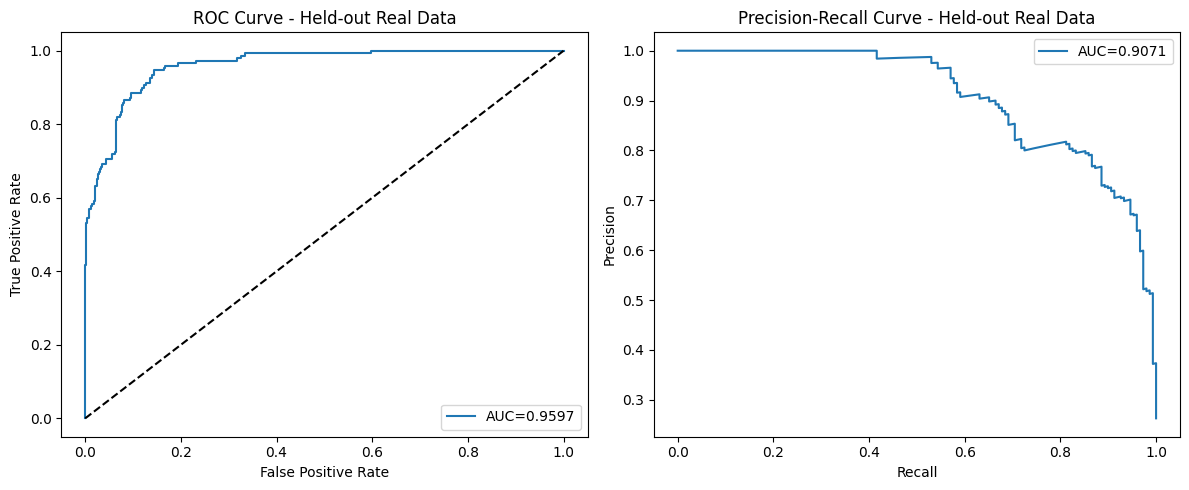


=== Evaluation on Synthetic Data ===

Classification Report:
              precision    recall  f1-score   support

       False     0.7333    0.7132    0.7231      1384
        True     0.2675    0.2877    0.2772       504

    accuracy                         0.5996      1888
   macro avg     0.5004    0.5004    0.5002      1888
weighted avg     0.6090    0.5996    0.6041      1888

Confusion Matrix:
[[987 397]
 [359 145]]
ROC AUC: 0.4996
PR AUC: 0.2739


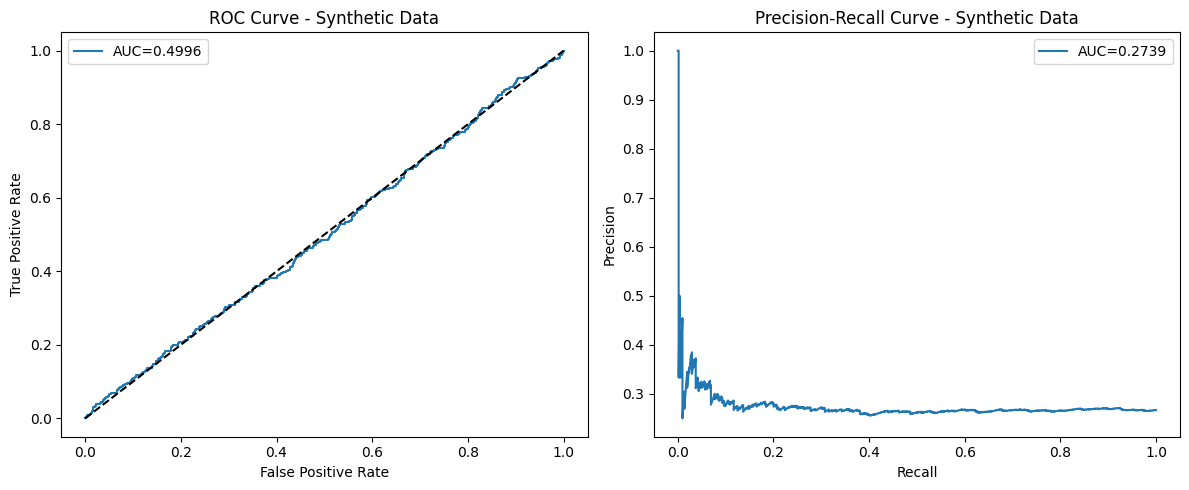

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

ORIG_CSV = 'preprocessedDataset/preprocessed_transaction_data_sm.csv'
SYN_CSV  = 'privacy_synthetic_data.csv'

def load_and_split(orig_csv, target_col='is_fraud', test_size=0.3):
    df = pd.read_csv(orig_csv)
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

def load_synthetic(syn_csv, target_col='is_fraud'):
    df = pd.read_csv(syn_csv)
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y

# 1. Split original into train / held-out test  
X_train, X_test_real, y_train, y_test_real = load_and_split(ORIG_CSV)

# 2. Load synthetic
X_syn, y_syn = load_synthetic(SYN_CSV)

# 3. Identify column types
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object','bool','category']).columns.tolist()

# 4. Build preprocessing + model pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
])

model = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# 5. Train on original
model.fit(X_train, y_train)


from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve,
    precision_recall_curve, auc
)
import matplotlib.pyplot as plt

def evaluate_dataset(model, X, y, name):
    # Predict labels and probabilities
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    print(f"\n=== Evaluation on {name} ===\n")
    print("Classification Report:")
    print(classification_report(y, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # ROC AUC
    roc_auc = roc_auc_score(y, y_prob)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y, y_prob)
    pr_auc = auc(recall, precision)
    print(f"PR AUC: {pr_auc:.4f}")

    # Plot ROC and PR curves
    fpr, tpr, _ = roc_curve(y, y_prob)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(fpr, tpr, label=f"AUC={roc_auc:.4f}")
    ax1.plot([0, 1], [0, 1], "k--")
    ax1.set_title(f"ROC Curve - {name}")
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.legend()

    ax2.plot(recall, precision, label=f"AUC={pr_auc:.4f}")
    ax2.set_title(f"Precision‑Recall Curve - {name}")
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.legend()

    plt.tight_layout()
    plt.show()



# 6. Evaluate on held-out real test set
evaluate_dataset(model, X_test_real, y_test_real, "Held‑out Real Data")

# 7. Evaluate on synthetic data
evaluate_dataset(model, X_syn, y_syn, "Synthetic Data")

# # 6. Evaluate on held-out real test set
# print("=== Evaluation on Held-out Real Data ===")
# y_pred_real = model.predict(X_test_real)
# print(classification_report(y_test_real, y_pred_real, digits=4))

# # 7. Evaluate on synthetic data
# print("=== Evaluation on Synthetic Data ===")
# y_pred_syn = model.predict(X_syn)
# print(classification_report(y_syn, y_pred_syn, digits=4))


### Model II

Loading and preprocessing datasets...

--- Training model on original data ---

Evaluating model trained on original data:

Evaluation on original dataset:
Accuracy: 0.9312
Precision: 0.9195
Recall: 0.8081
F1 Score: 0.8602
ROC AUC: 0.9646

Confusion Matrix:
[[272   7]
 [ 19  80]]

Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.97      0.95       279
        True       0.92      0.81      0.86        99

    accuracy                           0.93       378
   macro avg       0.93      0.89      0.91       378
weighted avg       0.93      0.93      0.93       378


Evaluation on synthesized dataset:
Accuracy: 0.6323
Precision: 0.2738
Recall: 0.2277
F1 Score: 0.2486
ROC AUC: 0.4898

Confusion Matrix:
[[216  61]
 [ 78  23]]

Classification Report:
              precision    recall  f1-score   support

       False       0.73      0.78      0.76       277
        True       0.27      0.23      0.25       101

    accuracy       

D:\IIT\Coursework\Year 4\FYRP\FinalCode\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\IIT\Coursework\Year 4\FYRP\FinalCode\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\IIT\Coursework\Year 4\FYRP\FinalCode\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

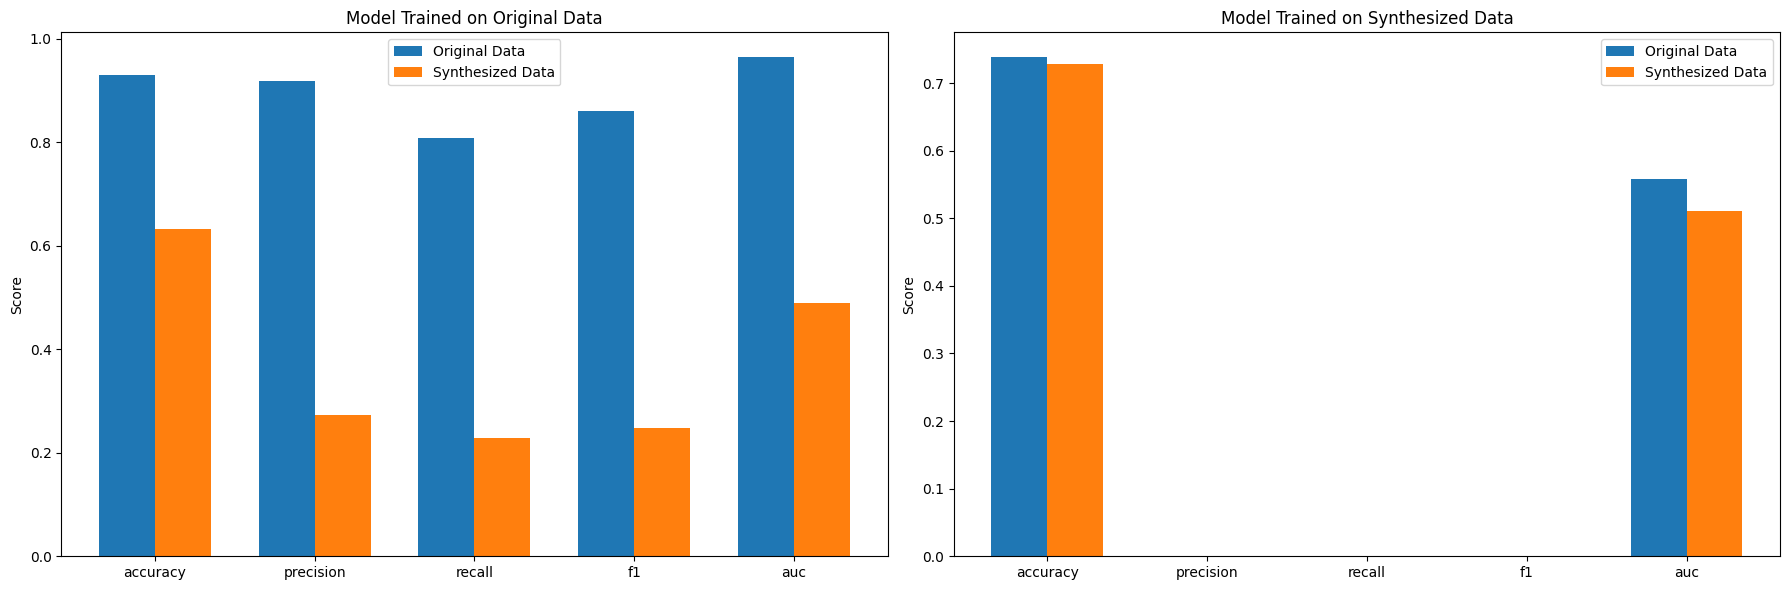

KeyError: 'transaction_id'

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Function to load and preprocess the data
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path)
    
    # Convert timestamp to datetime and extract features
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    
    # Parse velocity features (stored as string representation of dict)
    velocity_features = df['velocity_last_hour'].apply(lambda x: json.loads(x.replace("'", "\"")))
    df['num_transactions'] = velocity_features.apply(lambda x: x['num_transactions'])
    df['total_amount'] = velocity_features.apply(lambda x: x['total_amount'])
    df['unique_merchants'] = velocity_features.apply(lambda x: x['unique_merchants'])
    df['unique_countries'] = velocity_features.apply(lambda x: x['unique_countries'])
    df['max_single_amount'] = velocity_features.apply(lambda x: x['max_single_amount'])
    
    # Drop columns that aren't useful for modeling
    drop_cols = ['transaction_id', 'customer_id', 'card_number', 'timestamp', 
                 'ip_address', 'device_fingerprint', 'velocity_last_hour']
    df = df.drop(columns=drop_cols)
    
    return df

# Define feature preprocessing
def create_preprocessing_pipeline():
    # Identify column types
    categorical_cols = ['merchant_category', 'merchant_type', 'merchant', 'currency', 
                        'country', 'city', 'city_size', 'card_type', 'device', 
                        'channel']
    
    numeric_cols = ['amount', 'distance_from_home', 'hour', 'day_of_week', 'month',
                   'num_transactions', 'total_amount', 'unique_merchants', 
                   'unique_countries', 'max_single_amount']
    
    binary_cols = ['card_present', 'high_risk_merchant', 'weekend_transaction']
    
    # Create preprocessing steps
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols),
        ],
        remainder='passthrough'  # This will pass through binary columns
    )
    
    return preprocessor

# Function to evaluate the model
def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:,1]
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_prob)
    
    print(f"\nEvaluation on {dataset_name} dataset:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y, y_pred)
    print(cm)
    
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': cm
    }

# Function to visualize results
def plot_comparison(results):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot for model trained on original data
    orig_train_data = [results['original_trained_orig_test'][m] for m in metrics]
    orig_train_synth = [results['original_trained_synth_test'][m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    axes[0].bar(x - width/2, orig_train_data, width, label='Original Data')
    axes[0].bar(x + width/2, orig_train_synth, width, label='Synthesized Data')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Model Trained on Original Data')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metrics)
    axes[0].legend()
    
    # Plot for model trained on synthesized data
    synth_train_orig = [results['synth_trained_orig_test'][m] for m in metrics]
    synth_train_synth = [results['synth_trained_synth_test'][m] for m in metrics]
    
    axes[1].bar(x - width/2, synth_train_orig, width, label='Original Data')
    axes[1].bar(x + width/2, synth_train_synth, width, label='Synthesized Data')
    axes[1].set_ylabel('Score')
    axes[1].set_title('Model Trained on Synthesized Data')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(metrics)
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

# Main function to run the experiment
def run_experiment(original_file, synthesized_file):
    # Load datasets
    print("Loading and preprocessing datasets...")
    original_df = load_and_preprocess(original_file)
    synthesized_df = load_and_preprocess(synthesized_file)
    
    # Split original data
    X_orig = original_df.drop('is_fraud', axis=1)
    y_orig = original_df['is_fraud']
    X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(
        X_orig, y_orig, test_size=0.2, random_state=42, stratify=y_orig
    )
    
    # Split synthesized data
    X_synth = synthesized_df.drop('is_fraud', axis=1)
    y_synth = synthesized_df['is_fraud']
    X_synth_train, X_synth_test, y_synth_train, y_synth_test = train_test_split(
        X_synth, y_synth, test_size=0.2, random_state=42, stratify=y_synth
    )
    
    # Create preprocessing pipeline
    preprocessor = create_preprocessing_pipeline()
    
    # Model 1: Train on original data
    print("\n--- Training model on original data ---")
    model_orig = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    model_orig.fit(X_orig_train, y_orig_train)
    
    # Evaluate Model 1 on original test data
    print("\nEvaluating model trained on original data:")
    orig_trained_orig_test = evaluate_model(model_orig, X_orig_test, y_orig_test, "original")
    
    # Evaluate Model 1 on synthesized test data
    orig_trained_synth_test = evaluate_model(model_orig, X_synth_test, y_synth_test, "synthesized")
    
    # Model 2: Train on synthesized data
    print("\n--- Training model on synthesized data ---")
    model_synth = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    model_synth.fit(X_synth_train, y_synth_train)
    
    # Evaluate Model 2 on original test data
    print("\nEvaluating model trained on synthesized data:")
    synth_trained_orig_test = evaluate_model(model_synth, X_orig_test, y_orig_test, "original")
    
    # Evaluate Model 2 on synthesized test data
    synth_trained_synth_test = evaluate_model(model_synth, X_synth_test, y_synth_test, "synthesized")
    
    # Compile all results
    results = {
        'original_trained_orig_test': orig_trained_orig_test,
        'original_trained_synth_test': orig_trained_synth_test,
        'synth_trained_orig_test': synth_trained_orig_test,
        'synth_trained_synth_test': synth_trained_synth_test
    }
    
    # Visualize results
    plot_comparison(results)
    
    # Feature importance analysis
    feature_names = (
        [f'num_{col}' for col in X_orig.columns if col in numeric_cols] +
        [f'cat_{val}' for col in categorical_cols for val in original_df[col].unique()] +
        [col for col in X_orig.columns if col in binary_cols]
    )
    
    # Get feature importances for both models
    importances_orig = model_orig.named_steps['classifier'].feature_importances_
    importances_synth = model_synth.named_steps['classifier'].feature_importances_
    
    # Only look at top features to avoid cluttered visualization
    indices_orig = np.argsort(importances_orig)[-15:]
    indices_synth = np.argsort(importances_synth)[-15:]
    
    # Plot feature importances
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 1, 1)
    plt.title('Feature Importances (Model Trained on Original Data)')
    plt.barh(range(len(indices_orig)), importances_orig[indices_orig])
    plt.yticks(range(len(indices_orig)), [feature_names[i] if i < len(feature_names) else f'feature_{i}' for i in indices_orig])
    
    plt.subplot(2, 1, 2)
    plt.title('Feature Importances (Model Trained on Synthesized Data)')
    plt.barh(range(len(indices_synth)), importances_synth[indices_synth])
    plt.yticks(range(len(indices_synth)), [feature_names[i] if i < len(feature_names) else f'feature_{i}' for i in indices_synth])
    
    plt.tight_layout()
    plt.savefig('feature_importance_comparison.png')
    plt.show()
    
    return results

if __name__ == "__main__":
    # Replace these with your actual file paths
    original_file = "preprocessedDataset/preprocessed_transaction_data_sm.csv"
    synthesized_file = "privacy_synthetic_data.csv"
    
    results = run_experiment(original_file, synthesized_file)
    
    # Additional analysis: Compare model performances
    print("\n--- Performance Summary ---")
    
    orig_on_orig = results['original_trained_orig_test']
    orig_on_synth = results['original_trained_synth_test']
    synth_on_orig = results['synth_trained_orig_test']
    synth_on_synth = results['synth_trained_synth_test']
    
    print("Original model on original data vs synthesized data:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
        diff = orig_on_orig[metric] - orig_on_synth[metric]
        print(f"{metric}: {diff:.4f} ({diff*100:.2f}% difference)")
    
    print("\nSynthesized model on original data vs synthesized data:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
        diff = synth_on_synth[metric] - synth_on_orig[metric]
        print(f"{metric}: {diff:.4f} ({diff*100:.2f}% difference)")
    
    print("\nOriginal vs Synthesized model on original data:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
        diff = orig_on_orig[metric] - synth_on_orig[metric]
        print(f"{metric}: {diff:.4f} ({diff*100:.2f}% difference)")
    
    print("\nOriginal vs Synthesized model on synthesized data:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
        diff = orig_on_synth[metric] - synth_on_synth[metric]
        print(f"{metric}: {diff:.4f} ({diff*100:.2f}% difference)")

### Model III

Loading datasets...
Original dataset shape: (1888, 24)
Synthesized dataset shape: (1888, 24)
Using 24 common columns for analysis

--- Model 1: Training on original data ---

--- Model 2: Training on synthesized data ---

=== RESULTS ===

Model trained on original data, tested on original data:
Accuracy: 0.8642
Precision: 0.6667
Recall: 0.8062
F1 Score: 0.7298
Confusion Matrix:
[[386  52]
 [ 25 104]]

Model trained on original data, tested on synthesized data:
Accuracy: 0.6032
Precision: 0.2443
Recall: 0.3185
F1 Score: 0.2765
Confusion Matrix:
[[299 133]
 [ 92  43]]

Model trained on synthesized data, tested on original data:
Accuracy: 0.7443
Precision: 0.3571
Recall: 0.1550
F1 Score: 0.2162
Confusion Matrix:
[[402  36]
 [109  20]]

Model trained on synthesized data, tested on synthesized data:
Accuracy: 0.6984
Precision: 0.1786
Recall: 0.0741
F1 Score: 0.1047
Confusion Matrix:
[[386  46]
 [125  10]]


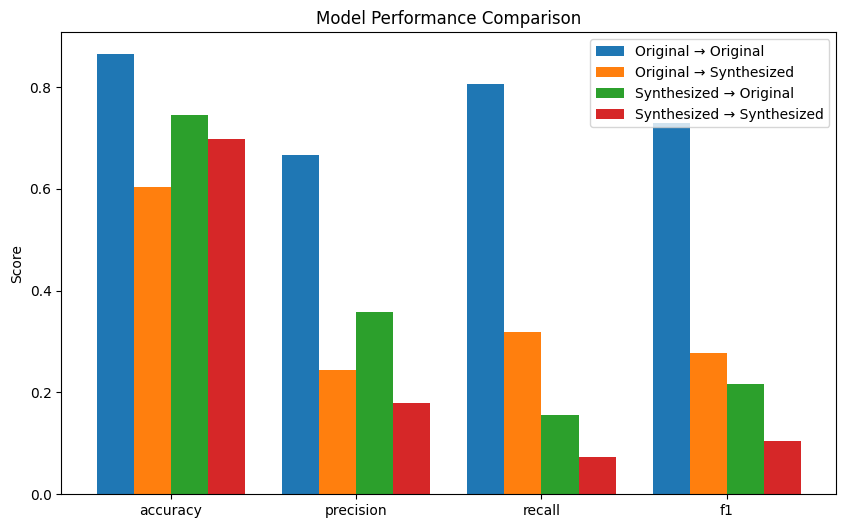

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def run_experiment(original_file, synthesized_file):
    # Load datasets
    print("Loading datasets...")
    original_df = pd.read_csv(original_file)
    synthesized_df = pd.read_csv(synthesized_file)
    
    # Print basic info
    print(f"Original dataset shape: {original_df.shape}")
    print(f"Synthesized dataset shape: {synthesized_df.shape}")
    
    # Ensure both datasets have the target column
    if 'is_fraud' not in original_df.columns or 'is_fraud' not in synthesized_df.columns:
        print("Error: 'is_fraud' column not found in one or both datasets")
        return
    
    # Find common columns between datasets
    common_cols = list(set(original_df.columns) & set(synthesized_df.columns))
    print(f"Using {len(common_cols)} common columns for analysis")
    
    # Remove non-numeric columns that might cause issues
    X_cols = [col for col in common_cols if col != 'is_fraud' and 
              pd.api.types.is_numeric_dtype(original_df[col]) and 
              pd.api.types.is_numeric_dtype(synthesized_df[col])]
    
    # Prepare data
    X_orig = original_df[X_cols]
    y_orig = original_df['is_fraud']
    
    X_synth = synthesized_df[X_cols]
    y_synth = synthesized_df['is_fraud']
    
    # Split data
    X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(
        X_orig, y_orig, test_size=0.3, random_state=42
    )
    
    X_synth_train, X_synth_test, y_synth_train, y_synth_test = train_test_split(
        X_synth, y_synth, test_size=0.3, random_state=42
    )
    
    # Build and train models
    print("\n--- Model 1: Training on original data ---")
    model_orig = RandomForestClassifier(n_estimators=100, random_state=42)
    model_orig.fit(X_orig_train, y_orig_train)
    
    print("\n--- Model 2: Training on synthesized data ---")
    model_synth = RandomForestClassifier(n_estimators=100, random_state=42)
    model_synth.fit(X_synth_train, y_synth_train)
    
    # Evaluate models
    results = {}
    
    # Model 1 on original test data
    y_pred = model_orig.predict(X_orig_test)
    results['orig_on_orig'] = {
        'accuracy': accuracy_score(y_orig_test, y_pred),
        'precision': precision_score(y_orig_test, y_pred),
        'recall': recall_score(y_orig_test, y_pred),
        'f1': f1_score(y_orig_test, y_pred),
        'cm': confusion_matrix(y_orig_test, y_pred)
    }
    
    # Model 1 on synthesized test data
    y_pred = model_orig.predict(X_synth_test)
    results['orig_on_synth'] = {
        'accuracy': accuracy_score(y_synth_test, y_pred),
        'precision': precision_score(y_synth_test, y_pred),
        'recall': recall_score(y_synth_test, y_pred),
        'f1': f1_score(y_synth_test, y_pred),
        'cm': confusion_matrix(y_synth_test, y_pred)
    }
    
    # Model 2 on original test data
    y_pred = model_synth.predict(X_orig_test)
    results['synth_on_orig'] = {
        'accuracy': accuracy_score(y_orig_test, y_pred),
        'precision': precision_score(y_orig_test, y_pred),
        'recall': recall_score(y_orig_test, y_pred),
        'f1': f1_score(y_orig_test, y_pred),
        'cm': confusion_matrix(y_orig_test, y_pred)
    }
    
    # Model 2 on synthesized test data
    y_pred = model_synth.predict(X_synth_test)
    results['synth_on_synth'] = {
        'accuracy': accuracy_score(y_synth_test, y_pred),
        'precision': precision_score(y_synth_test, y_pred),
        'recall': recall_score(y_synth_test, y_pred),
        'f1': f1_score(y_synth_test, y_pred),
        'cm': confusion_matrix(y_synth_test, y_pred)
    }
    
    # Print results
    print("\n=== RESULTS ===")
    
    print("\nModel trained on original data, tested on original data:")
    print_metrics(results['orig_on_orig'])
    
    print("\nModel trained on original data, tested on synthesized data:")
    print_metrics(results['orig_on_synth'])
    
    print("\nModel trained on synthesized data, tested on original data:")
    print_metrics(results['synth_on_orig'])
    
    print("\nModel trained on synthesized data, tested on synthesized data:")
    print_metrics(results['synth_on_synth'])
    
    # Visualize results
    plot_comparison(results)
    
    return results

def print_metrics(metrics):
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print("Confusion Matrix:")
    print(metrics['cm'])

def plot_comparison(results):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define width and positions
    width = 0.2
    x = np.arange(len(metrics))
    
    # Plot bars for each scenario
    ax.bar(x - width*1.5, [results['orig_on_orig'][m] for m in metrics], width, label='Original → Original')
    ax.bar(x - width/2, [results['orig_on_synth'][m] for m in metrics], width, label='Original → Synthesized')
    ax.bar(x + width/2, [results['synth_on_orig'][m] for m in metrics], width, label='Synthesized → Original')
    ax.bar(x + width*1.5, [results['synth_on_synth'][m] for m in metrics], width, label='Synthesized → Synthesized')
    
    # Add labels and legend
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    
    plt.savefig('fraud_detection_comparison.png')
    plt.show()

if __name__ == "__main__":
    # Replace with your file paths
    original_file = "preprocessedDataset/preprocessed_transaction_data_sm.csv"
    synthesized_file = "privacy_synthetic_data.csv"
    
    run_experiment(original_file, synthesized_file)